In [1]:
import os 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn import metrics
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_regression 
from sklearn.preprocessing import StandardScaler
from math import log 
from sklearn.decomposition import PCA
from scipy.stats import mannwhitneyu

from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

%matplotlib inline

In [2]:
def list_writer(ur_list, file_name):

    import csv

    with open(file_name, 'w', newline='') as myfile:
         wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
         wr.writerow(ur_list)

In [3]:
def list_reader(file,  encoding="utf8"):

    import csv

    with open(file, newline='') as f:
        reader = csv.reader(f)
        data = list(reader)
    data = data[0]

    return data

In [4]:
# This function filters CpGs which are typically tightly regulated throughout lifespan and in multiple cell types. 
# It does so by first finding those CpGs which are mostly "on" or "off", and which have a very tight standard deviation 
# (to prevent selecting those which have a significant age-correlation)

def get_cands(df):

    candidates = []

    for col in df.columns:
        
        mean = df[col].values.mean()
        std = df[col].values.std()

        if (mean < 0.15 or mean > 0.85 ) and std < 0.02:
            candidates += [col]
            
            
    return candidates    

In [5]:
from statsmodels.stats.diagnostic import het_white
import statsmodels.api as sm

def get_het(df, ages, cgs):
    
    cg_list=[]
    y = ages
    
    for cg in cgs:
    
        x = df[cg].tolist()

        #add constant to predictor variables
        x = sm.add_constant(x)

        #fit regression model
        model = sm.OLS(y, x).fit()

        #perform White's test
        white_test = het_white(model.resid,  model.model.exog)

        if white_test[1]<0.05:
            cg_list+= [cg]
            
        
    return cg_list

In [6]:
def noise_predict(df, means, mads):
    
    diffs = pd.DataFrame()
    
    for i in range(len(df.columns)):
        
        raw = abs(df[df.columns[i]]-means[i])
        
        standardized = raw/mads[i]
        
        diffs[df.columns[i]] = standardized
    
    return diffs

In [7]:
def get_sig_cgs(df, ages, cgs, lowerbound, cutoff):
    
    sig_cgs = []
    mature = df[ages >= lowerbound]
    
    for cg in cgs:
        
        #check correlation coefficient between feature and age based on a lower bound age
        if np.corrcoef(mature[cg].tolist(), ages[ages >= lowerbound])[0,1] >= cutoff:
            
            sig_cgs += [cg]
            
    return sig_cgs
        


In [8]:
from math import log2
# x is a vector of beta values; returns the average entropy for the column
def shentropy(x):
    entropy=0
    for beta in x:
        if beta == 0 or beta==1:
            continue
        else:
            entropy += -1*(beta*log2(beta)+(1-beta)*log2(1-beta))
    entropy = 1/len(x)*entropy
    
    return entropy   

In [9]:
def get_shentropy(df):
    
    ents=[]
    for i in range(len(df.index)):
        ents+=[shentropy(df.iloc[i,:])]
        
    return ents       

In [10]:
def dist_shift(df, meta, ctl_name, cgs):
    
    df=df[cgs]

    healthy = df[meta.disease_state==ctl_name]
    disease = df[meta.disease_state!=ctl_name]

    h_means = healthy.mean()
    d_means = disease.mean()

    mean_shift=[]
    extreme_shift=[]

    for cg in cgs:

        if h_means[cg] < 0.5:

            mean_shift+=[d_means[cg]-h_means[cg]]
            extreme_shift+=[disease[cg].min()-healthy[cg].min()]

        else:

            mean_shift+=[h_means[cg]-d_means[cg]]
            extreme_shift+=[healthy[cg].max()-disease[cg].max()]


    hvd = pd.DataFrame({'mean_difference': mean_shift, 'extreme_val_difference':extreme_shift})
    hvd.index=cgs
    hvd.sort_values('mean_difference',ascending=False, inplace=True)
    
    return hvd

# Stddev analysis 

In [2249]:
# # pesa = np.load('Datasets/PESA/PESA.npy', allow_pickle=True)
# pesa_meta = pd.read_excel('Datasets/PESA/PESA_pmeta.xlsx')
# cg_list = list_reader('Datasets/PESA/cgs.txt')
# pesa = pd.DataFrame(pesa, columns=cg_list)

In [147]:
# file_path = 'Datasets/Parkinsons Horvath/'
# park = pd.read_pickle(file_path+'Parkinsons.pkl')
# park_meta = pd.read_excel(file_path+'Parkinsons_pmeta.xlsx')

In [12]:
art = np.load('Datasets/Arthritis/Arthritis32_full.npy', allow_pickle=True)
art_meta = pd.read_excel('Datasets/Arthritis/Arthritis_pmeta.xlsx')
cgs=list_reader('Datasets/Arthritis/cgs_full.txt')
art = pd.DataFrame(art, columns=cgs)
# art=art[comb_list]

In [2239]:
# art2 = np.load('Datasets/Arthritis2/Arthritis2.npy', allow_pickle=True)
# art2_meta = pd.read_excel('Datasets/Arthritis2/Arthritis2_pmeta.xlsx')
# cgs=list_reader('Datasets/Arthritis2/cgs.txt')
# art2 = pd.DataFrame(art2, columns=cgs)

In [10]:
pag = np.load('Datasets/Pagets/Pagets32.npy', allow_pickle=True)
pag_meta = pd.read_excel('Datasets/Pagets/Pagets_pmeta.xlsx')
cgs=list_reader('Datasets/Pagets/cgs.txt')
pag = pd.DataFrame(pag, columns=cgs)

In [11]:
park = np.load('Datasets/Parkinsons Vallerga/Parkinsons32.npy', allow_pickle=True)
park_meta = pd.read_excel('Datasets/Parkinsons Vallerga/Parkinsons_Vallerga_pmeta.xlsx')
cgs=list_reader('Datasets/Parkinsons Vallerga/cgs.txt')
park = pd.DataFrame(park, columns=cgs)
# park=park[filtered]

In [12]:
alz = np.load('Datasets/Alzheimers/Alzheimers.npy', allow_pickle=True)
alz_meta = pd.read_excel('Datasets/Alzheimers/Alzheimers_pmeta.xlsx')
cgs=list_reader('Datasets/Alzheimers/cgs.txt')
alz = pd.DataFrame(alz, columns=cgs)

In [47]:
dep = np.load('Datasets/Depression/Depression32_full.npy', allow_pickle=True)
dep_meta = pd.read_excel('Datasets/Depression/Depression_pmeta.xlsx')
cg_list = list_reader('Datasets/Depression/cgs_full.txt')
dep = pd.DataFrame(dep, columns=cg_list)
dep=dep[comb_list]

In [48]:
ms = pd.read_pickle('Datasets/MS/MS32.pkl')
ms_meta = pd.read_excel('Datasets/MS/MS_pmeta.xlsx')
from sklearn.impute import KNNImputer
# Create an instance of KNNImputer
imputer = KNNImputer(n_neighbors=2)
# Fit and transform the DataFrame with the imputer
imputed = imputer.fit_transform(ms)
ms = pd.DataFrame(imputed, columns=ms.columns)
ms=ms[comb_list]

In [49]:
park = pd.read_pickle('Datasets/Parkinsons Horvath/Parkinsons32.pkl')
park_meta = pd.read_excel('Datasets/Parkinsons Horvath/Parkinsons_pmeta.xlsx')
park=park.reset_index(drop=True)
from sklearn.impute import KNNImputer
# Create an instance of KNNImputer
imputer = KNNImputer(n_neighbors=2)
# Fit and transform the DataFrame with the imputer
imputed = imputer.fit_transform(park)
park = pd.DataFrame(imputed, columns=park.columns)
# park=park[filtered]

In [50]:
tau = np.load('Datasets/Tauopathy/Tauopathy32.npy', allow_pickle=True)
tau_meta = pd.read_excel('Datasets/Tauopathy/Tauopathy_pmeta.xlsx')
cg_list = list_reader('Datasets/Tauopathy/cgs.txt')
tau = pd.DataFrame(tau, columns=cg_list)
tau=tau[comb_list]

In [32]:
del art, ms, dep, tau, park

## Filter on health-invariant CpGs

In [11]:
manifest = pd.read_csv('450K manifest.csv', low_memory=False)
# Get all SNP-associated CpGs in 450K array 
snps = set(manifest[~manifest.Probe_SNPs.isna()].Name)
comb_list = list(set(cgs)-set(snps))

sex_chrs = set(manifest[(manifest.CHR=='X') | (manifest.CHR=='Y')].Name)
comb_list = list(set(comb_list)-set(sex_chrs))

In [12]:
pag=pag[comb_list]

In [13]:
pag_cands = get_cands(pag)
len(pag_cands)

186714

In [42]:
# art_cands = get_het(art, art_meta.age, filtered)
# len(art_cands)

6120

In [59]:
overlap = list((set(filtered) & set(alz.columns)))

In [83]:
hvd['sign']=hvd.mean_difference*hvd.extreme_val_difference
filtered = hvd[hvd.sign>0].index
len(filtered)

9905

In [84]:
# Get list of CpGs for which the standard deviation is higher in disease than healthy
park=park[filtered]
healthy = park[park_meta.disease_state=='Control']
disease = park[park_meta.disease_state!='Control']
hstds = healthy.std()
dstds = disease.std()
hvd_df = pd.DataFrame({'hstds': hstds, 'dstds':dstds, 'difference':dstds-hstds})
hvd_df=hvd_df.sort_values('difference',ascending=False)
filtered = hvd_df[hvd_df.difference>0].index
len(filtered)

3584

In [13]:
# # Get list of CpGs for which the standard deviation is higher in disease than healthy and filter pag dataframe
# df = pag[pag_cands]
# healthy = df[pag_meta.disease_state=='Control']
# disease = df[pag_meta.disease_state!='Control']
# hstds = healthy.std()
# dstds = disease.std()
# hvd_df = pd.DataFrame({'hstds': hstds, 'dstds':dstds, 'difference':dstds-hstds})
# pag_hvd_df=hvd_df.sort_values('difference',ascending=False)

# Top noisy CpGs

In [26]:
pag_noise = dist_shift(pag, pag_meta, 'Control', comb_list)

In [29]:
alz_noise = dist_shift(alz, alz_meta, 'healthy control', comb_list)

In [33]:
park_noise = dist_shift(park, park_meta, 'Control', comb_list)

In [122]:
reduced =list(set(pag_noise.index[:2000])&set(alz_noise.index[:2000])&set(park_noise.index[:2000]))

In [123]:
len(reduced)

578

In [1]:
df=df[cgs]

healthy = df[df_meta.disease_state==ctl_name]
disease = df[df_meta.disease_state!=ctl_name]

h_means = healthy.mean()
d_means = disease.mean()

mean_shift=[]
extreme_shift=[]

for cg in filtered:

    if h_means[cg] < 0.5:

        mean_shift+=[d_means[cg]-h_means[cg]]
        extreme_shift+=[disease[cg].min()-healthy[cg].min()]

    else:

        mean_shift+=[h_means[cg]-d_means[cg]]
        extreme_shift+=[healthy[cg].max()-disease[cg].max()]


hvd = pd.DataFrame({'mean_difference': mean_shift, 'extreme_val_difference':extreme_shift})
hvd.index=filtered

NameError: name 'df' is not defined

In [214]:
park_hvd = park[park_cands]

In [16]:
manifest = pd.read_csv('450K manifest.csv', low_memory=False)
# Get all SNP-associated CpGs in 450K array 
snps = set(manifest[~manifest.Probe_SNPs.isna()].Name)
no_snps = list(set(pag_cands)-set(snps))

In [17]:
sex_chrs = set(manifest[(manifest.CHR=='X') | (manifest.CHR=='Y')].Name)
filtered = list(set(no_snps)-set(sex_chrs))

In [19]:
len(filtered)

186119

In [20]:
overlap = list(set(alz.columns)&set(filtered))
# Get list of CpGs for which the standard deviation is higher in disease than healthy
df = alz[overlap]
healthy = df[alz_meta.disease_state=='healthy control']
disease = df[alz_meta.disease_state!='healthy control']
hstds = healthy.std()
dstds = disease.std()
hvd_df = pd.DataFrame({'hstds': hstds, 'dstds':dstds, 'difference':dstds-hstds})
alz_hvd_df=hvd_df.sort_values('difference',ascending=False)

In [21]:
alz_cands = alz_hvd_df[alz_hvd_df.difference>0].index

In [24]:
len(alz_cands)

106128

In [26]:
list_writer(alz_cands.tolist(),'Datasets/Combined/temp_pag_alz_cgs.txt')

In [11]:
pagalz = list_reader('Datasets/Combined/temp_pag_alz_cgs.txt')

In [12]:
overlap = list(set(park.columns)&set(pagalz))

In [13]:
len(overlap)

106128

In [14]:
park = park[overlap]

In [17]:
# overlap = list(set(park.columns)&set(alz_cands))
# Get list of CpGs for which the standard deviation is higher in disease than healthy
# df = park[overlap]
healthy = park[park_meta.disease_state=='Control']
disease = park[park_meta.disease_state!='Control']
hstds = healthy.std()
dstds = disease.std()
hvd_df = pd.DataFrame({'hstds': hstds, 'dstds':dstds, 'difference':dstds-hstds})
park_hvd_df=hvd_df.sort_values('difference',ascending=False)

In [20]:
final_cands = park_hvd_df[park_hvd_df.difference>0].index

In [22]:
len(final_cands)

40166

In [33]:
list_writer(final_cands.tolist(),'Datasets/Combined/temp_pag_alz_park_cgs.txt')

In [11]:
final_cands = list_reader('Datasets/Combined/temp_pag_alz_park_cgs.txt')

In [193]:
# pag=pag[filtered]

healthy = pag[pag_meta.disease_state=='Control']
disease = pag[pag_meta.disease_state!='Control']

h_means = healthy.mean()
d_means = disease.mean()

mean_shift=[]
extreme_shift=[]

for cg in filtered:
    
    if h_means[cg] < 0.5:
        
        mean_shift+=[d_means[cg]-h_means[cg]]
        extreme_shift+=[disease[cg].min()-healthy[cg].min()]
        
    else:
        
        mean_shift+=[h_means[cg]-d_means[cg]]
        extreme_shift+=[healthy[cg].max()-disease[cg].max()]
        

hvd = pd.DataFrame({'mean_difference': mean_shift, 'extreme_val_difference':extreme_shift})
hvd.index=filtered

In [194]:
hvd['sign']=hvd.mean_difference*hvd.extreme_val_difference
filtered = hvd[hvd.sign>0].index
len(filtered)

In [15]:
manifest = pd.read_csv('450K manifest.csv', low_memory=False)

In [115]:
# Get all SNP-associated CpGs in 450K array 
snps = set(manifest[~manifest.Probe_SNPs.isna()].Name)

In [1081]:
noisy_no_snps = list(set(noisy_cgs)-set(snps))

In [110]:
v5_cgs = pd.read_excel('Models/random_forests/V5/V5_feature_selection.xlsx')

In [111]:
dis = art[art_meta.healthy==1]
hlty = art[art_meta.healthy==0]

In [1887]:
test_cands = []
for cg in noisy_park:
    
    dent = shentropy(dis[cg])
    hent = shentropy(hlty[cg])
        
    if dent > hent:
        test_cands += [cg]       

In [1888]:
len(test_cands)

894

Text(0, 0.5, 'cg18075115')

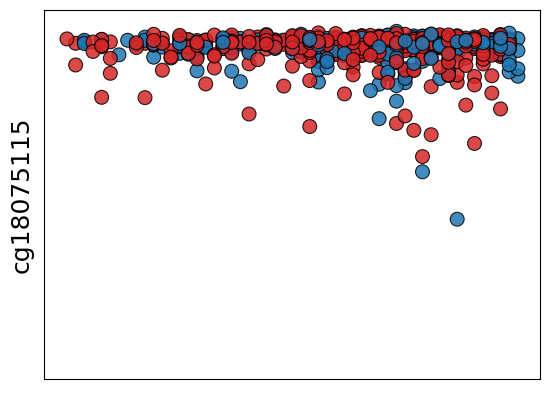

In [185]:
blue = sns.color_palette()[0]
red=sns.color_palette()[3]

conditions=['Normal', 'Rheumatoid arthritis']
    
custom= {conditions[0]:blue, conditions[1]:red}
# Define the desired order of categories
category_order = [conditions[0], conditions[1]]

cgoi=v5_cgs.CpG[89]

sns.scatterplot(x= art_meta.age, y=art[cgoi], hue=art_meta.disease_state,
                s=100, palette=custom,  alpha=0.85, edgecolor="k",legend=False)

plt.ylim([-0.05,1.05])
plt.xticks([]);
plt.yticks([]);
plt.xlabel('');
plt.ylabel(cgoi,fontsize=18)

Text(0, 0.5, 'cg18075115')

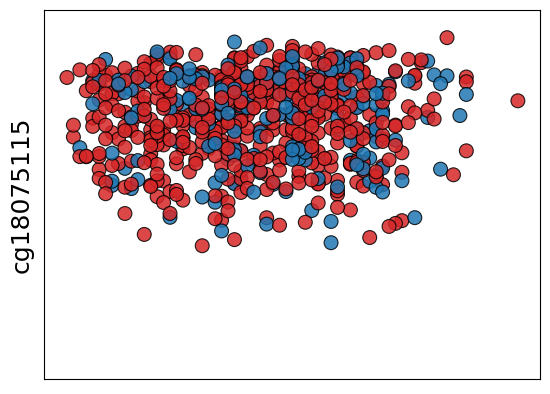

In [186]:
blue = sns.color_palette()[0]
red=sns.color_palette()[3]

conditions=['Control', 'Case']
    
custom= {conditions[0]:blue, conditions[1]:red}
# Define the desired order of categories
category_order = [conditions[0], conditions[1]]

cgoi=v5_cgs.CpG[89]

sns.scatterplot(x= dep_meta.age, y=dep[cgoi], hue=dep_meta.disease_state,
                s=100, palette=custom,  alpha=0.85, edgecolor="k",legend=False)

plt.ylim([-0.05,1.05])
plt.xticks([]);
plt.yticks([]);
plt.xlabel('');
plt.ylabel(cgoi,fontsize=18)

Text(0, 0.5, 'cg18075115')

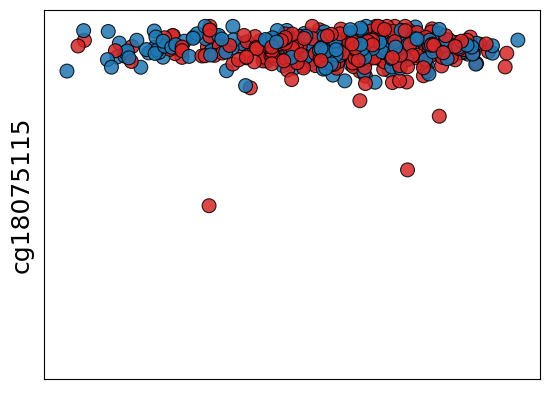

In [187]:
blue = sns.color_palette()[0]
red=sns.color_palette()[3]

conditions=['Control', 'Parkinson\'s disease']
    
custom= {conditions[0]:blue, conditions[1]:red}
# Define the desired order of categories
category_order = [conditions[0], conditions[1]]

cgoi=v5_cgs.CpG[89]

sns.scatterplot(x= park_meta.age, y=park[cgoi], hue=park_meta.disease_state,
                s=100, palette=custom,  alpha=0.85, edgecolor="k",legend=False)

plt.ylim([-0.05,1.05])
plt.xticks([]);
plt.yticks([]);
plt.xlabel('');
plt.ylabel(cgoi,fontsize=18)

In [1760]:
# list_writer(art_cands.tolist(), 'Datasets/Noisy cgs/arthritis_noisy_cgs.txt')

In [28]:
y_bar = pd.read_pickle('Datasets/Combined/EN/V4/composite_young.pkl')

In [29]:
# # Get list of CpGs for which the standard deviation is higher in old than young
# young = df[(art_meta.age>=25) & (art_meta.age<=35)]
# old = df[art_meta.age>=65]
# ystds=young.std()
# ostds = old.std()
# yvo_df = pd.DataFrame({'ystds': ystds, 'ostds':ostds, 'difference':ostds-ystds})
# yvo_df= yvo_df.sort_values('difference',ascending=False)

In [52]:
art=art[filtered]

In [53]:
# Get list of CpGs for which the standard deviation is higher in disease than healthy

healthy = art[art_meta.disease_state=='Normal']
disease = art[art_meta.disease_state!='Normal']
hstds = healthy.std()
dstds = disease.std()
hvd_df = pd.DataFrame({'hstds': hstds, 'dstds':dstds, 'difference':dstds-hstds})
hvd_df=hvd_df.sort_values('difference',ascending=False)
filtered = hvd_df[hvd_df.difference>0].index

# Get angles between noisy CpGs and young reference

In [14]:
# comb = np.load('Datasets/Combined/EN/V4/combined_V4.npy', allow_pickle=True)
comb = pd.read_pickle('Datasets/Combined/EN/V4/V4_young.pkl')
comb_meta = pd.read_excel('Datasets/Combined/EN/V4/V4_young_meta.xlsx')
# cg_list = list_reader('Datasets/Combined/EN/V4/combined_V4_cgs.txt')
# comb = pd.DataFrame(comb, columns=cg_list)

In [19]:
comb_meta[(comb_meta.age>=27)&(comb_meta.age<=29)]

Unnamed: 0      REF_ID   age  gender smoking_status disease_state  \
4           53  GSM1051590  28.0  Female        current        Normal   
7           94  GSM1051643  29.0  Female     occasional        Normal   
13         187  GSM1051802  27.0    Male     occasional        Normal   
14         193  GSM1051808  27.0    Male          never        Normal   
17         224  GSM1051843  29.0  Female          never        Normal   
19         318  GSM1052137  28.0  Female          never        Normal   
21         345  GSM1272161  29.0  Female        unknown       Control   
24         353  GSM1272169  29.0  Female        unknown       Control   
28         396  GSM1653285  27.0    Male        unknown       Control   
29         409  GSM1653298  27.0    Male        unknown       Control   
30         415  GSM1653304  29.0    Male        unknown       Control   

    healthy series_id  
4         0  GSE42861  
7         0  GSE42861  
13        0  GSE42861  
14        0  GSE42861  
17        0  GSE42861  
19        0  GSE42861  
21        0  GSE52588  
24        0  GSE52588  
28        0  GSE67705  
29        0  GSE67705  
30        0  GSE67705

In [21]:
y_bar = comb[(comb_meta.age>=27)&(comb_meta.age<=29)].mean()

In [24]:
y_bar = pd.DataFrame(y_bar)

In [1765]:
# y_comb_meta = comb_meta[(comb_meta.age>=25)&(comb_meta.age<=32)]

In [1766]:
# y_comb = comb.loc[y_comb_meta.index]

In [1767]:
# from sklearn.impute import KNNImputer
# # Create an instance of KNNImputer
# imputer = KNNImputer(n_neighbors=3)
# # Fit and transform the DataFrame with the imputer
# imputed= imputer.fit_transform(y_comb)
# y_comb = pd.DataFrame(imputed, columns=y_comb.columns)

In [1768]:
# # y_comb.to_pickle('Datasets/Combined/EN/V4/V4_young.pkl')
# y_comb=pd.read_pickle('Datasets/Combined/EN/V4/V4_young.pkl')
# # y_comb_meta.to_excel('Datasets/Combined/EN/V4/V4_young_meta.xlsx')
# y_comb_meta = pd.read_excel('Datasets/Combined/EN/V4/V4_young_meta.xlsx')

In [1769]:
# art_hvd=pd.read_pickle('Datasets/Arthritis/hvd_noisy_cpgs.pkl')
# pag_hvd=pd.read_pickle('Datasets/Pagets/hvd_noisy_cpgs.pkl')
# park_hvd=pd.read_pickle('Datasets/Parkinsons Vallerga/hvd_noisy_cpgs.pkl')

In [2206]:
# pag_list = overlap.copy()
# mean_diff = 0
# flag = 0

# for cg in pag_list: 
    
#     if flag==0:
        
#         angles =[]
#         reduced=pag[pag_list]
#         v1=y_bar[pag_list]
#         l1 = np.linalg.norm(v1)

#         for i in range(len(pag_meta)):

#             v2 = reduced.iloc[i]
#             dot = np.dot(v1,v2, out=None)[0]   
#             l2 = np.linalg.norm(v2)
#             cos_angle= dot/ (l1 * l2)
#             angle = np.arccos(cos_angle)

#             angles += [angle]    

#         pag_meta['Distance'] = angles

#         h_mean = pag_meta[pag_meta.healthy==0].Distance.mean()
#         d_mean = pag_meta[pag_meta.healthy==1].Distance.mean()
        
#         mean_diff = d_mean-h_mean
#         flag=1 
    
#     else:
#         temp_list = pag_list.copy()
#         temp_list.remove(cg)
        
#         angles =[]
#         reduced=pag[temp_list]
#         v1=y_bar[temp_list]
#         l1 = np.linalg.norm(v1)

#         for i in range(len(pag_meta)):

#             v2 = reduced.iloc[i]
#             dot = np.dot(v1,v2, out=None)[0]   
#             l2 = np.linalg.norm(v2)
#             cos_angle= dot/ (l1 * l2)
#             angle = np.arccos(cos_angle)

#             angles += [angle]    

#         pag_meta['Distance'] = angles

#         h_mean = pag_meta[pag_meta.healthy==0].Distance.mean()
#         d_mean = pag_meta[pag_meta.healthy==1].Distance.mean()
        
#         diff = d_mean - h_mean

#         if diff > mean_diff:
#             pag_list.remove(cg)
#             mean_diff = diff
#             print(mean_diff)


In [2125]:
# list_writer(new_list, 'Datasets/Noisy cgs/filtered_final.txt')

In [2084]:
# comb_list = list(set(pag_list) | set(new_list2))

In [2208]:
# list_writer(comb_list, 'Datasets/Noisy cgs/combined_filtered_final.txt')

In [101]:
comb_list = list_reader('Datasets/Noisy cgs/combined_filtered_final.txt')

In [127]:
comb_list = list_reader('Datasets/Noisy cgs/filtered_final.txt')

In [38]:
comb_list = list_reader('Datasets/Noisy cgs/Art_pag_park_filtered.txt')

In [13]:
comb_list = list_reader('Datasets/Noisy cgs/pag_alz_park_filtered.txt')

In [51]:
len(comb_list)

3584

In [18]:
#This is the composite young and healthy reference
y_bar = pd.read_pickle('Datasets/Combined/EN/V4/composite_young.pkl')

In [19]:
overlap = list(set(comb_list) & set(y_bar.columns))

In [20]:
len(overlap)

3584

In [10]:
# angles =[]
# reduced=art2[comb_list]
# v1=y_bar[comb_list]
# l1 = np.linalg.norm(v1)

# for i in range(len(art2_meta)):
    
#     v2 = reduced.iloc[i]
#     dot = np.dot(v1,v2, out=None)[0]   
#     l2 = np.linalg.norm(v2)
#     cos_angle= dot/ (l1 * l2)
#     angle = np.arccos(cos_angle)
    
#     angles += [angle]    
    
# art2_meta['Distance'] = angles
# conditions = ('Control','UA')
# h_probs = art2_meta[art2_meta.healthy==0].Distance
# d_probs = art2_meta[art2_meta.healthy==1].Distance
# # Perform the Mann-Whitney U test
# statistic, p_value = mannwhitneyu(h_probs, d_probs)

# blue = sns.color_palette()[0]
# red=sns.color_palette()[3]
    
# custom= {conditions[0]:blue, conditions[1]:red}
# # Define the desired order of categories
# category_order = [conditions[0], conditions[1]]

# sns.boxplot(data = art2_meta, x='disease_state_init', y='Distance', order=category_order, palette=custom)

# # Add significance bar and p-value
# just = max(max(h_probs),max(d_probs))

# plt.plot([0, 1], [just + 0.025, just + 0.025], 'k-', lw=1.5)
# plt.text(0.5, just + 0.026, f'p = {p_value:.1g}', ha='center', fontsize=12)

# plt.ylabel('Angle')
# plt.xlabel(None)
# # plt.legend().remove()

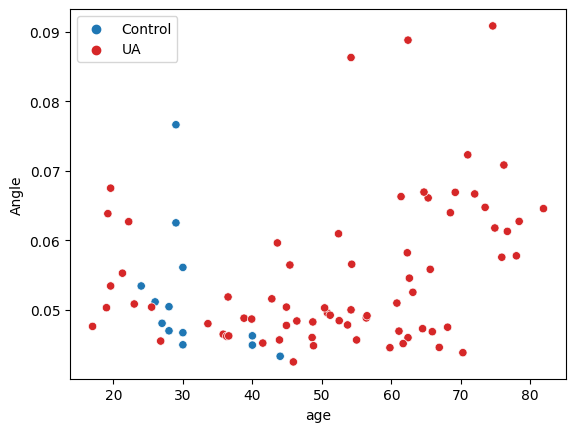

In [2243]:
blue = sns.color_palette()[0]
red=sns.color_palette()[3]
    
custom= {conditions[0]:blue, conditions[1]:red}

sns.scatterplot(data = art2_meta, x='age', y='Distance', hue= 'disease_state_init', palette=custom)
plt.ylabel('Angle')
plt.legend(loc='best')

In [11]:
# art2_meta['DuoAge'] = art2_meta['v5 disease_prob']+art2_meta['Distance']

# h_probs = art2_meta[art2_meta.healthy==0].DuoAge
# d_probs = art2_meta[art2_meta.healthy==1].DuoAge
# # Perform the Mann-Whitney U test
# statistic, p_value = mannwhitneyu(h_probs, d_probs)

# blue = sns.color_palette()[0]
# red=sns.color_palette()[3]

# custom= {conditions[0]:blue, conditions[1]:red}
# # Define the desired order of categories
# category_order = [conditions[0], conditions[1]]

# sns.boxplot(data = art2_meta, x='disease_state_init', y='DuoAge', order=category_order, palette=custom)

# # Add significance bar and p-value
# just = max(max(h_probs),max(d_probs))

# plt.plot([0, 1], [just + 0.025, just + 0.025], 'k-', lw=1.5)
# plt.text(0.5, just + 0.026, f'p = {p_value:.1g}', ha='center', fontsize=12)

# plt.ylabel('DuoAge')
# plt.xlabel(None)
# # plt.legend().remove()

Text(0.5, 0, '')

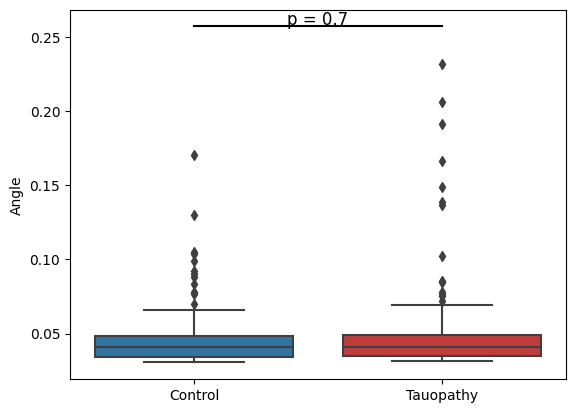

In [126]:
angles =[]
reduced=tau[overlap]
v1=y_bar[overlap]
l1 = np.linalg.norm(v1)

for i in range(len(tau_meta)):
    
    v2 = reduced.iloc[i]
    dot = np.dot(v1,v2, out=None)[0]   
    l2 = np.linalg.norm(v2)
    cos_angle= dot/ (l1 * l2)
    angle = np.arccos(cos_angle)
    
    angles += [angle]    
    
tau_meta['Distance'] = angles
conditions = ('Control','Tauopathy')
h_probs = tau_meta[tau_meta.healthy==0].Distance
d_probs = tau_meta[tau_meta.healthy==1].Distance
# Perform the Mann-Whitney U test
statistic, p_value = mannwhitneyu(h_probs, d_probs)

blue = sns.color_palette()[0]
red=sns.color_palette()[3]
    
custom= {conditions[0]:blue, conditions[1]:red}
# Define the desired order of categories
category_order = [conditions[0], conditions[1]]

sns.boxplot(data = tau_meta, x='simple_disease_state', y='Distance', order=category_order, palette=custom)

# Add significance bar and p-value
just = max(max(h_probs),max(d_probs))

plt.plot([0, 1], [just + 0.025, just + 0.025], 'k-', lw=1.5)
plt.text(0.5, just + 0.026, f'p = {p_value:.1g}', ha='center', fontsize=12)

plt.ylabel('Angle')
plt.xlabel(None)
# plt.legend().remove()

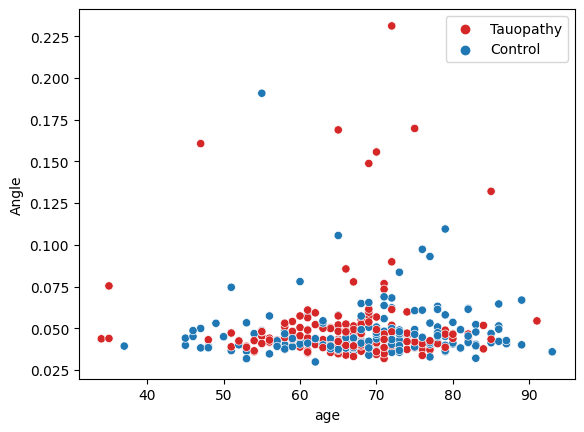

In [105]:
blue = sns.color_palette()[0]
red=sns.color_palette()[3]
    
custom= {conditions[0]:blue, conditions[1]:red}

sns.scatterplot(data = tau_meta, x='age', y='Distance', hue= 'simple_disease_state', palette=custom)
plt.ylabel('Angle')
plt.legend(loc='best')

In [97]:
noise = 0.5/(0.5-tau_meta['Distance'])

Text(0.5, 0, '')

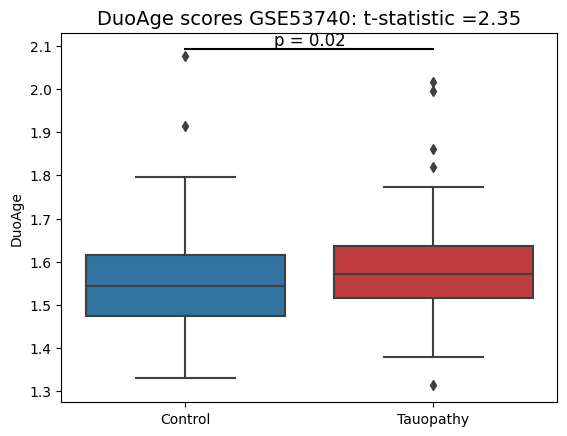

In [106]:
tau_meta['DuoAge'] = tau_meta['v6 disease_prob']+noise

conditions=['Control', 'Tauopathy']

h_scores = tau_meta[tau_meta.healthy==0].DuoAge
d_scores = tau_meta[tau_meta.healthy==1].DuoAge
# Perform the Mann-Whitney U test
# statistic, p_value = mannwhitneyu(h_scores, d_scores)
statistic, p_value = stats.ttest_ind(d_scores, h_scores, equal_var = False)

blue = sns.color_palette()[0]
red=sns.color_palette()[3]

custom= {conditions[0]:blue, conditions[1]:red}
# Define the desired order of categories
category_order = [conditions[0], conditions[1]]

sns.boxplot(data = tau_meta, x='simple_disease_state', y='DuoAge', order=category_order, palette=custom)

# Add significance bar and p-value
just = max(max(h_scores),max(d_scores))

plt.plot([0, 1], [just + 0.015, just + 0.015], 'k-', lw=1.5)
plt.text(0.5, just + 0.025, f'p = {p_value:.1g}', ha='center', fontsize=12)
plt.title('DuoAge scores {}: t-statistic ={:.2f}'.format(tau_meta.series_id[0],statistic, p_value),fontsize=14)
# Add significance bar and p-value

plt.ylabel('DuoAge')
plt.xlabel(None)
# plt.legend().remove()

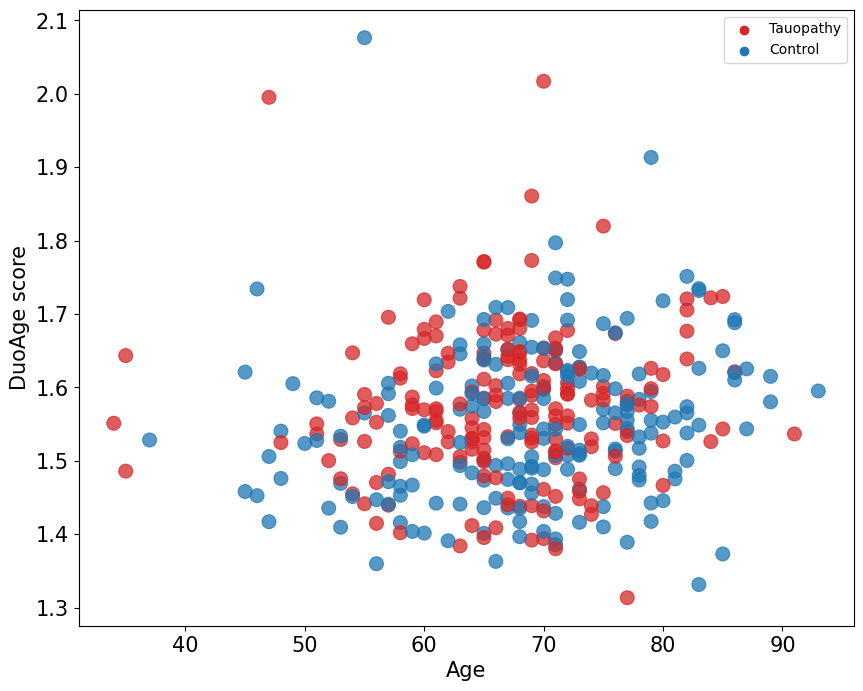

In [99]:
plt.figure(figsize=(10, 8)) 
blue = sns.color_palette()[0]
red=sns.color_palette()[3]
    
custom= {conditions[0]:blue, conditions[1]:red}

sns.scatterplot(data = tau_meta,x='age', y='DuoAge', hue= 'simple_disease_state', s=100, palette=custom,  alpha=0.75, edgecolor="Face")
plt.xlabel('Age',fontsize=15)
plt.ylabel('DuoAge score',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.legend(loc='best')

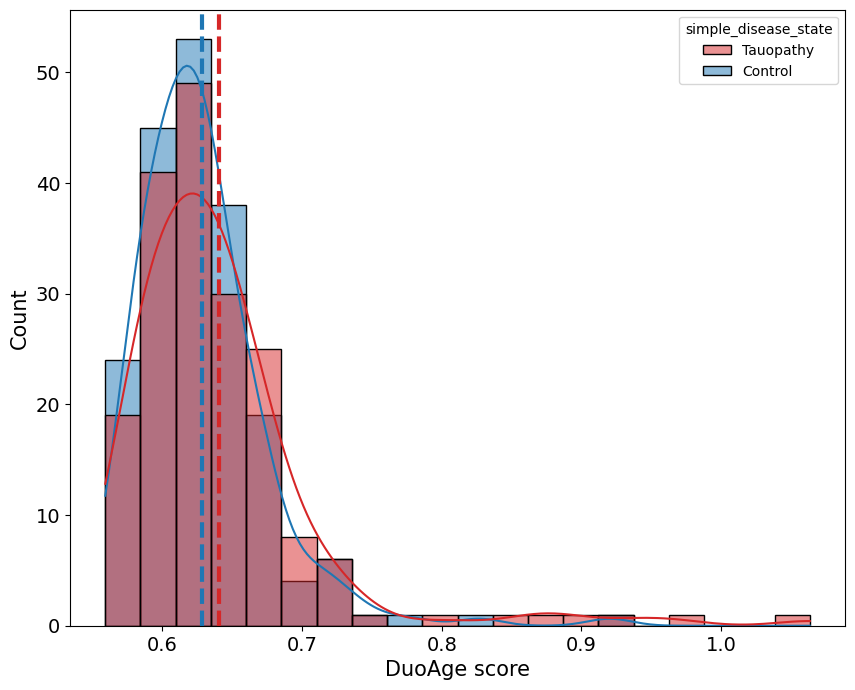

In [141]:
plt.figure(figsize=(10, 8)) 
custom_palette = {conditions[0]:blue, conditions[1]:red}
blue = sns.color_palette()[0]
red=sns.color_palette()[3]
    
# Define the desired order of categories
sns.histplot( data=tau_meta, x=tau_meta.DuoAge, kde=True, bins=20, hue='simple_disease_state', palette=custom_palette)

# Add vertical lines
plt.axvline(x=d_scores.mean(), color=red, linestyle='--',linewidth=3)
plt.axvline(x=h_scores.mean(), color=blue, linestyle='--',linewidth=3)

plt.xlabel('DuoAge score',fontsize=15)
plt.ylabel('Count',fontsize=15)

plt.xticks(fontsize=14);
plt.yticks(fontsize=14);

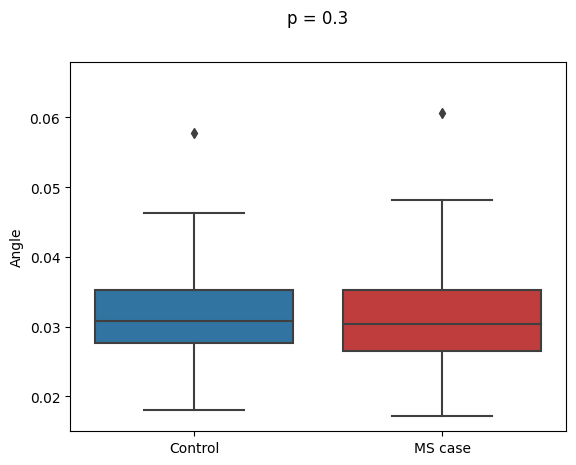

In [111]:
angles =[]
reduced=ms[overlap]
v1=y_bar[overlap]
l1 = np.linalg.norm(v1)

for i in range(len(ms_meta)):
    
    v2 = reduced.iloc[i]
    dot = np.dot(v1,v2, out=None)[0]   
    l2 = np.linalg.norm(v2)
    cos_angle= dot/ (l1 * l2)
    angle = np.arccos(cos_angle)
    
    angles += [angle]    
    
ms_meta['Distance'] = angles
conditions = ('Control','MS case')
h_score = ms_meta[ms_meta.healthy==0].Distance
d_score = ms_meta[ms_meta.healthy==1].Distance
# Perform the Mann-Whitney U test
statistic, p_value = mannwhitneyu(h_score, d_score)

blue = sns.color_palette()[0]
red=sns.color_palette()[3]
    
custom= {conditions[0]:blue, conditions[1]:red}
# Define the desired order of categories
category_order = [conditions[0], conditions[1]]

sns.boxplot(data = ms_meta, x='disease_state', y='Distance', order=category_order, palette=custom)

# Add significance bar and p-value
just = max(max(h_score),max(d_score))

plt.plot([0, 1], [just + 0.00005, just + 0.00005], 'k-', lw=1.5);
plt.text(0.5, just + 0.00006, f'p = {p_value:.1g}', ha='center', fontsize=12);

plt.ylabel('Angle');
plt.xlabel(None)
plt.ylim([0.015,0.068]);
# plt.legend().remove()

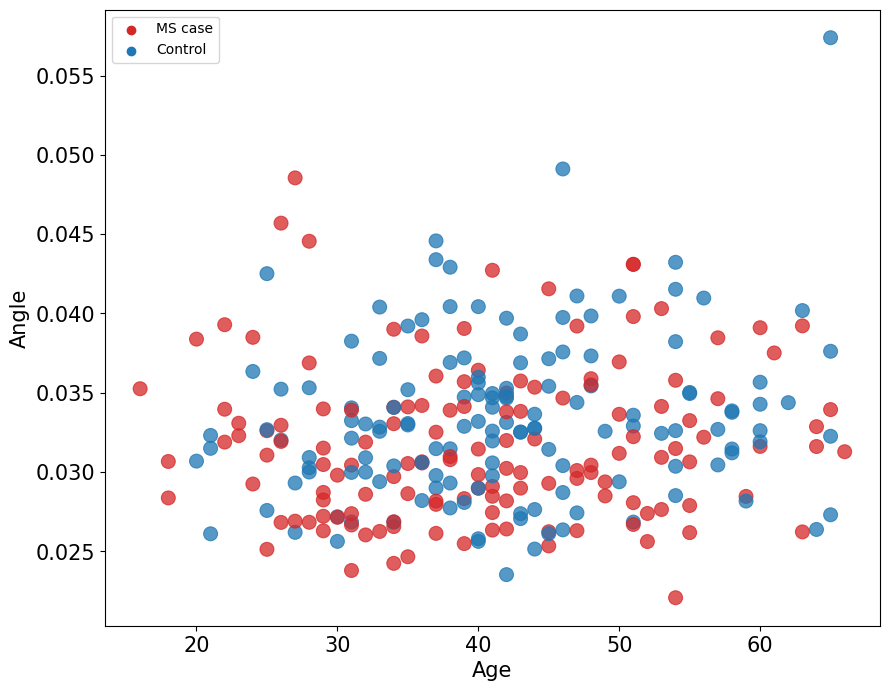

In [124]:
plt.figure(figsize=(10, 8)) 
blue = sns.color_palette()[0]
red=sns.color_palette()[3]
    
custom= {conditions[0]:blue, conditions[1]:red}

sns.scatterplot(data = ms_meta,x='age', y='Distance', hue= 'disease_state', s=100, palette=custom,  alpha=0.75, edgecolor="Face")
plt.xlabel('Age',fontsize=15)
plt.ylabel('Angle',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='best')

In [187]:
noise= 0.5/(0.5-ms_meta['Distance'])

Text(0.5, 0, '')

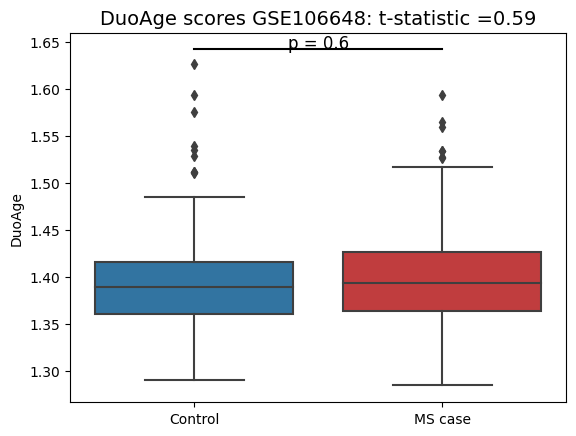

In [188]:
ms_meta['DuoAge'] = ms_meta['v6 disease_prob']+ noise

h_scores = ms_meta[ms_meta.healthy==0].DuoAge
d_scores = ms_meta[ms_meta.healthy==1].DuoAge
# Perform the Mann-Whitney U test
# statistic, p_value = mannwhitneyu(h_scores, d_scores)
statistic, p_value = stats.ttest_ind(d_scores, h_scores, equal_var=False)

blue = sns.color_palette()[0]
red=sns.color_palette()[3]

custom= {conditions[0]:blue, conditions[1]:red}
# Define the desired order of categories
category_order = [conditions[0], conditions[1]]

sns.boxplot(data = ms_meta, x='disease_state', y='DuoAge', order=category_order, palette=custom)

# Add significance bar and p-value
just = max(max(h_scores),max(d_scores))

plt.plot([0, 1], [just + 0.015, just + 0.015], 'k-', lw=1.5)
plt.text(0.5, just + 0.016, f'p = {p_value:.1g}', ha='center', fontsize=12)
plt.title('DuoAge scores {}: t-statistic ={:.2f}'.format(ms_meta.series_id[0],statistic, p_value),fontsize=14)
# Add significance bar and p-value

plt.ylabel('DuoAge')
plt.xlabel(None)
# plt.legend().remove()

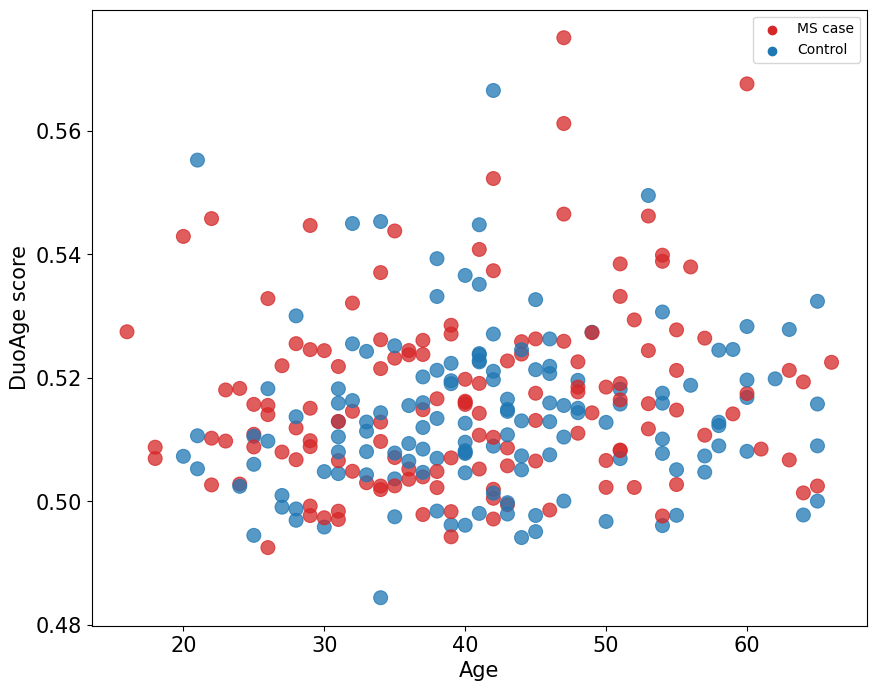

In [50]:
plt.figure(figsize=(10, 8)) 
blue = sns.color_palette()[0]
red=sns.color_palette()[3]
    
custom= {conditions[0]:blue, conditions[1]:red}

sns.scatterplot(data = ms_meta,x='age', y='DuoAge', hue= 'disease_state', s=100, palette=custom,  alpha=0.75, edgecolor="Face")
plt.xlabel('Age',fontsize=15)
plt.ylabel('DuoAge score',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='best')

(array([ 0.,  5., 10., 15., 20., 25.]),
 [Text(0, 0.0, '0'),
  Text(0, 5.0, '5'),
  Text(0, 10.0, '10'),
  Text(0, 15.0, '15'),
  Text(0, 20.0, '20'),
  Text(0, 25.0, '25')])

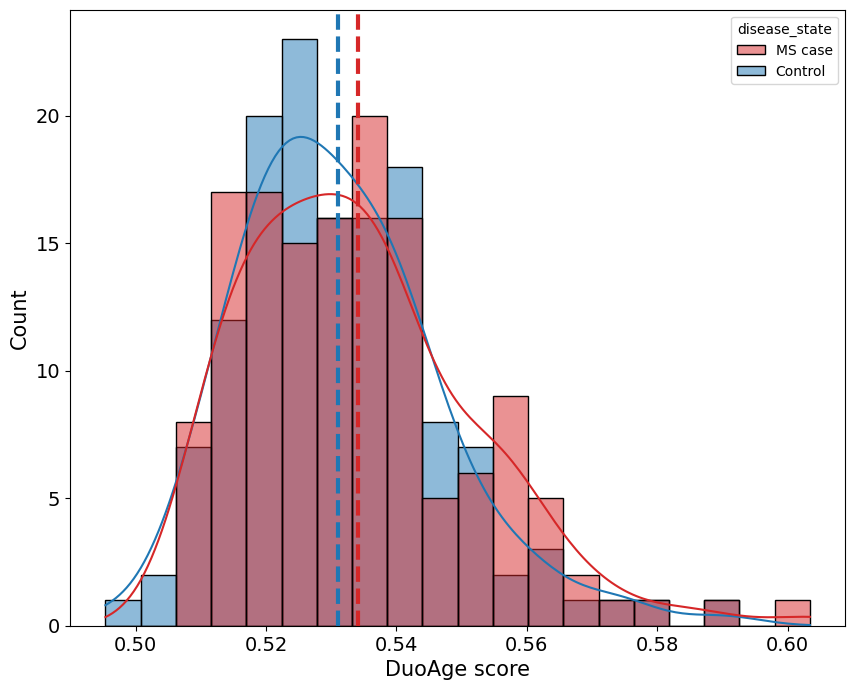

In [18]:
plt.figure(figsize=(10, 8)) 
custom_palette = {conditions[0]:blue, conditions[1]:red}
blue = sns.color_palette()[0]
red=sns.color_palette()[3]
    
# Define the desired order of categories
sns.histplot( data=ms_meta, x=ms_meta.DuoAge, kde=True, bins=20, hue='disease_state', palette=custom_palette)

# Add vertical lines
plt.axvline(x=d_scores.mean(), color=red, linestyle='--',linewidth=3)
plt.axvline(x=h_scores.mean(), color=blue, linestyle='--',linewidth=3)

plt.xlabel('DuoAge score',fontsize=15)
plt.ylabel('Count',fontsize=15)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

Text(0.5, 0, '')

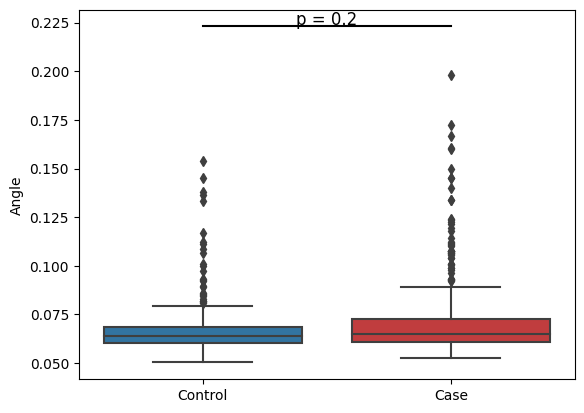

In [77]:
angles =[]
reduced=dep[overlap]
v1=y_bar[overlap]
l1 = np.linalg.norm(v1)

for i in range(len(dep_meta)):
    
    v2 = reduced.iloc[i]
    dot = np.dot(v1,v2, out=None)[0]   
    l2 = np.linalg.norm(v2)
    cos_angle= dot/ (l1 * l2)
    angle = np.arccos(cos_angle)
    
    angles += [angle]    
    
dep_meta['Distance'] = angles
conditions = ('Control','Case')
h_probs = dep_meta[dep_meta.healthy==0].Distance
d_probs = dep_meta[dep_meta.healthy==1].Distance
# Perform the Mann-Whitney U test
statistic, p_value = mannwhitneyu(h_probs, d_probs)
# statistic, p_value = stats.ttest_ind(d_probs, h_probs, equal_var=False)

blue = sns.color_palette()[0]
red=sns.color_palette()[3]
    
custom= {conditions[0]:blue, conditions[1]:red}
# Define the desired order of categories
category_order = [conditions[0], conditions[1]]

sns.boxplot(data = dep_meta, x='disease_state', y='Distance', order=category_order, palette=custom)

# Add significance bar and p-value
just = max(max(h_probs),max(d_probs))

plt.plot([0, 1], [just + 0.025, just + 0.025], 'k-', lw=1.5)
plt.text(0.5, just + 0.026, f'p = {p_value:.1g}', ha='center', fontsize=12)

plt.ylabel('Angle')
plt.xlabel(None)
# plt.legend().remove()

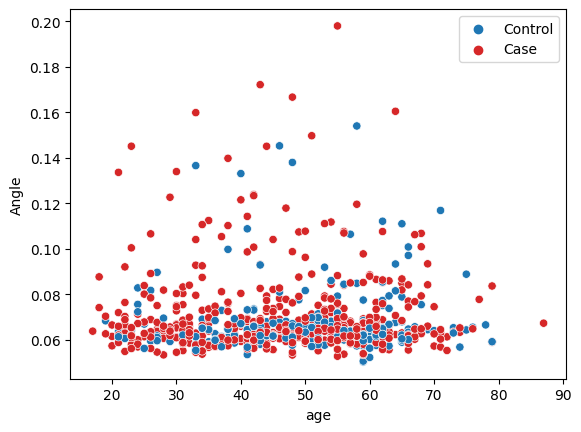

In [78]:
blue = sns.color_palette()[0]
red=sns.color_palette()[3]
    
custom= {conditions[0]:blue, conditions[1]:red}

sns.scatterplot(data = dep_meta, x='age', y='Distance', hue= 'disease_state', palette=custom)
plt.ylabel('Angle')
plt.legend(loc='best')

In [79]:
noise = 0.5/(0.5-dep_meta['Distance'])

Text(0.5, 0, '')

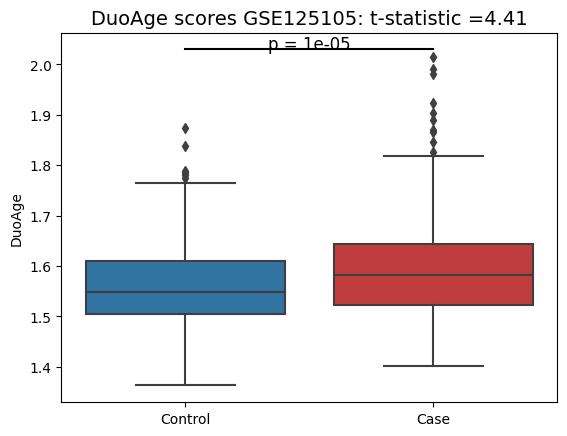

In [80]:
dep_meta['DuoAge'] = dep_meta['v6 disease_prob']+ noise

h_scores = dep_meta[dep_meta.healthy==0].DuoAge
d_scores = dep_meta[dep_meta.healthy==1].DuoAge
# Perform the Mann-Whitney U test
# statistic, p_value = mannwhitneyu(h_scores, d_scores)
t_statistic, p_value = stats.ttest_ind(d_scores, h_scores, equal_var=False)

blue = sns.color_palette()[0]
red=sns.color_palette()[3]

custom= {conditions[0]:blue, conditions[1]:red}
# Define the desired order of categories
category_order = [conditions[0], conditions[1]]

sns.boxplot(data = dep_meta, x='disease_state', y='DuoAge', order=category_order, palette=custom)

# Add significance bar and p-value
just = max(max(h_scores),max(d_scores))

plt.plot([0, 1], [just + 0.015, just + 0.015], 'k-', lw=1.5);
plt.text(0.5, just + 0.016, f'p = {p_value:.1g}', ha='center', fontsize=12);
plt.title('DuoAge scores {}: t-statistic ={:.2f}'.format(dep_meta.series_id[0],t_statistic, p_value),fontsize=14);
# Add significance bar and p-value

plt.ylabel('DuoAge')
plt.xlabel(None)
# plt.legend().remove()

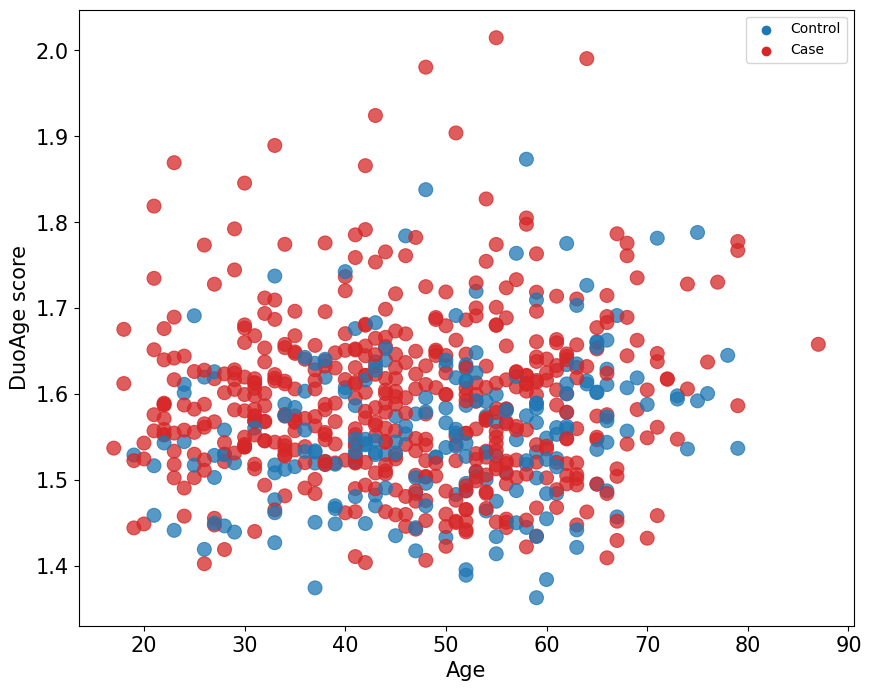

In [81]:
plt.figure(figsize=(10, 8)) 
blue = sns.color_palette()[0]
red=sns.color_palette()[3]
    
custom= {conditions[0]:blue, conditions[1]:red}

sns.scatterplot(data = dep_meta,x='age', y='DuoAge', hue= 'disease_state', s=100, palette=custom,  alpha=0.75, edgecolor="Face")
plt.xlabel('Age',fontsize=15)
plt.ylabel('DuoAge score',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='best')

(array([ 0., 10., 20., 30., 40., 50., 60., 70., 80.]),
 [Text(0, 0.0, '0'),
  Text(0, 10.0, '10'),
  Text(0, 20.0, '20'),
  Text(0, 30.0, '30'),
  Text(0, 40.0, '40'),
  Text(0, 50.0, '50'),
  Text(0, 60.0, '60'),
  Text(0, 70.0, '70'),
  Text(0, 80.0, '80')])

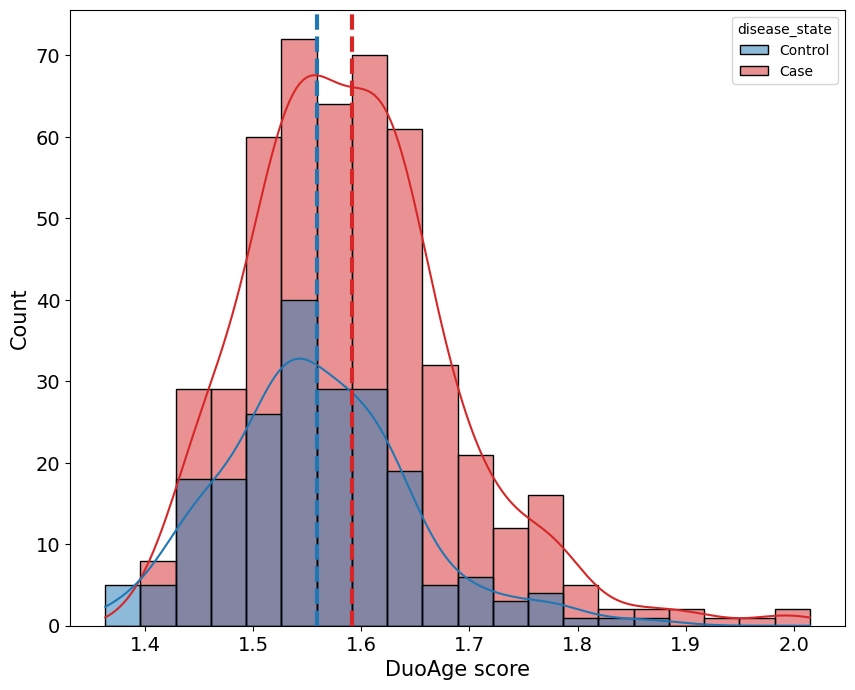

In [82]:
plt.figure(figsize=(10, 8)) 
custom_palette = {conditions[0]:blue, conditions[1]:red}
blue = sns.color_palette()[0]
red=sns.color_palette()[3]
    
# Define the desired order of categories
sns.histplot( data=dep_meta, x=dep_meta.DuoAge, kde=True, bins=20, hue='disease_state', palette=custom_palette)

# Add vertical lines
plt.axvline(x=d_scores.mean(), color=red, linestyle='--',linewidth=3)
plt.axvline(x=h_scores.mean(), color=blue, linestyle='--',linewidth=3)

plt.xlabel('DuoAge score',fontsize=15)
plt.ylabel('Count',fontsize=15)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

In [14]:
angles =[]
reduced=art[overlap]
v1=y_bar[overlap]
l1 = np.linalg.norm(v1)

for i in range(len(art_meta)):
    
    v2 = reduced.iloc[i]
    dot = np.dot(v1,v2, out=None)[0]   
    l2 = np.linalg.norm(v2)
    cos_angle= dot/ (l1 * l2)
    angle = np.arccos(cos_angle)
    
    angles += [angle]    
    
art_meta['Distance'] = angles
conditions = ('Normal','Rheumatoid arthritis')
h_probs = art_meta[art_meta.healthy==0].Distance
d_probs = art_meta[art_meta.healthy==1].Distance
# Perform the Mann-Whitney U test
statistic, p_value = mannwhitneyu(h_probs, d_probs)

blue = sns.color_palette()[0]
red=sns.color_palette()[3]
    
custom= {conditions[0]:blue, conditions[1]:red}
# Define the desired order of categories
category_order = [conditions[0], conditions[1]]

sns.boxplot(data = art_meta, x='disease_state', y='Distance', order=category_order, palette=custom)

# Add significance bar and p-value
just = max(max(h_probs),max(d_probs))

plt.plot([0, 1], [just + 0.025, just + 0.025], 'k-', lw=1.5)
plt.text(0.5, just + 0.026, f'p = {p_value:.1g}', ha='center', fontsize=12)

plt.ylabel('Angle')
plt.xlabel(None)
# plt.legend().remove()

NameError: name 'overlap' is not defined

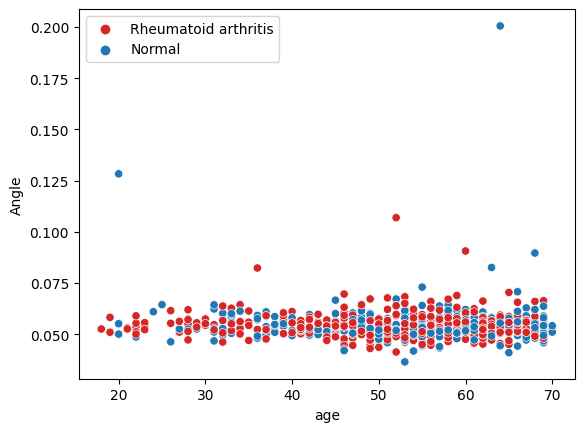

In [84]:
blue = sns.color_palette()[0]
red=sns.color_palette()[3]
    
custom= {conditions[0]:blue, conditions[1]:red}

sns.scatterplot(data = art_meta,x='age', y='Distance', hue= 'disease_state', palette=custom)
plt.ylabel('Angle')
plt.legend(loc='best')

In [85]:
noise=0.5/(0.5-art_meta['Distance'])

Text(0.5, 0, '')

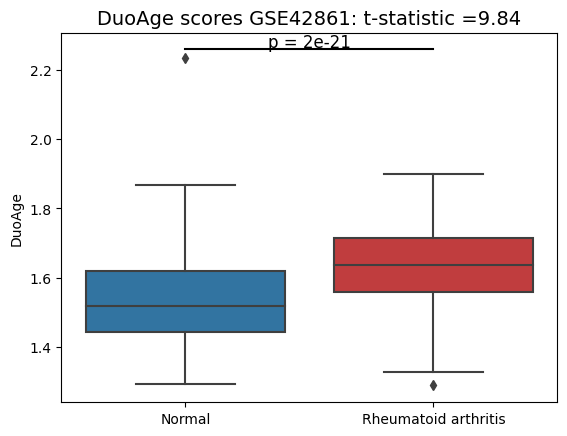

In [86]:
art_meta['DuoAge'] = art_meta['v6 disease_prob']+noise

h_scores = art_meta[art_meta.healthy==0].DuoAge
d_scores = art_meta[art_meta.healthy==1].DuoAge
# Perform the Mann-Whitney U test
# statistic, p_value = mannwhitneyu(h_probs, d_probs)
statistic, p_value = stats.ttest_ind(d_scores, h_scores, equal_var=False)


blue = sns.color_palette()[0]
red=sns.color_palette()[3]

custom= {conditions[0]:blue, conditions[1]:red}
# Define the desired order of categories
category_order = [conditions[0], conditions[1]]

sns.boxplot(data = art_meta, x='disease_state', y='DuoAge', order=category_order, palette=custom)

# Add significance bar and p-value
just = max(max(h_scores),max(d_scores))

plt.plot([0, 1], [just + 0.025, just + 0.025], 'k-', lw=1.5)
plt.text(0.5, just + 0.03, f'p = {p_value:.1g}', ha='center', fontsize=12)
plt.title('DuoAge scores {}: t-statistic ={:.2f}'.format(art_meta.series_id[0], statistic, p_value),fontsize=14);
plt.ylabel('DuoAge')
plt.xlabel(None)
# plt.legend().remove()

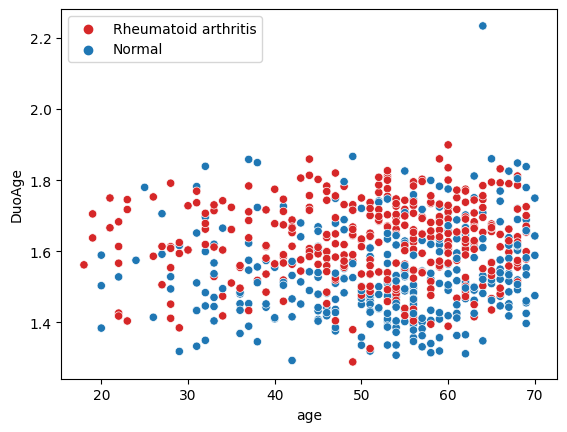

In [87]:
blue = sns.color_palette()[0]
red=sns.color_palette()[3]
    
custom= {conditions[0]:blue, conditions[1]:red}

sns.scatterplot(data = art_meta,x='age', y='DuoAge', hue= 'disease_state', palette=custom)
plt.ylabel('DuoAge')
plt.legend(loc='best')

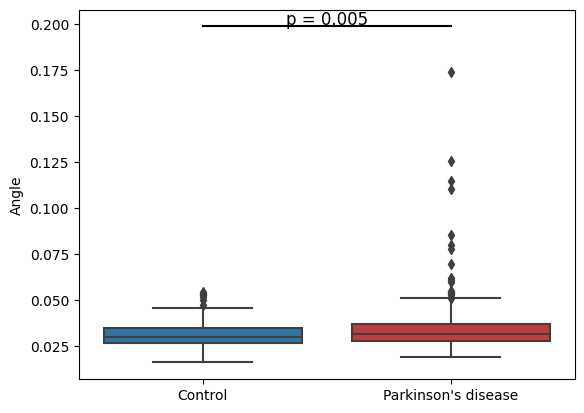

In [88]:
angles =[]
reduced=park[overlap]
v1=y_bar[overlap]
l1 = np.linalg.norm(v1)

for i in range(len(park_meta)):
    
    v2 = reduced.iloc[i]
    dot = np.dot(v1,v2, out=None)[0]   
    l2 = np.linalg.norm(v2)
    cos_angle= dot/(l1 * l2)
    angle = np.arccos(cos_angle)
    
    angles += [angle]    
    
park_meta['Distance'] = angles
conditions = ('Control','Parkinson\'s disease')
h_probs = park_meta[park_meta.healthy==0].Distance
d_probs = park_meta[park_meta.healthy==1].Distance
# Perform the Mann-Whitney U test
statistic, p_value = mannwhitneyu(h_probs, d_probs)

blue = sns.color_palette()[0]
red=sns.color_palette()[3]
    
custom= {conditions[0]:blue, conditions[1]:red}
# Define the desired order of categories
category_order = [conditions[0], conditions[1]]

sns.boxplot(data = park_meta, x='disease_state', y='Distance', order=category_order, palette=custom)

# Add significance bar and p-value
just = max(max(h_probs),max(d_probs))

plt.plot([0, 1], [just + 0.025, just + 0.025], 'k-', lw=1.5);
plt.text(0.5, just + 0.026, f'p = {p_value:.1g}', ha='center', fontsize=12);

plt.ylabel('Angle');
plt.xlabel(None);
# plt.legend().remove()

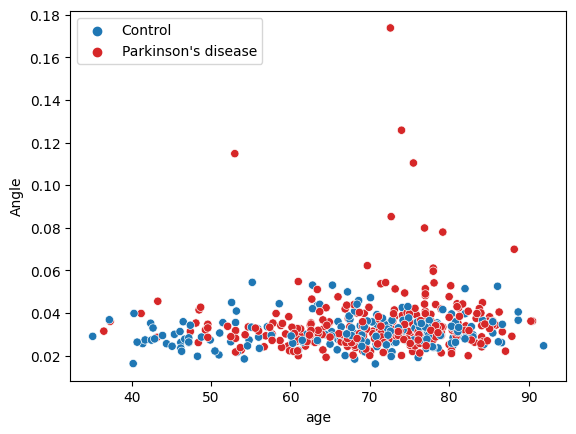

In [89]:
blue = sns.color_palette()[0]
red=sns.color_palette()[3]
    
custom= {conditions[0]:blue, conditions[1]:red}

sns.scatterplot(data = park_meta,x='age', y='Distance', hue= 'disease_state', palette=custom)
plt.ylabel('Angle')
plt.legend(loc='best')

In [90]:
noise = 0.5/(0.5-park_meta['Distance'])

Text(0.5, 0, '')

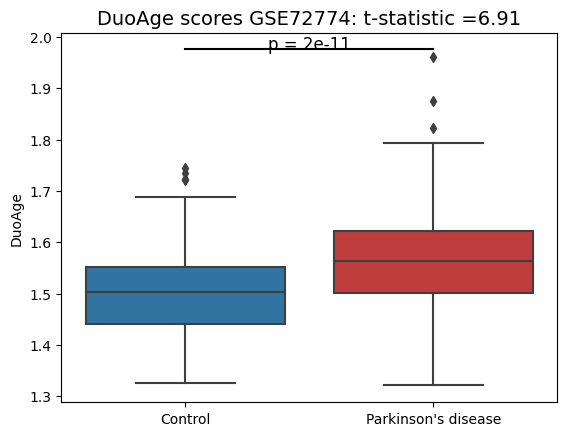

In [91]:
park_meta['DuoAge'] = park_meta['v6 disease_prob']+noise

h_scores = park_meta[park_meta.healthy==0].DuoAge
d_scores = park_meta[park_meta.healthy==1].DuoAge
# Perform the Mann-Whitney U test
# statistic, p_value = mannwhitneyu(h_scores, d_scores)
statistic, p_value = stats.ttest_ind(d_scores, h_scores, equal_var=False)

blue = sns.color_palette()[0]
red=sns.color_palette()[3]

custom= {conditions[0]:blue, conditions[1]:red}
# Define the desired order of categories
category_order = [conditions[0], conditions[1]]

sns.boxplot(data = park_meta, x='disease_state', y='DuoAge', order=category_order, palette=custom)

# Add significance bar and p-value
just = max(max(h_scores),max(d_scores))

plt.plot([0, 1], [just + 0.015, just + 0.015], 'k-', lw=1.5)
plt.text(0.5, just + 0.016, f'p = {p_value:.1g}', ha='center', fontsize=12)
plt.title('DuoAge scores {}: t-statistic ={:.2f}'.format(park_meta.series_id[0],statistic, p_value),fontsize=14)
# Add significance bar and p-value

plt.ylabel('DuoAge')
plt.xlabel(None)
# plt.legend().remove()

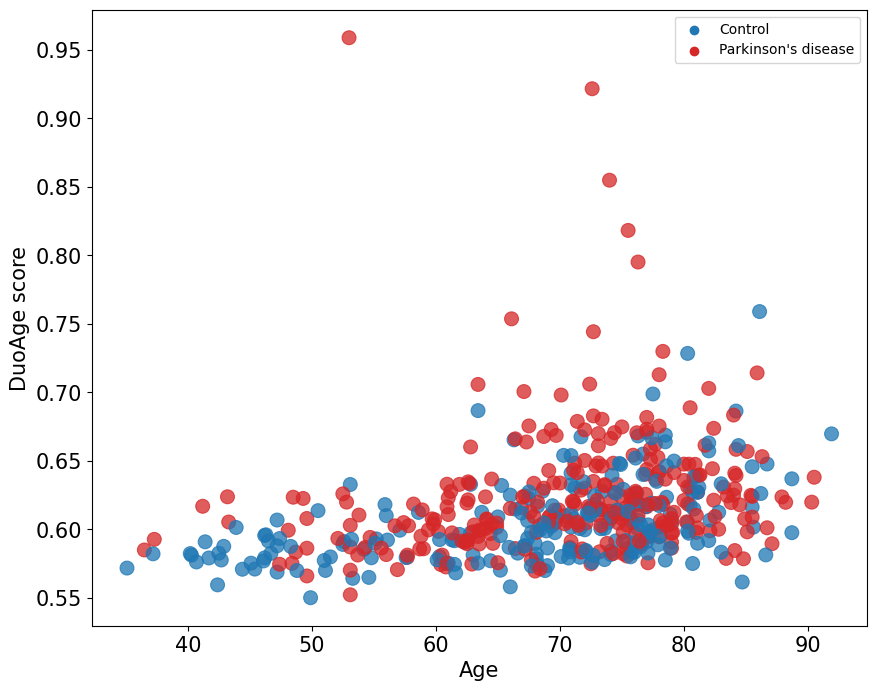

In [151]:
plt.figure(figsize=(10, 8)) 
blue = sns.color_palette()[0]
red=sns.color_palette()[3]
    
custom= {conditions[0]:blue, conditions[1]:red}

sns.scatterplot(data = park_meta,x='age', y='DuoAge', hue= 'disease_state', s=100, palette=custom,  alpha=0.75, edgecolor="Face")
plt.xlabel('Age',fontsize=15)
plt.ylabel('DuoAge score',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='best')

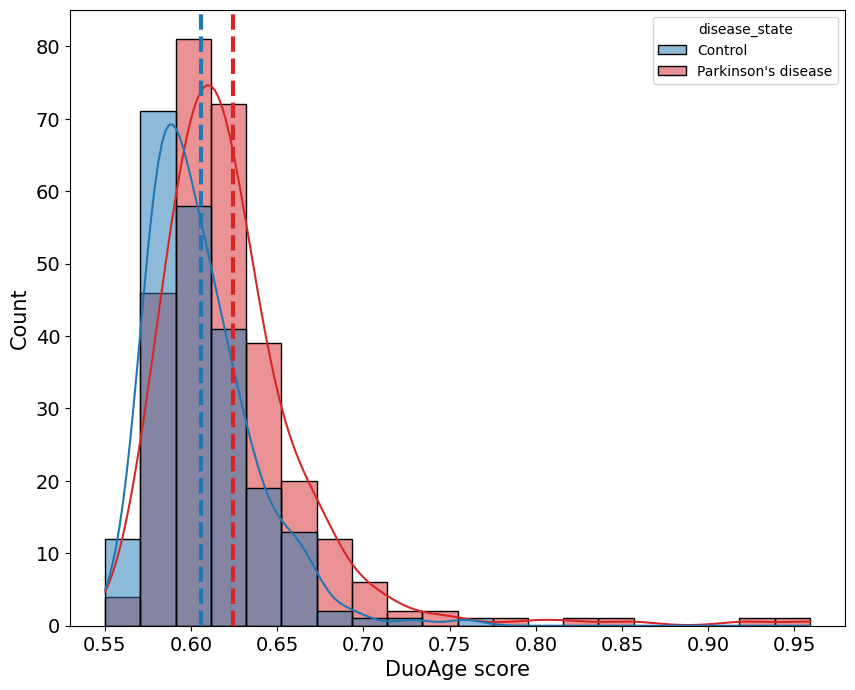

In [152]:
plt.figure(figsize=(10, 8)) 
custom_palette = {conditions[0]:blue, conditions[1]:red}
blue = sns.color_palette()[0]
red=sns.color_palette()[3]
    
# Define the desired order of categories
sns.histplot( data=park_meta, x=park_meta.DuoAge, kde=True, bins=20, hue='disease_state', palette=custom_palette)

# Add vertical lines
plt.axvline(x=d_scores.mean(), color=red, linestyle='--',linewidth=3)
plt.axvline(x=h_scores.mean(), color=blue, linestyle='--',linewidth=3)

plt.xlabel('DuoAge score',fontsize=15);
plt.ylabel('Count',fontsize=15);

plt.xticks(fontsize=14);
plt.yticks(fontsize=14);

# PCA on raw and corrected beta values and on noise transformation 

### Obesity and diabetes

In [812]:
obs = pd.read_csv('Datasets/Obesity and Diabetes/Obesity.csv')
obs_meta = pd.read_excel('Datasets/Obesity and Diabetes/Obesity_pmeta.xlsx')

In [813]:
obs = obs.T

In [816]:
obs=obs.iloc[1:,:]

In [826]:
del obs, obs_meta

In [17]:
obs = obs.iloc[1:,:]

In [18]:
obs = obs.sort_index(axis=1)

In [33]:
obs.loc[obs.index[0]].values.shape

(456279,)

In [46]:
rv=obs.iloc[0]

In [49]:
# Reshape the row to a 2D array before calculating the covariance matrix
rv= rv.to_numpy().reshape(1, -1)

In [175]:
pca = PCA()

In [176]:
reduced_features = pca.fit_transform(obs)

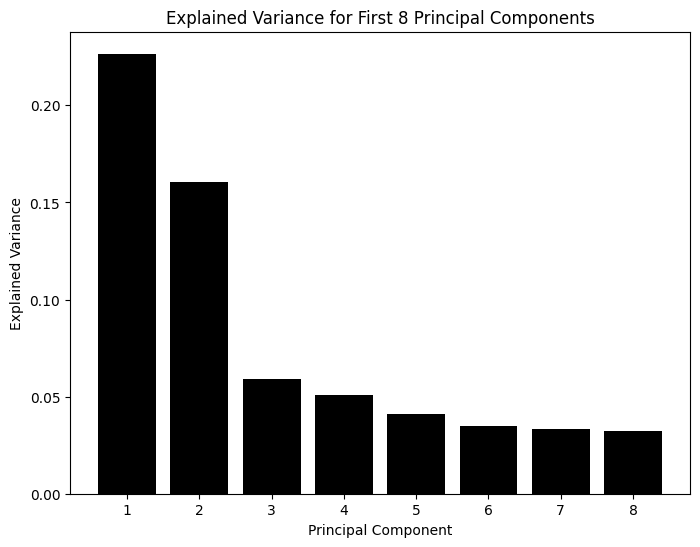

In [177]:
# Get the explained variances for the first 8 principal components
explained_variances = pca.explained_variance_ratio_[:8]

# Plot the explained variances for the first 8 principal components
plt.figure(figsize=(8, 6))
plt.bar(range(1, len(explained_variances) + 1), explained_variances, color='k')
plt.title('Explained Variance for First 8 Principal Components')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance')
plt.show()

In [189]:
component1 = reduced_features[:,2]
component2 = reduced_features[:,3]

In [190]:
pcs = pd.DataFrame({'PC1':component1, 'PC2':component2, 'Health': obs_meta['characteristics_ch1.1.subject status']})

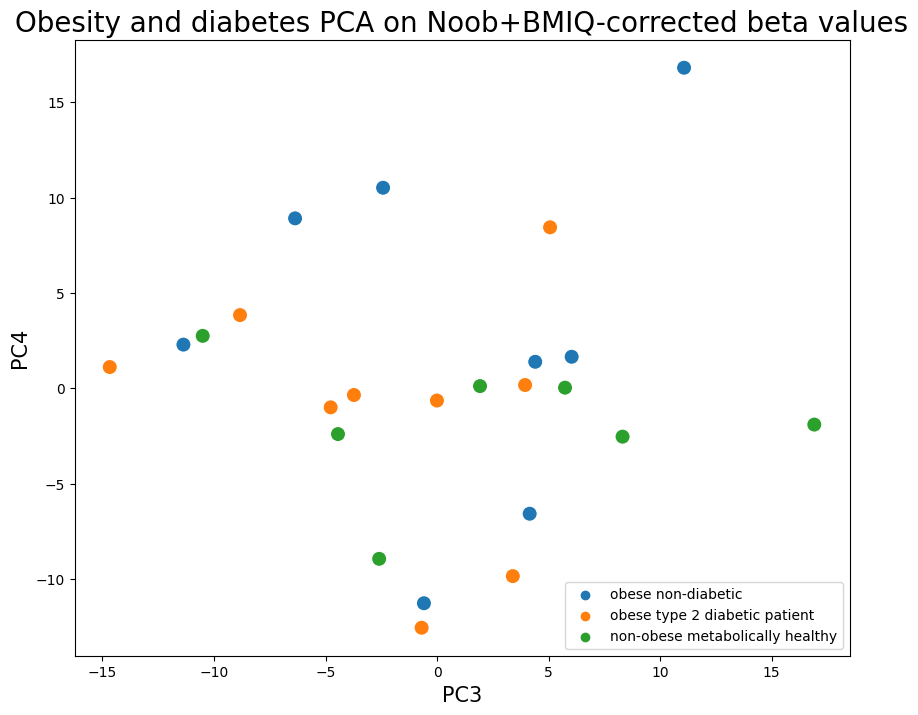

In [191]:
plt.figure(figsize=(10, 8)) 
# Create a scatter plot of the transformed data
sns.scatterplot(pcs, x='PC1',y='PC2',hue='Health', s=120)
plt.xlabel('PC3',fontsize=15)
plt.ylabel('PC4',fontsize=15)
plt.title('Obesity and diabetes PCA on Noob+BMIQ-corrected beta values',fontsize=20)
plt.legend(loc='lower right')
# plt.savefig('DuoAge/Normalization/Unnormalized_pca.png',dpi=300)

In [195]:
obs.reset_index(inplace=True, drop=True)

In [198]:
obs_healthy= obs[obs_meta.healthy == 0]

In [200]:
#Produces a dataframe with only the healthy samples and the CpGs which are most tightly regulated

# Calculate the standard deviation of each column
std_dev = obs_healthy.std()

# Select columns where the standard deviation is less than 0.02
selected_columns = obs_healthy.columns[std_dev < 0.02]

# Create a new DataFrame containing only the selected columns
filtered_healthy = obs_healthy[selected_columns]

In [201]:
filtered_healthy.shape

(7, 215748)

In [202]:
#produces a dataframe of all samples but with only the CpGs which are tightly regulated in healthy subjects
regulated = obs[filtered_healthy.columns.tolist()]

In [203]:
regulated.shape

(24, 215748)

In [204]:
#get the means of the regulated CpGs from only the healthy samples
means = filtered_healthy.mean()

#create a dataframe of ALL samples which have the means from the healthy samples subtracted from all samples
noisy = regulated-means

In [205]:
noisy.shape

(24, 215748)

In [206]:
reduced_features = pca.fit_transform(noisy)

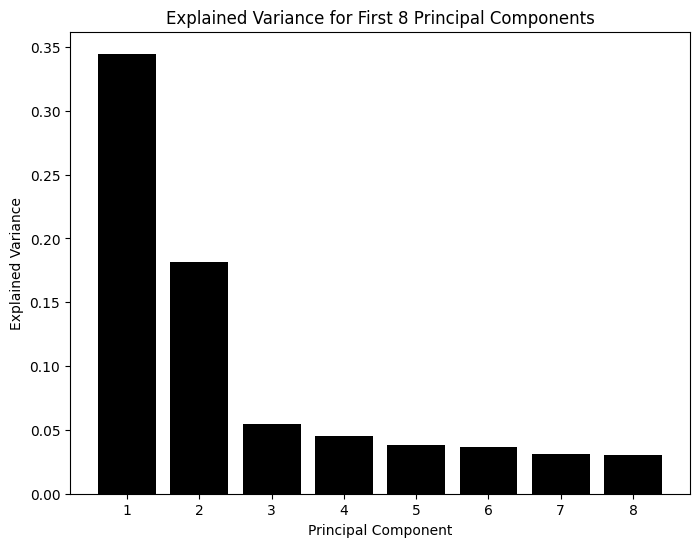

In [207]:
# Get the explained variances for the first 8 principal components
explained_variances = pca.explained_variance_ratio_[:8]

# Plot the explained variances for the first 8 principal components
plt.figure(figsize=(8, 6))
plt.bar(range(1, len(explained_variances) + 1), explained_variances, color='k')
plt.title('Explained Variance for First 8 Principal Components')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance')
plt.show()

In [214]:
component1 = reduced_features[:,2]
component2 = reduced_features[:,3]

In [215]:
pcs = pd.DataFrame({'PC1':component1, 'PC2':component2, 'Health': obs_meta['characteristics_ch1.1.subject status']})

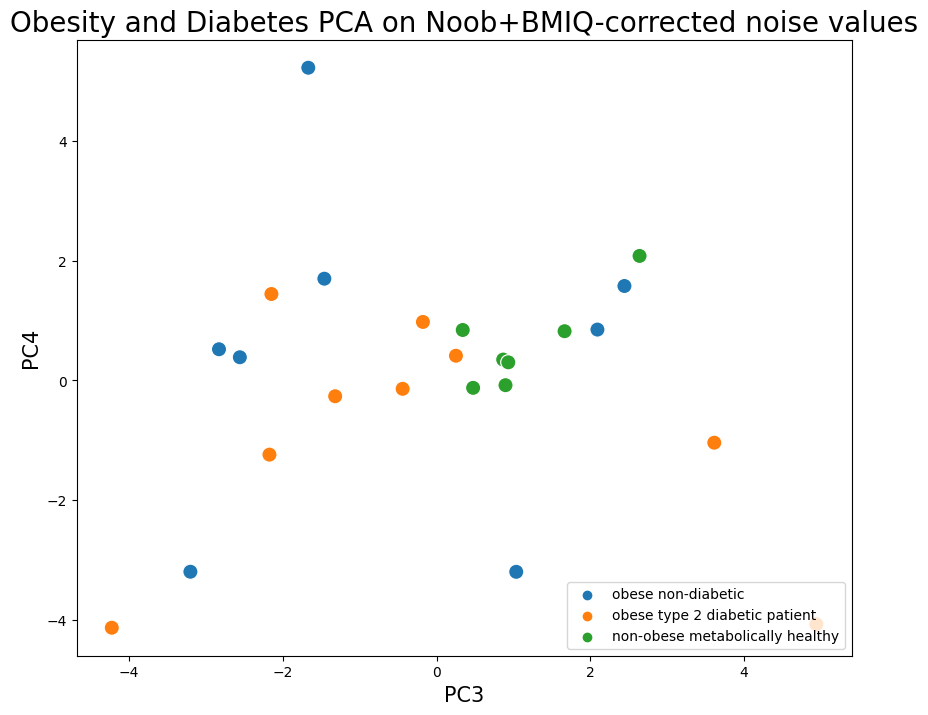

In [216]:
plt.figure(figsize=(10, 8)) 
# Create a scatter plot of the transformed data
sns.scatterplot(pcs, x='PC1',y='PC2',hue='Health', alpha=1, s=120)
plt.xlabel('PC3',fontsize=15)
plt.ylabel('PC4',fontsize=15)
plt.title('Obesity and Diabetes PCA on Noob+BMIQ-corrected noise values',fontsize=20)
plt.legend(loc='lower right')
# plt.savefig('DuoAge/Normalization/Unnormalized_pca.png',dpi=300)

### Subclinical atherosclerosis

In [21]:
pesa = np.load('Datasets/PESA/PESA.npy', allow_pickle=True)
pesa_meta = pd.read_excel('Datasets/PESA/PESA_pmeta.xlsx')

In [22]:
cgs=list_reader('Datasets/PESA/cgs.txt')

In [24]:
df = pd.DataFrame(pesa, columns=cgs)

In [25]:
pca = PCA()

In [26]:
reduced_features = pca.fit_transform(pesa)

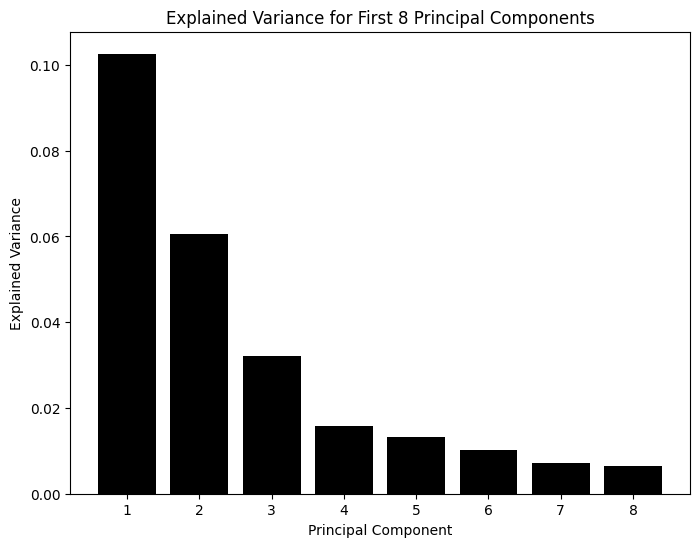

In [27]:
# Get the explained variances for the first 8 principal components
explained_variances = pca.explained_variance_ratio_[:8]

# Plot the explained variances for the first 8 principal components
plt.figure(figsize=(8, 6))
plt.bar(range(1, len(explained_variances) + 1), explained_variances, color='k')
plt.title('Explained Variance for First 8 Principal Components')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance')
plt.show()

In [55]:
component1 = reduced_features[:,2]
component2 = reduced_features[:,3]

In [56]:
pcs = pd.DataFrame({'PC1':component1, 'PC2':component2, 'Age': pesa_meta.age, 'Health': pesa_meta.disease_state})

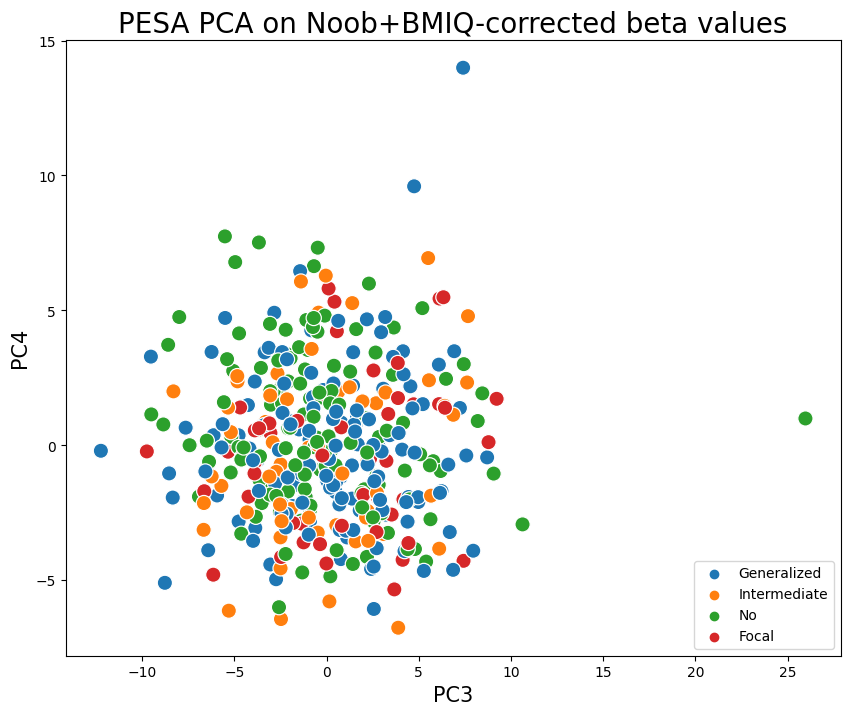

In [57]:
plt.figure(figsize=(10, 8)) 
# Create a scatter plot of the transformed data
sns.scatterplot(pcs, x='PC1',y='PC2',hue='Health', s=120)
plt.xlabel('PC3',fontsize=15)
plt.ylabel('PC4',fontsize=15)
plt.title('PESA PCA on Noob+BMIQ-corrected beta values',fontsize=20)
plt.legend(loc='lower right')
# plt.savefig('DuoAge/Normalization/Unnormalized_pca.png',dpi=300)

In [59]:
pesa_healthy= df[pesa_meta.disease_state == 'No']

In [60]:
#Produces a dataframe with only the healthy samples and the CpGs which are most tightly regulated

# Calculate the standard deviation of each column
std_dev = pesa_healthy.std()

# Select columns where the standard deviation is less than 0.02
selected_columns = pesa_healthy.columns[std_dev < 0.02]

# Create a new DataFrame containing only the selected columns
filtered_healthy = pesa_healthy[selected_columns]

In [61]:
filtered_healthy.shape

(136, 213040)

In [62]:
#produces a dataframe of all samples but with only the CpGs which are tightly regulated in healthy subjects
regulated = df[filtered_healthy.columns.tolist()]

In [63]:
regulated.shape

(391, 213040)

In [64]:
#get the means of the regulated CpGs from only the healthy samples
means = filtered_healthy.mean()

#create a dataframe of ALL samples which have the means from the healthy samples subtracted from all samples
noisy = regulated-means

In [65]:
noisy.shape

(391, 213040)

In [66]:
reduced_features = pca.fit_transform(noisy)

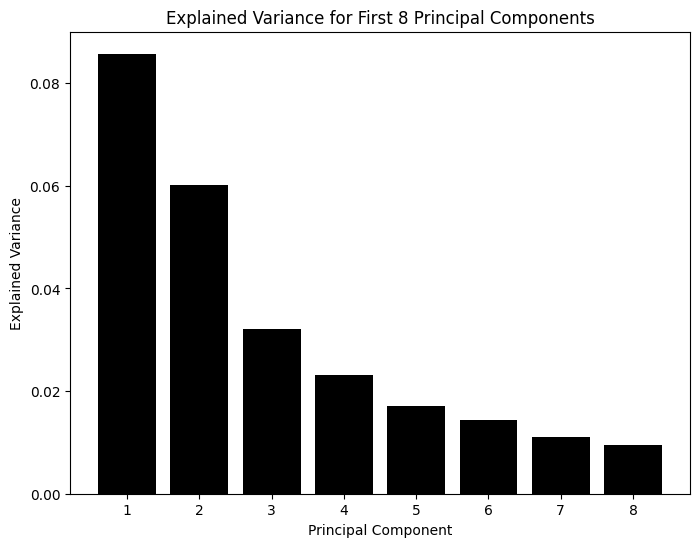

In [67]:
# Get the explained variances for the first 8 principal components
explained_variances = pca.explained_variance_ratio_[:8]

# Plot the explained variances for the first 8 principal components
plt.figure(figsize=(8, 6))
plt.bar(range(1, len(explained_variances) + 1), explained_variances, color='k')
plt.title('Explained Variance for First 8 Principal Components')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance')
plt.show()

In [92]:
component1 = reduced_features[:,0]
component2 = reduced_features[:,1]

In [93]:
pcs = pd.DataFrame({'PC1':component1, 'PC2':component2, 'Age': pesa_meta.age, 'Health': pesa_meta.disease_state})

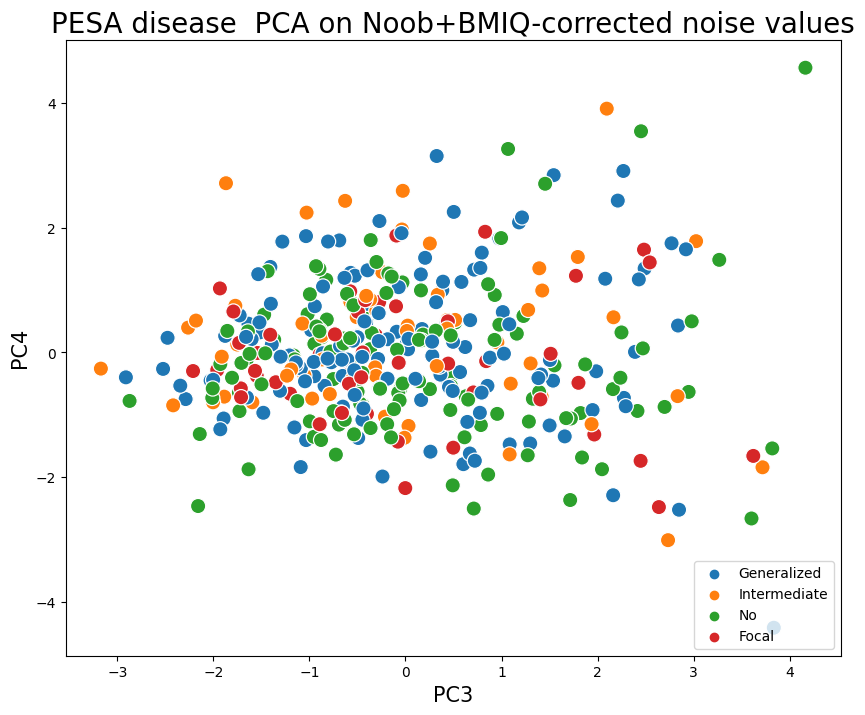

In [95]:
plt.figure(figsize=(10, 8)) 
# Create a scatter plot of the transformed data
sns.scatterplot(pcs, x='PC1',y='PC2',hue='Health', alpha=1, s=120)
plt.xlabel('PC3',fontsize=15)
plt.ylabel('PC4',fontsize=15)
plt.title('PESA disease  PCA on Noob+BMIQ-corrected noise values',fontsize=20)
plt.legend(loc='lower right')
# plt.savefig('DuoAge/Normalization/Unnormalized_pca.png',dpi=300)

### Depression

In [96]:
dep = pd.read_csv('Datasets/Depression/Depression.csv')
dep_meta = pd.read_excel('Datasets/Depression/Depression_pmeta.xlsx')

In [98]:
dep = dep.T

In [100]:
dep.columns = dep.iloc[0,:]

In [102]:
dep = dep.iloc[1:,:]

In [105]:
dep=dep.reset_index(drop=True)

In [106]:
dep=dep.sort_index(axis=1)

In [108]:
list_writer(dep.columns.tolist(), 'Datasets/Depression/cgs.txt')

In [109]:
np.save('Datasets/Depression/Depression.npy',dep.values)

In [110]:
pca = PCA()

In [111]:
reduced_features = pca.fit_transform(dep)

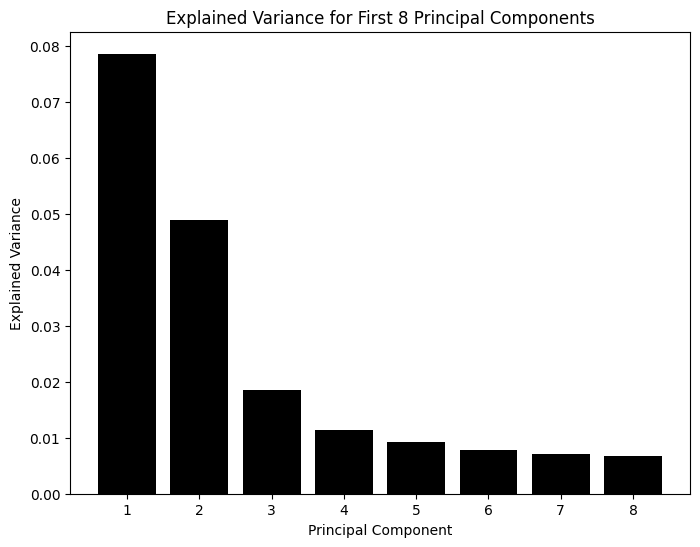

In [112]:
# Get the explained variances for the first 8 principal components
explained_variances = pca.explained_variance_ratio_[:8]

# Plot the explained variances for the first 8 principal components
plt.figure(figsize=(8, 6))
plt.bar(range(1, len(explained_variances) + 1), explained_variances, color='k')
plt.title('Explained Variance for First 8 Principal Components')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance')
plt.show()

In [131]:
component1 = reduced_features[:,2]
component2 = reduced_features[:,3]

In [132]:
pcs = pd.DataFrame({'PC1':component1, 'PC2':component2, 'Gender': dep_meta.gendeer,'Age': dep_meta.age, 'Health': dep_meta.disease_state})

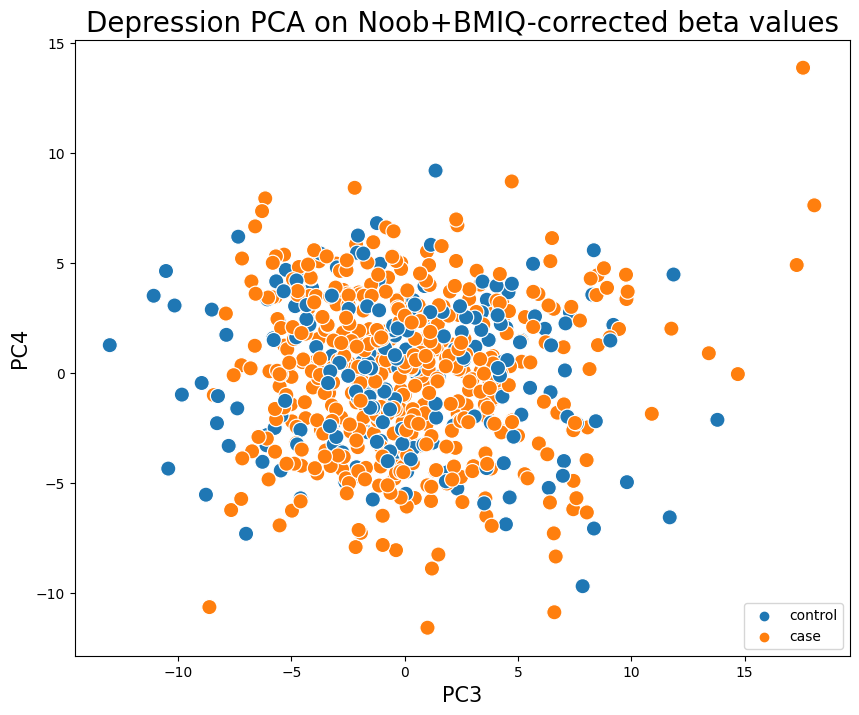

In [133]:
plt.figure(figsize=(10, 8)) 
# Create a scatter plot of the transformed data
sns.scatterplot(pcs, x='PC1',y='PC2',hue='Health', s=120)
plt.xlabel('PC3',fontsize=15)
plt.ylabel('PC4',fontsize=15)
plt.title('Depression PCA on Noob+BMIQ-corrected beta values',fontsize=20)
plt.legend(loc='lower right')
# plt.savefig('DuoAge/Normalization/Unnormalized_pca.png',dpi=300)

In [138]:
dep_healthy= dep[dep_meta.disease_state == 'control']

In [142]:
dep_healthy.shape

(210, 334309)

In [140]:
#Produces a dataframe with only the healthy samples and the CpGs which are most tightly regulated

# Calculate the standard deviation of each column
std_dev = dep_healthy.std()

# Select columns where the standard deviation is less than 0.02
selected_columns = dep_healthy.columns[std_dev < 0.02]

# Create a new DataFrame containing only the selected columns
filtered_healthy = dep_healthy[selected_columns]

In [141]:
#produces a dataframe of all samples but with only the CpGs which are tightly regulated in healthy subjects
regulated = dep[filtered_healthy.columns.tolist()]

In [143]:
regulated.shape

(699, 125771)

In [144]:
#get the means of the regulated CpGs from only the healthy samples
means = filtered_healthy.mean()

#create a dataframe of ALL samples which have the means from the healthy samples subtracted from all samples
noisy = regulated-means

In [145]:
noisy.shape

(699, 125771)

In [146]:
reduced_features = pca.fit_transform(noisy)

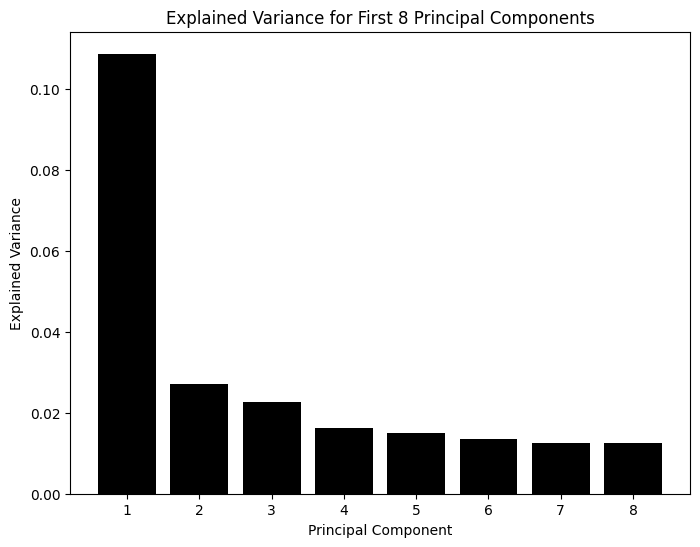

In [147]:
# Get the explained variances for the first 8 principal components
explained_variances = pca.explained_variance_ratio_[:8]

# Plot the explained variances for the first 8 principal components
plt.figure(figsize=(8, 6))
plt.bar(range(1, len(explained_variances) + 1), explained_variances, color='k')
plt.title('Explained Variance for First 8 Principal Components')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance')
plt.show()

In [155]:
component1 = reduced_features[:,2]
component2 = reduced_features[:,3]

In [156]:
pcs = pd.DataFrame({'PC1':component1, 'PC2':component2, 'Gender':dep_meta.gendeer,'Age': dep_meta.age, 'Health': dep_meta.disease_state})

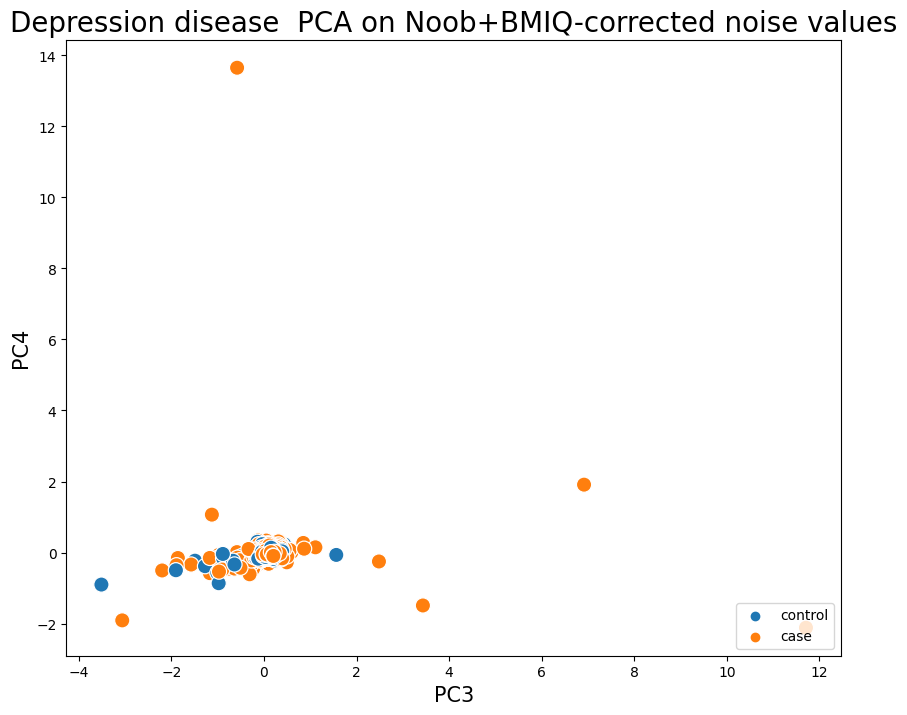

In [157]:
plt.figure(figsize=(10, 8)) 
# Create a scatter plot of the transformed data
sns.scatterplot(pcs, x='PC1',y='PC2',hue='Health', alpha=1, s=120)
plt.xlabel('PC3',fontsize=15)
plt.ylabel('PC4',fontsize=15)
plt.title('Depression disease  PCA on Noob+BMIQ-corrected noise values',fontsize=20)
plt.legend(loc='lower right')
# plt.savefig('DuoAge/Normalization/Unnormalized_pca.png',dpi=300)

### Parkinsons

In [4]:
park = np.load('Datasets/Parkinsons Vallerga/Parkinsons.npy', allow_pickle=True)
park_meta = pd.read_excel('Datasets/Parkinsons Vallerga/Parkinsons_Vallerga_pmeta.xlsx')

In [5]:
cgs=list_reader('Datasets/Parkinsons Vallerga/cgs.txt')

In [6]:
df = pd.DataFrame(park, columns=cgs)

In [7]:
pca = PCA()

In [8]:
reduced_features = pca.fit_transform(park)

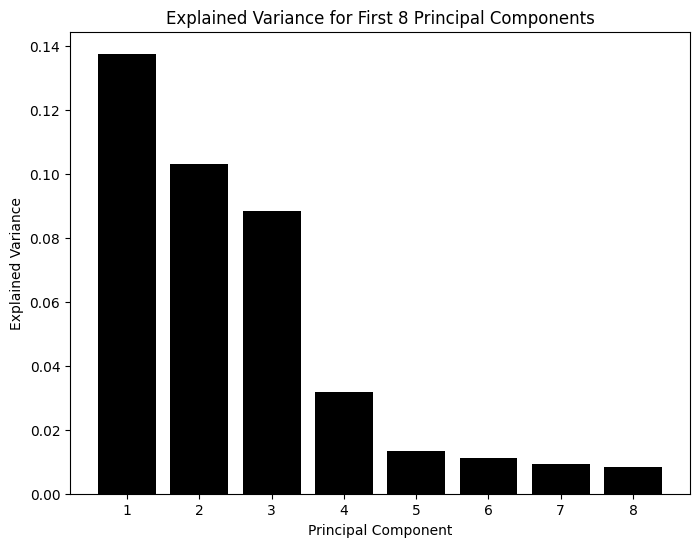

In [9]:
# Get the explained variances for the first 8 principal components
explained_variances = pca.explained_variance_ratio_[:8]

# Plot the explained variances for the first 8 principal components
plt.figure(figsize=(8, 6))
plt.bar(range(1, len(explained_variances) + 1), explained_variances, color='k')
plt.title('Explained Variance for First 8 Principal Components')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance')
plt.show()

In [22]:
component1 = reduced_features[:,8]
component2 = reduced_features[:,9]

In [23]:
pcs = pd.DataFrame({'PC1':component1, 'PC2':component2, 'Gender':park_meta.gender,'Age': park_meta.age, 'Health': park_meta.disease_state})

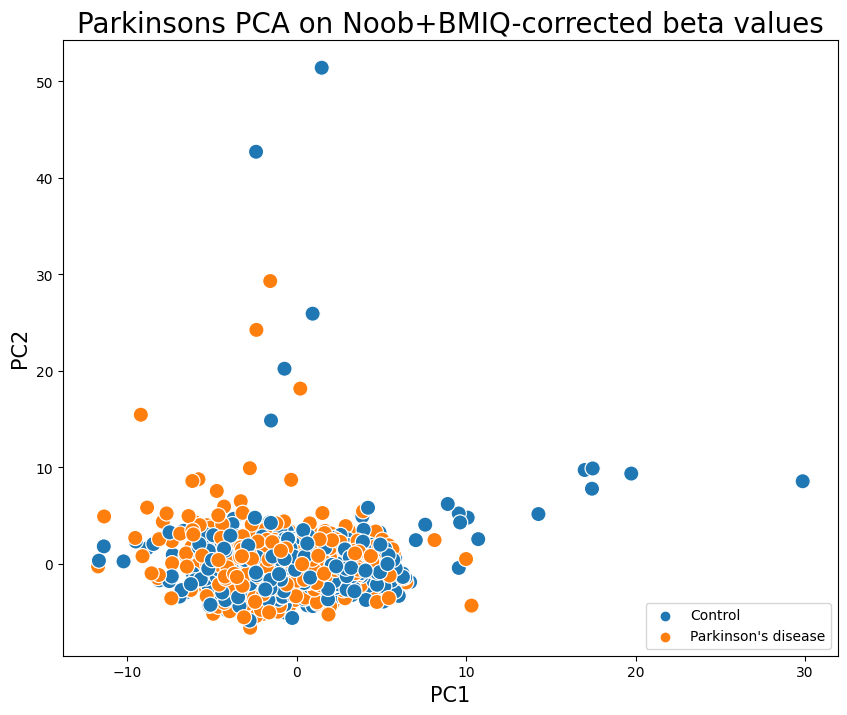

In [24]:
plt.figure(figsize=(10, 8)) 
# Create a scatter plot of the transformed data
sns.scatterplot(pcs, x='PC1',y='PC2',hue='Health', s=120)
plt.xlabel('PC1',fontsize=15)
plt.ylabel('PC2',fontsize=15)
plt.title('Parkinsons PCA on Noob+BMIQ-corrected beta values',fontsize=20)
plt.legend(loc='lower right')

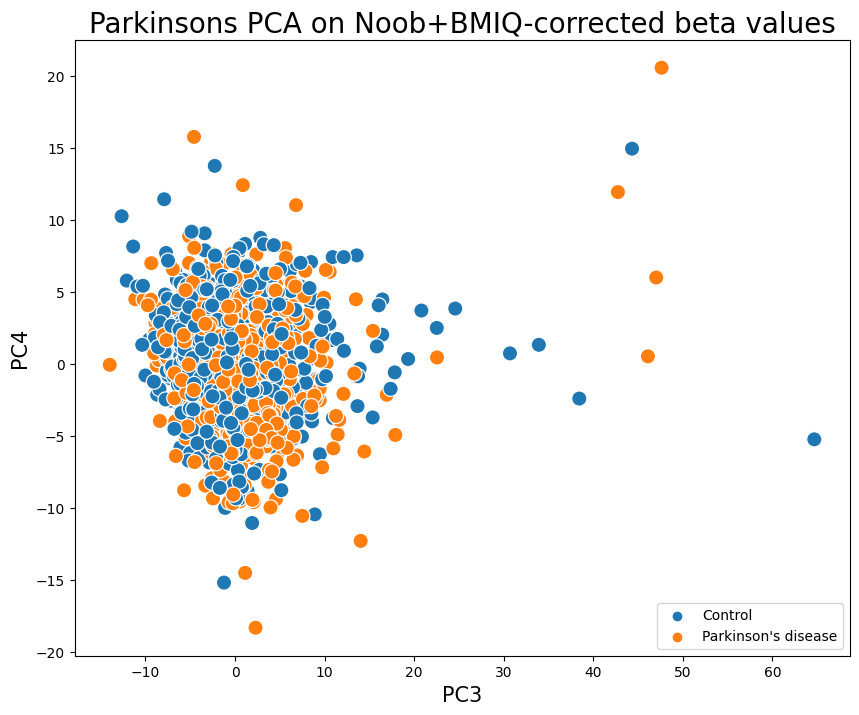

In [77]:
plt.figure(figsize=(10, 8)) 
# Create a scatter plot of the transformed data
sns.scatterplot(pcs, x='PC1',y='PC2',hue='Health', s=120)
plt.xlabel('PC1',fontsize=15)
plt.ylabel('PC2',fontsize=15)
plt.title('Parkinsons PCA on Noob+BMIQ-corrected beta values',fontsize=20)
plt.legend(loc='lower right')
# plt.savefig('DuoAge/Normalization/Unnormalized_pca.png',dpi=300)

In [38]:
park_meta

REF_ID      age  gender smoking_status        disease_state  \
0     GSM4315405  unknown    Male        unknown              Control   
1     GSM4315406  unknown    Male        unknown              Control   
2     GSM4315407  unknown    Male        unknown  Parkinson's disease   
3     GSM4315408  unknown    Male        unknown              Control   
4     GSM4315409  unknown  Female        unknown              Control   
...          ...      ...     ...            ...                  ...   
1884  GSM4317289  unknown    Male        unknown              Control   
1885  GSM4317290  unknown  Female        unknown              Control   
1886  GSM4317291  unknown    Male        unknown  Parkinson's disease   
1887  GSM4317292  unknown  Female        unknown              Control   
1888  GSM4317293  unknown  Female        unknown  Parkinson's disease   

      healthy  series_id  
0           0  GSE145361  
1           0  GSE145361  
2           1  GSE145361  
3           0  GSE145361  
4           0  GSE145361  
...       ...        ...  
1884        0  GSE145361  
1885        0  GSE145361  
1886        1  GSE145361  
1887        0  GSE145361  
1888        1  GSE145361  

[1889 rows x 7 columns]

In [25]:
park_healthy= df[park_meta.disease_state == 'Control']

In [26]:
#Produces a dataframe with only the healthy samples and the CpGs which are most tightly regulated

# Calculate the standard deviation of each column
std_dev = park_healthy.std()

# Select columns where the standard deviation is less than 0.02
selected_columns = park_healthy.columns[std_dev < 0.02]

# Create a new DataFrame containing only the selected columns
filtered_healthy = park_healthy[selected_columns]

In [27]:
filtered_healthy.shape

(930, 168892)

In [28]:
#produces a dataframe of all samples but with only the CpGs which are tightly regulated in healthy subjects
regulated = df[filtered_healthy.columns.tolist()]

In [29]:
regulated.shape

(1889, 168892)

In [30]:
#get the means of the regulated CpGs from only the healthy samples
means = filtered_healthy.mean()

#create a dataframe of ALL samples which have the means from the healthy samples subtracted from all samples
noisy = regulated-means

In [31]:
noisy.shape

(1889, 168892)

In [32]:
reduced_features = pca.fit_transform(noisy)

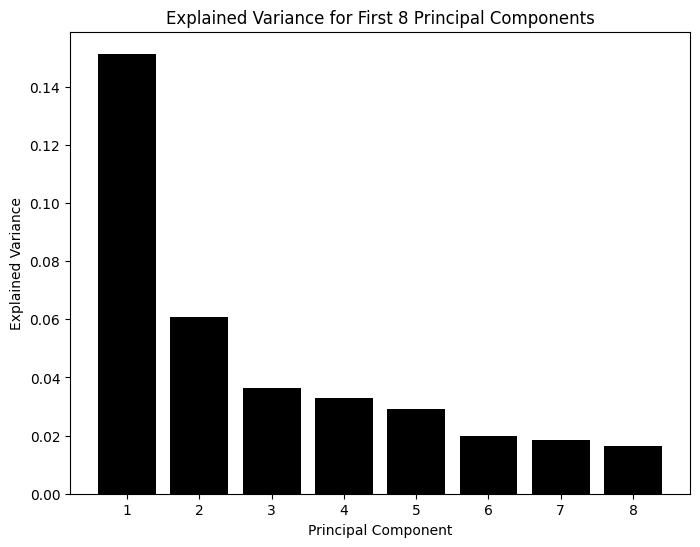

In [33]:
# Get the explained variances for the first 8 principal components
explained_variances = pca.explained_variance_ratio_[:8]

# Plot the explained variances for the first 8 principal components
plt.figure(figsize=(8, 6))
plt.bar(range(1, len(explained_variances) + 1), explained_variances, color='k')
plt.title('Explained Variance for First 8 Principal Components')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance')
plt.show()

In [49]:
component1 = reduced_features[:,7]
component2 = reduced_features[:,8]

In [50]:
pcs = pd.DataFrame({'PC1':component1, 'PC2':component2, 'Gender':park_meta.gender,'Age': park_meta.age, 'Health': park_meta.disease_state})

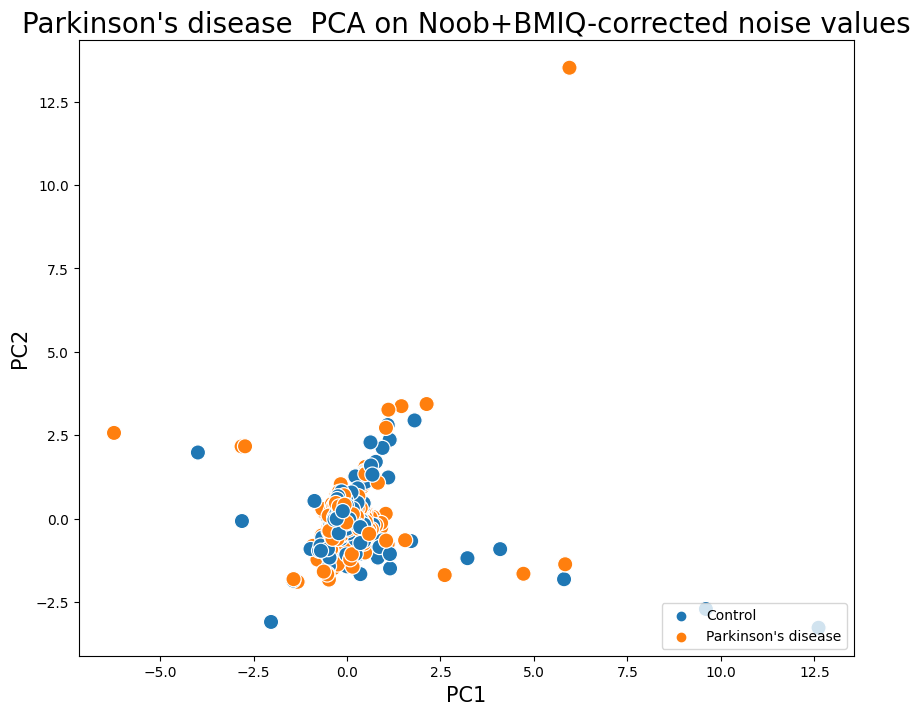

In [51]:
plt.figure(figsize=(10, 8)) 
# Create a scatter plot of the transformed data
sns.scatterplot(pcs, x='PC1',y='PC2',hue='Health', alpha=1, s=120)
plt.xlabel('PC1',fontsize=15)
plt.ylabel('PC2',fontsize=15)
plt.title('Parkinson\'s disease  PCA on Noob+BMIQ-corrected noise values',fontsize=20)
plt.legend(loc='lower right')
# plt.savefig('DuoAge/Normalization/Unnormalized_pca.png',dpi=300)

### Pagets

In [48]:
pag = np.load('Datasets/Pagets/Pagets.npy', allow_pickle=True)
pag_meta = pd.read_excel('Datasets/Pagets/Pagets_pmeta.xlsx')

FileNotFoundError: [Errno 2] No such file or directory: 'Datasets/Pagets/Pagets.npy'

In [ ]:
cgs=list_reader('Datasets/Pagets/cgs.txt')

In [7]:
df = pd.DataFrame(pag, columns=cgs)

In [8]:
pca = PCA()

In [9]:
reduced_features = pca.fit_transform(pag)

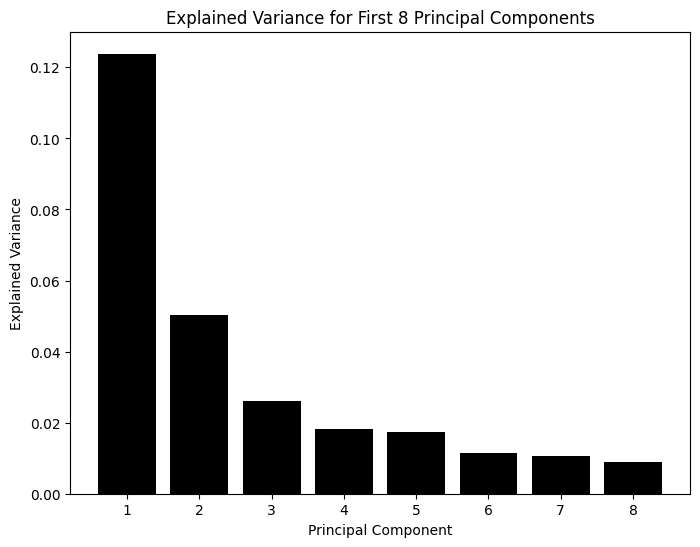

In [10]:
# Get the explained variances for the first 8 principal components
explained_variances = pca.explained_variance_ratio_[:8]

# Plot the explained variances for the first 8 principal components
plt.figure(figsize=(8, 6))
plt.bar(range(1, len(explained_variances) + 1), explained_variances, color='k')
plt.title('Explained Variance for First 8 Principal Components')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance')
plt.show()

In [33]:
component1 = reduced_features[:,3]
component2 = reduced_features[:,4]

In [34]:
pcs = pd.DataFrame({'PC1':component1, 'PC2':component2, 'Gender':pag_meta.gender,'Age': pag_meta.age, 'Health': pag_meta.disease_state})

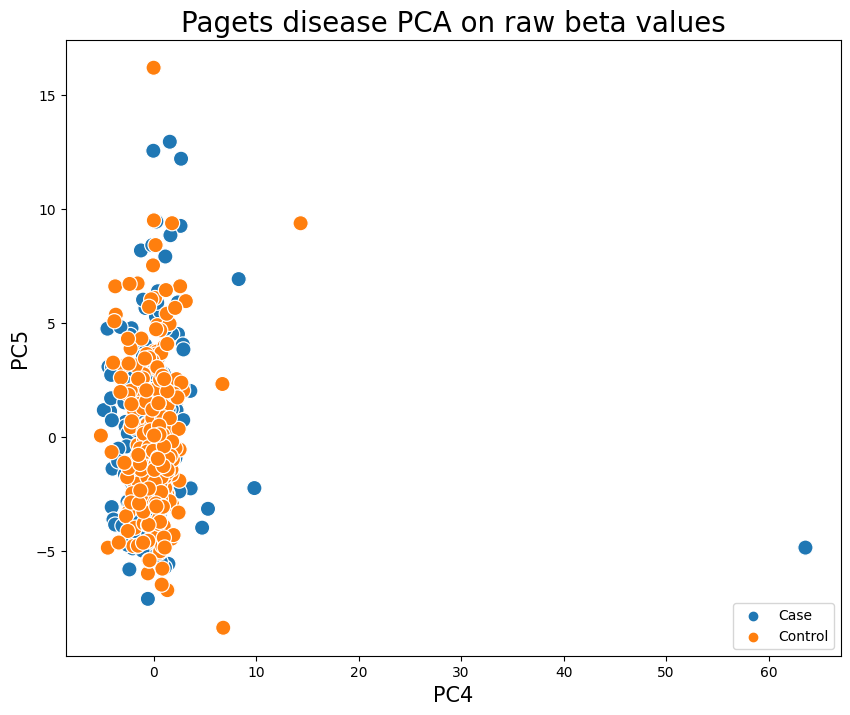

In [35]:
plt.figure(figsize=(10, 8)) 
# Create a scatter plot of the transformed data
sns.scatterplot(pcs, x='PC1',y='PC2',hue='Health', s=120)
plt.xlabel('PC4',fontsize=15)
plt.ylabel('PC5',fontsize=15)
plt.title('Pagets disease PCA on raw beta values',fontsize=20)
plt.legend(loc='lower right')
# plt.savefig('DuoAge/Normalization/Unnormalized_pca.png',dpi=300)

In [40]:
pag_healthy= df[pag_meta.disease_state == 'Control']

In [70]:
#Produces a dataframe with only the healthy samples and the CpGs which are most tightly regulated

# Calculate the standard deviation of each column
std_dev = pag_healthy.std()

# Select columns where the standard deviation is less than 0.02
selected_columns = pag_healthy.columns[std_dev < 0.03]

# Create a new DataFrame containing only the selected columns
filtered_healthy = pag_healthy[selected_columns]

In [71]:
filtered_healthy.shape

(260, 214999)

In [72]:
#produces a dataframe of all samples but with only the CpGs which are tightly regulated in healthy subjects
regulated = df[filtered_healthy.columns.tolist()]

In [73]:
#get the means of the regulated CpGs from only the healthy samples
means = filtered_healthy.mean()

#create a dataframe of ALL samples which have the means from the healthy samples subtracted from all samples
noisy = regulated-means

In [74]:
noisy.shape

(492, 214999)

In [75]:
reduced_features = pca.fit_transform(noisy)

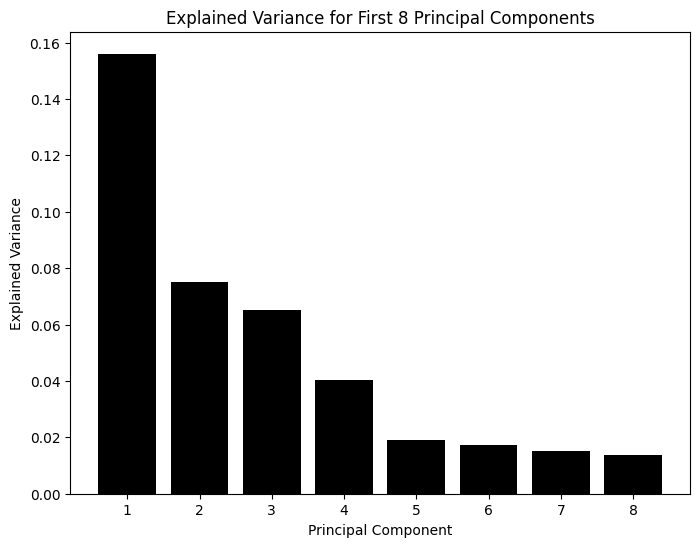

In [76]:
# Get the explained variances for the first 8 principal components
explained_variances = pca.explained_variance_ratio_[:8]

# Plot the explained variances for the first 8 principal components
plt.figure(figsize=(8, 6))
plt.bar(range(1, len(explained_variances) + 1), explained_variances, color='k')
plt.title('Explained Variance for First 8 Principal Components')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance')
plt.show()

In [77]:
component1 = reduced_features[:,0]
component2 = reduced_features[:,1]

In [78]:
pcs = pd.DataFrame({'PC1':component1, 'PC2':component2, 'Gender':pag_meta.gender,'Age': pag_meta.age, 'Health': pag_meta.disease_state})

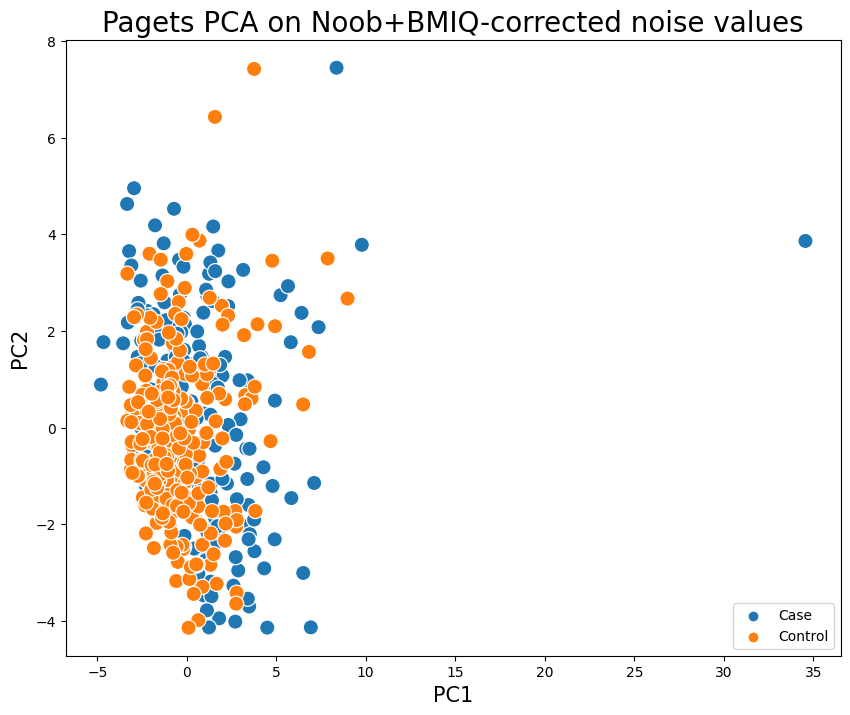

In [79]:
plt.figure(figsize=(10, 8)) 
# Create a scatter plot of the transformed data
sns.scatterplot(pcs, x='PC1',y='PC2',hue='Health', alpha=1, s=120)
plt.xlabel('PC1',fontsize=15)
plt.ylabel('PC2',fontsize=15)
plt.title('Pagets PCA on Noob+BMIQ-corrected noise values',fontsize=20)
plt.legend(loc='lower right')
# plt.savefig('DuoAge/Normalization/Unnormalized_pca.png',dpi=300)

### Arthritis

In [4]:
art = np.load('Datasets/Arthritis/Arthritis_raw.npy', allow_pickle=True)
art_meta = pd.read_excel('Datasets/Arthritis/Arthritis_pmeta.xlsx')
cgs=list_reader('Datasets/Arthritis/cgs.txt')
df = pd.DataFrame(art, columns=cgs)

In [6]:
pca = PCA()

In [7]:
reduced_features = pca.fit_transform(art)

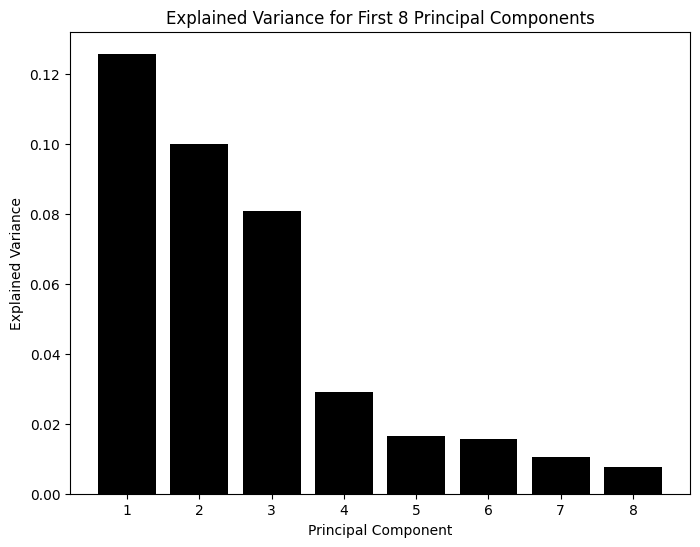

In [8]:
# Get the explained variances for the first 8 principal components
explained_variances = pca.explained_variance_ratio_[:8]

# Plot the explained variances for the first 8 principal components
plt.figure(figsize=(8, 6))
plt.bar(range(1, len(explained_variances) + 1), explained_variances, color='k')
plt.title('Explained Variance for First 8 Principal Components')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance')
plt.show()

In [36]:
component1 = reduced_features[:,1]
component2 = reduced_features[:,2]

In [37]:
pcs = pd.DataFrame({'PC2':component1, 'PC':component2, 'Gender':art_meta.gender,'Age': art_meta.age, 'Health': art_meta.disease_state})

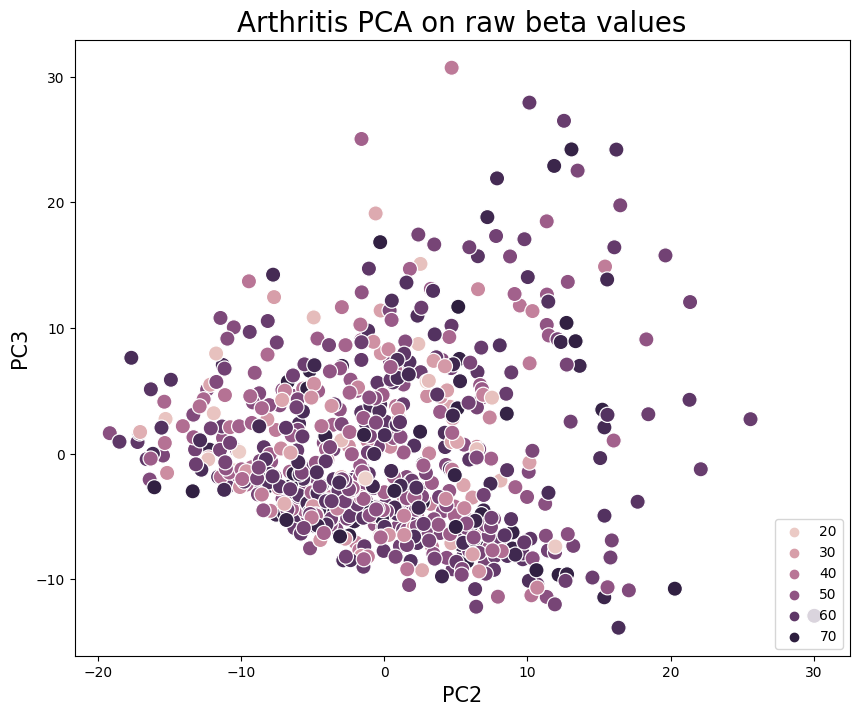

In [38]:
plt.figure(figsize=(10, 8)) 
# Create a scatter plot of the transformed data
sns.scatterplot(pcs, x='PC2',y='PC3',hue='Age', s=120)
plt.xlabel('PC2',fontsize=15)
plt.ylabel('PC3',fontsize=15)
plt.title('Arthritis PCA on raw beta values',fontsize=20)
plt.legend(loc='lower right')
# plt.savefig('DuoAge/Normalization/Unnormalized_pca.png',dpi=300)

In [4]:
art = np.load('Datasets/Arthritis/Arthritis.npy', allow_pickle=True)
art_meta = pd.read_excel('Datasets/Arthritis/Arthritis_pmeta.xlsx')

In [10]:
cgs=list_reader('Datasets/Arthritis/cgs.txt')

In [11]:
pca = PCA()

In [12]:
reduced_features = pca.fit_transform(art)

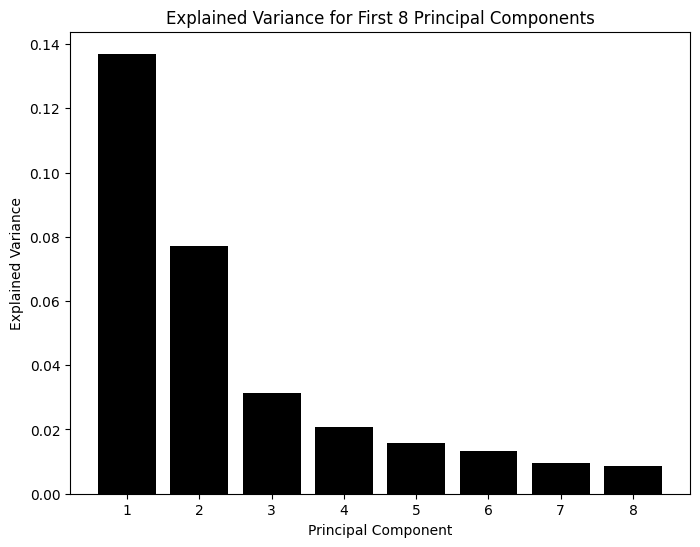

In [13]:
# Get the explained variances for the first 8 principal components
explained_variances = pca.explained_variance_ratio_[:8]

# Plot the explained variances for the first 8 principal components
plt.figure(figsize=(8, 6))
plt.bar(range(1, len(explained_variances) + 1), explained_variances, color='k')
plt.title('Explained Variance for First 8 Principal Components')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance')
plt.show()

In [29]:
component1 = reduced_features[:,0]
component2 = reduced_features[:,1]

In [35]:
pcs = pd.DataFrame({'PC1':component1, 'PC2':component2, 'Gender':art_meta.gender,'Age': art_meta.age, 'Health': art_meta.disease_state})

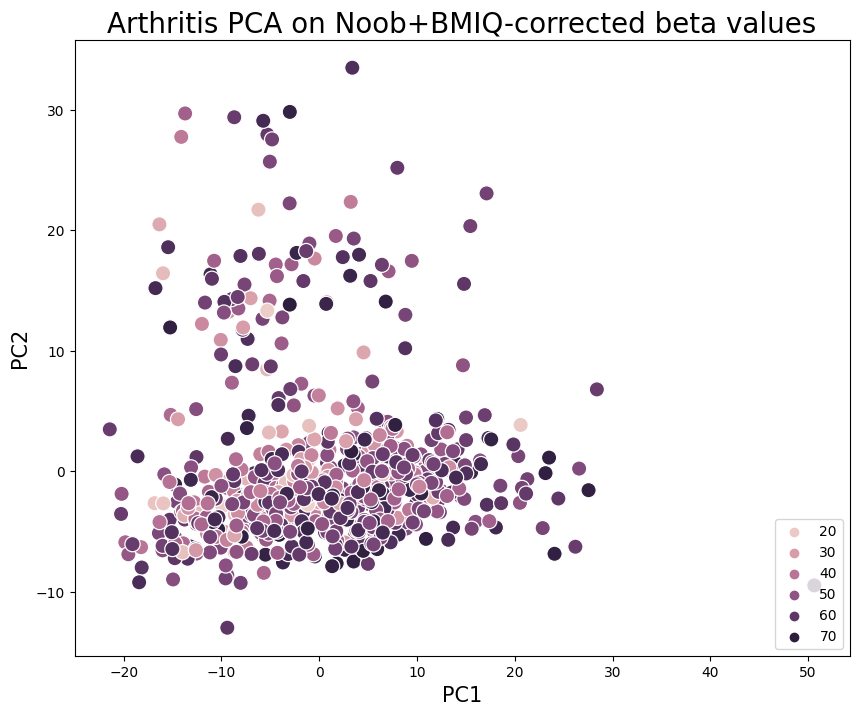

In [37]:
plt.figure(figsize=(10, 8)) 
# Create a scatter plot of the transformed data
sns.scatterplot(pcs, x='PC1',y='PC2',hue='Age', alpha=1, s=120)
plt.xlabel('PC1',fontsize=15)
plt.ylabel('PC2',fontsize=15)
plt.title('Arthritis PCA on Noob+BMIQ-corrected beta values',fontsize=20)
plt.legend(loc='lower right')
# plt.savefig('DuoAge/Normalization/Unnormalized_pca.png',dpi=300)

In [41]:
art_df = pd.DataFrame(art, columns=cgs)

In [43]:
art_healthy= art_df[art_meta.disease_state == 'Normal']

In [45]:
#Produces a dataframe with only the healthy samples and the CpGs which are most tightly regulated

# Calculate the standard deviation of each column
std_dev = art_healthy.std()

# Select columns where the standard deviation is less than 0.02
selected_columns = art_healthy.columns[std_dev < 0.02]

# Create a new DataFrame containing only the selected columns
filtered_healthy = art_healthy[selected_columns]

In [53]:
filtered_healthy.shape

(335, 158311)

In [47]:
#produces a dataframe of all samples but with only the CpGs which are tightly regulated in healthy subjects
regulated = art_df[filtered_healthy.columns.tolist()]

In [50]:
regulated.shape

(689, 158311)

In [51]:
#get the means of the regulated CpGs from only the healthy samples
means = filtered_healthy.mean()

#create a dataframe of ALL samples which have the means from the healthy samples subtracted from all samples
noisy = regulated-means

In [54]:
noisy.shape

(689, 158311)

In [52]:
reduced_features = pca.fit_transform(noisy)

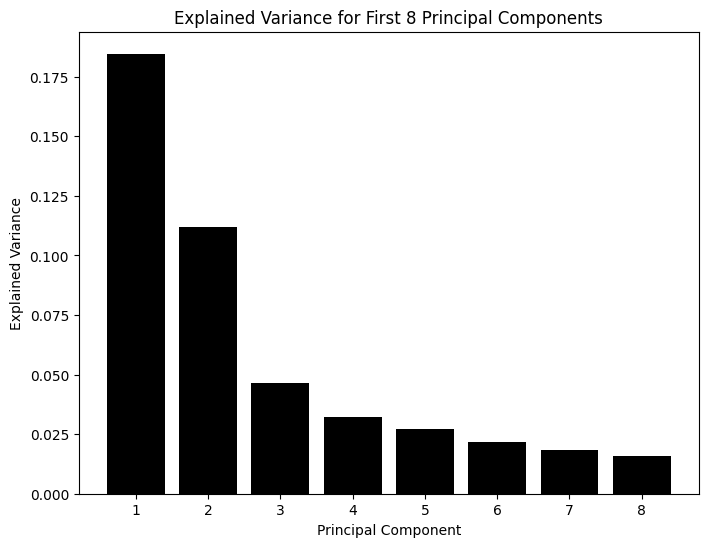

In [55]:
# Get the explained variances for the first 8 principal components
explained_variances = pca.explained_variance_ratio_[:8]

# Plot the explained variances for the first 8 principal components
plt.figure(figsize=(8, 6))
plt.bar(range(1, len(explained_variances) + 1), explained_variances, color='k')
plt.title('Explained Variance for First 8 Principal Components')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance')
plt.show()

In [84]:
component1 = reduced_features[:,1]
component2 = reduced_features[:,2]

In [89]:
pcs = pd.DataFrame({'PC2':component1, 'PC3':component2, 'Gender':art_meta.gender,'Age': art_meta.age, 'Health': art_meta.disease_state})

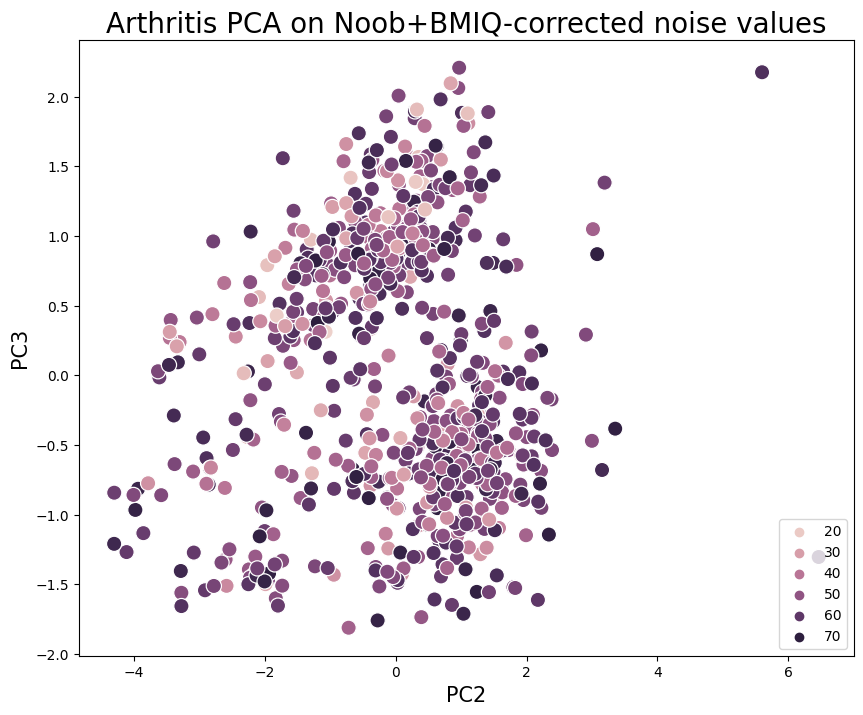

In [91]:
plt.figure(figsize=(10, 8)) 
# Create a scatter plot of the transformed data
sns.scatterplot(pcs, x='PC2',y='PC3',hue='Age', alpha=1, s=120)
plt.xlabel('PC2',fontsize=15)
plt.ylabel('PC3',fontsize=15)
plt.title('Arthritis PCA on Noob+BMIQ-corrected noise values',fontsize=20)
plt.legend(loc='lower right')
# plt.savefig('DuoAge/Normalization/Unnormalized_pca.png',dpi=300)

### Alzheimers

In [5]:
# alz = pd.read_csv('Datasets/Alzheimers/Alzheimers_raw.csv')
alz = np.load('Datasets/Alzheimers/Alzheimers.npy', allow_pickle=True)
alz_meta = pd.read_excel('Datasets/Alzheimers/Alzheimersp_meta.xlsx')

In [6]:
cgs = list_reader('Datasets/Alzheimers/cgs.txt')

In [7]:
df = pd.DataFrame(alz,columns=cgs)

In [132]:
# df=df.drop(413)
# alz_meta = alz_meta.drop(413)
df=df.drop(412)
alz_meta = alz_meta.drop(412)

In [133]:
alz_healthy= df[alz_meta.disease_state == 'healthy control']

In [135]:
# Calculate the standard deviation of each column
std_dev = alz_healthy.std()

# Select columns where the standard deviation is less than 0.02
selected_columns = alz_healthy.columns[std_dev < 0.01]

# Create a new DataFrame containing only the selected columns
filtered_healthy = alz_healthy[selected_columns]

In [136]:
regulated = df[filtered_healthy.columns.tolist()]

In [137]:
regulated.shape

(724, 124685)

In [138]:
means = filtered_healthy.mean()
noisy = regulated-means

In [ ]:
means = list(abs(noisy.mean(axis=1)))

In [126]:
means.index(max(means))

412

In [127]:
alz_meta.iloc[412,:]

REF_ID                     GSM4649800
age                           unknown
gender                           Male
smoking_status                unknown
disease_state     Alzheimer's disease
healthy                             1
series_ID                   GSE153712
Name: 412, dtype: object

In [116]:
pca = PCA()

In [106]:
means.index(max(means))

413

In [139]:
reduced_features = pca.fit_transform(noisy)

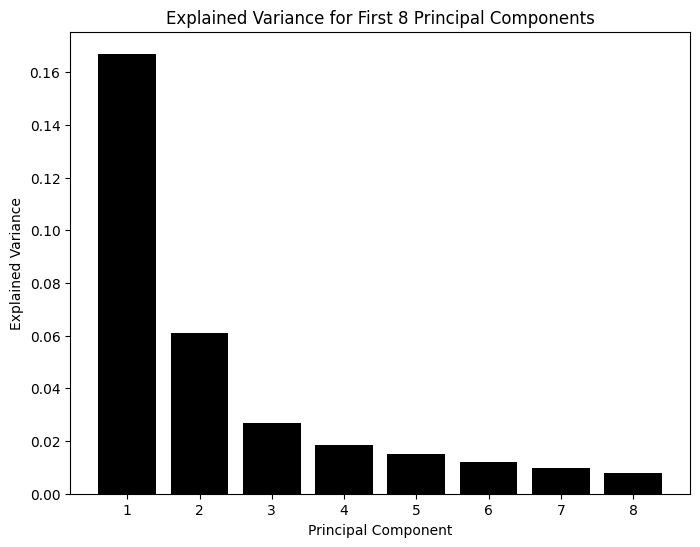

In [140]:
# Get the explained variances for the first 8 principal components
explained_variances = pca.explained_variance_ratio_[:8]

# Plot the explained variances for the first 8 principal components
plt.figure(figsize=(8, 6))
plt.bar(range(1, len(explained_variances) + 1), explained_variances, color='k')
plt.title('Explained Variance for First 8 Principal Components')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance')
plt.show()

In [141]:
component1 = reduced_features[:, 0]
component2 = reduced_features[:, 1]

In [142]:
pcs = pd.DataFrame({'PC1':component1, 'PC2':component2, 'Gender': alz_meta.gender,'Health': alz_meta.disease_state})

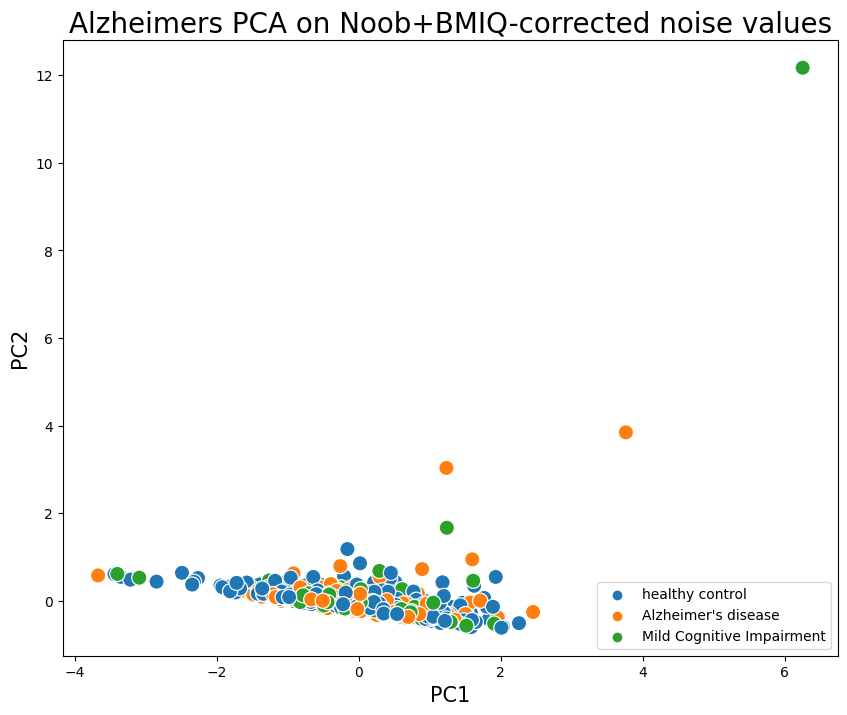

In [143]:
plt.figure(figsize=(10, 8)) 
# Create a scatter plot of the transformed data
sns.scatterplot(pcs, x='PC1',y='PC2',hue='Health', s=120)
plt.xlabel('PC1',fontsize=15)
plt.ylabel('PC2',fontsize=15)
plt.title('Alzheimers PCA on Noob+BMIQ-corrected noise values',fontsize=20)
plt.legend(loc='lower right')
# plt.savefig('DuoAge/Normalization/Unnormalized_pca.png',dpi=300)

In [144]:
reduced_features = pca.fit_transform(noisy)

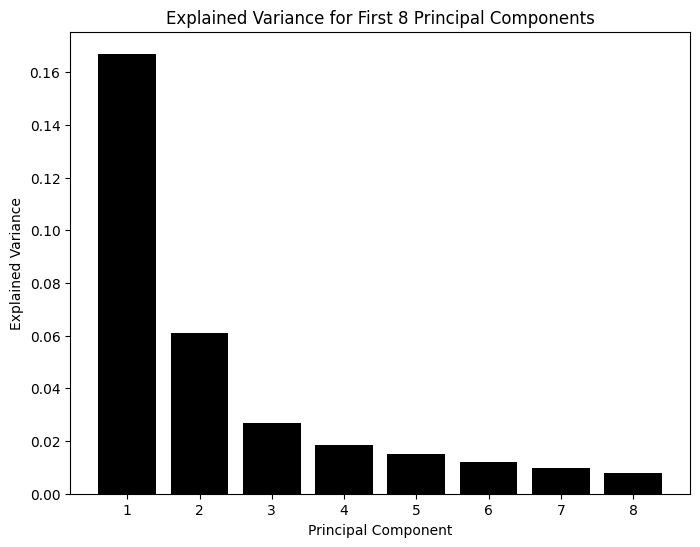

In [145]:
# Get the explained variances for the first 8 principal components
explained_variances = pca.explained_variance_ratio_[:8]

# Plot the explained variances for the first 8 principal components
plt.figure(figsize=(8, 6))
plt.bar(range(1, len(explained_variances) + 1), explained_variances, color='k')
plt.title('Explained Variance for First 8 Principal Components')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance')
plt.show()

In [180]:
component1 = reduced_features[:, 7]
component2 = reduced_features[:, 8]

In [181]:
pcs = pd.DataFrame({'PC1':component1, 'PC2':component2, 'Gender': alz_meta.gender,'Health': alz_meta.disease_state})

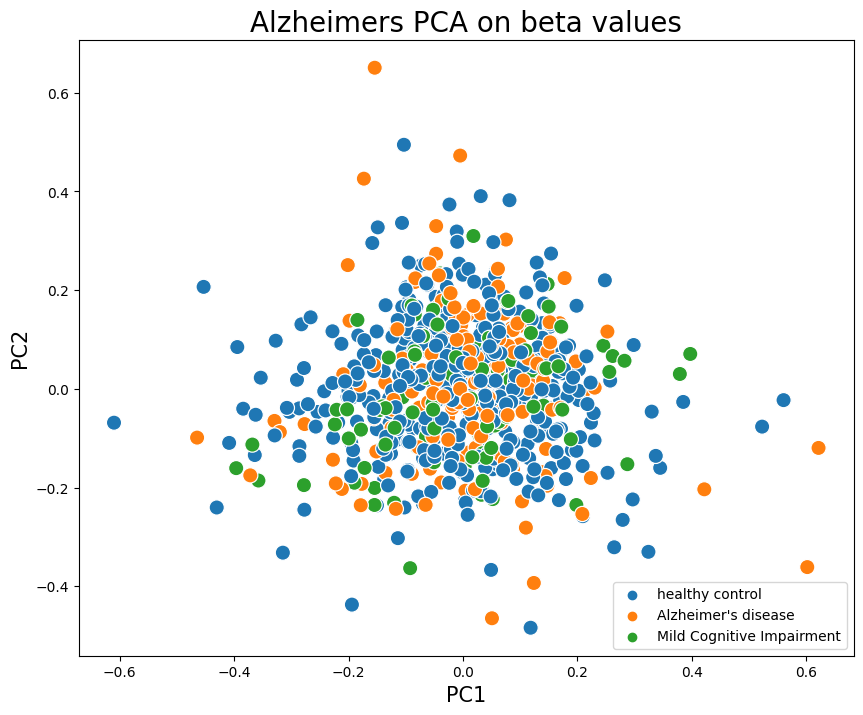

In [182]:
plt.figure(figsize=(10, 8)) 
# Create a scatter plot of the transformed data
sns.scatterplot(pcs, x='PC1',y='PC2',hue='Health', s=120)
plt.xlabel('PC1',fontsize=15)
plt.ylabel('PC2',fontsize=15)
plt.title('Alzheimers PCA on beta values',fontsize=20)
plt.legend(loc='lower right')
# plt.savefig('DuoAge/Normalization/Unnormalized_pca.png',dpi=300)

# Noise analysis via Shannon entropy

In [31]:
import random

In [14]:
sig_cgs = list_reader("Datasets/age correlated adfm cpgs")

In [32]:
#Serafina's CpG list selected by Pearson's r cutoffs
const_cgs = pd.read_excel('Datasets/CpG_healthy.xlsx')
const_cgs=const_cgs.columns[1:].tolist()

In [17]:
arts = pd.read_pickle('Datasets/Arthritis/Arthritis.pkl')
arts_ages = pd.read_excel('Datasets/Arthritis/Arthritis ages.xlsx')
meta = pd.read_excel('Datasets/Arthritis/Arthritis metadata.xlsx')

In [17]:
arts[serafinas_cgs]

ID_REF     cg11512280 cg02865818 cg02458945 cg05297854 cg02819335 cg14655044  \
GSM1051525   0.094887   0.093797   0.038724   0.088952   0.028386   0.932446   
GSM1051526   0.113775   0.086635   0.040762   0.053914   0.033398   0.913098   
GSM1051527    0.07512   0.080093   0.012404   0.040723   0.020433   0.891969   
GSM1051528   0.090944   0.085613   0.061039   0.042056     0.0365   0.917794   
GSM1051529    0.10032   0.089854   0.031848   0.054429   0.026959   0.921224   
...               ...        ...        ...        ...        ...        ...   
GSM1052209   0.103247   0.086249   0.024507   0.048492   0.034694   0.900024   
GSM1052210   0.095544   0.085258   0.028909   0.050675   0.048832   0.818724   
GSM1052211   0.108583   0.093641   0.046531    0.05888   0.048993   0.897263   
GSM1052212   0.159238   0.095449   0.061996   0.083572   0.086543   0.919211   
GSM1052213   0.090804   0.108905   0.027601   0.045168   0.033253   0.911648   

ID_REF     cg09734380 cg19850959 cg18177533 cg05214390  ... cg12804010  \
GSM1051525    0.10702   0.037877   0.065718   0.062067  ...   0.047654   
GSM1051526   0.124244   0.033777   0.055028   0.043821  ...   0.045084   
GSM1051527   0.078934   0.027811   0.048988   0.035695  ...   0.034004   
GSM1051528   0.095721   0.035703   0.027526   0.051336  ...   0.043648   
GSM1051529   0.100193   0.036077   0.034344   0.044801  ...   0.055886   
...               ...        ...        ...        ...  ...        ...   
GSM1052209   0.096207   0.048261   0.066841   0.041731  ...   0.049406   
GSM1052210   0.066702   0.050887   0.035353   0.034176  ...   0.046304   
GSM1052211   0.084724   0.044949   0.071374   0.045986  ...   0.066572   
GSM1052212   0.128142   0.088951   0.085473   0.072647  ...   0.077499   
GSM1052213   0.088238   0.053497    0.05038   0.052302  ...    0.06414   

ID_REF     cg06118384 cg26577729 cg08919494 cg02100674 cg00661947 cg03153658  \
GSM1051525   0.078073   0.086345   0.043096   0.052567   0.894291   0.064916   
GSM1051526   0.046304   0.070428   0.033154   0.045341   0.902965   0.040724   
GSM1051527   0.035351   0.062703   0.026746   0.021077   0.888875   0.031445   
GSM1051528   0.057496   0.090214     0.0569   0.036351   0.895547   0.039006   
GSM1051529   0.058424   0.092367   0.031791   0.037207   0.880964   0.036902   
...               ...        ...        ...        ...        ...        ...   
GSM1052209   0.050709   0.068481   0.041511   0.035173    0.89822   0.038483   
GSM1052210   0.040818   0.115672   0.036237    0.05301    0.88268   0.038792   
GSM1052211   0.095208   0.068422   0.034668   0.046421   0.903339   0.039739   
GSM1052212   0.122414   0.097958    0.08309   0.063051   0.901624   0.105721   
GSM1052213   0.063784   0.069069   0.048302   0.045679   0.893821   0.042106   

ID_REF     cg25893004 cg18617589 cg11156672  
GSM1051525   0.112969   0.051729   0.040171  
GSM1051526   0.095467   0.043114   0.051676  
GSM1051527   0.050039   0.048219   0.047442  
GSM1051528   0.094807   0.073527   0.061767  
GSM1051529   0.077335   0.054669   0.042461  
...               ...        ...        ...  
GSM1052209   0.064833   0.065537   0.045006  
GSM1052210    0.10752   0.061669   0.052616  
GSM1052211   0.069767   0.073378   0.047394  
GSM1052212   0.112214   0.112284    0.06471  
GSM1052213   0.063419   0.071274    0.05955  

[689 rows x 29 columns]

In [18]:
shentropies = get_shentropy(arts[serafinas_cgs])

In [31]:
meta

Unnamed: 0  Age         Disease state Gender Smoking Status
0    GSM1051525   67  rheumatoid arthritis      f        current
1    GSM1051526   49  rheumatoid arthritis      f        current
2    GSM1051527   53  rheumatoid arthritis      f             ex
3    GSM1051528   62  rheumatoid arthritis      f        current
4    GSM1051529   33  rheumatoid arthritis      f          never
..          ...  ...                   ...    ...            ...
684  GSM1052209   63                Normal      f             ex
685  GSM1052210   63                Normal      f          never
686  GSM1052211   46                Normal      f          never
687  GSM1052212   64                Normal      f             ex
688  GSM1052213   36                Normal      f          never

[689 rows x 5 columns]

In [19]:
col = np.where(meta['Disease state'] == 'Normal','b','r')

Text(0.5, 1.0, 'Shannon entropy for Arthritis, p=50')

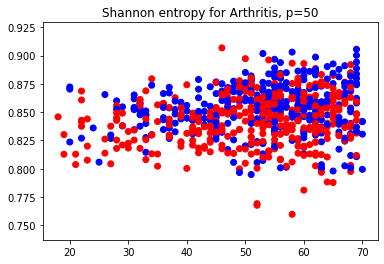

In [21]:
plt.scatter(arts_ages.Age,shentropies, c=col)
plt.title('Shannon entropy for Arthritis, p=50')

In [226]:
rand_sample=arts[random.sample(het_cgs,10)]

In [46]:
#need to reset the indices to numbers to be able to do boolean calls to get specific rows
arts.reindex(np.linspace(1,len(arts.index),len(arts.index)).astype(int))
arts=arts.reset_index()
arts = arts[arts.columns[1:]]

In [15]:
ibs = pd.read_pickle('Datasets/IBS/IBS.pkl')
ibs_ages = pd.read_excel('Datasets/IBS/IBS ages.xlsx') 

In [16]:
ibs

ID_REF      cg00000029  cg00000108  cg00000109  cg00000165  cg00000236  \
GSM2336818    0.484840    0.904301    0.706628    0.268115    0.696812   
GSM2336819    0.549209    0.899991    0.757192    0.254714    0.782396   
GSM2336820    0.665182    0.910282    0.814520    0.241178    0.776249   
GSM2336821    0.536237    0.898268    0.796119    0.244020    0.723803   
GSM2336822    0.450374    0.906696    0.776311    0.250357    0.726807   
...                ...         ...         ...         ...         ...   
GSM2337053    0.754166    0.924941    0.826363    0.278728    0.859885   
GSM2337054    0.544069    0.922609    0.834624    0.280992    0.713173   
GSM2337055    0.574472    0.930687    0.836744    0.268772    0.769004   
GSM2337056    0.538766    0.937964    0.865123    0.271731    0.762731   
GSM2337057    0.535318    0.927877    0.845603    0.259874    0.758094   

ID_REF      cg00000289  cg00000292  cg00000321  cg00000363  cg00000622  ...  \
GSM2336818    0.552807    0.731842    0.355477    0.351903    0.045642  ...   
GSM2336819    0.537098    0.826841    0.343745    0.383886    0.043136  ...   
GSM2336820    0.676952    0.871598    0.327974    0.418875    0.040509  ...   
GSM2336821    0.561323    0.829576    0.283472    0.408616    0.046047  ...   
GSM2336822    0.578344    0.777413    0.261513    0.396494    0.044639  ...   
...                ...         ...         ...         ...         ...  ...   
GSM2337053    0.658426    0.895978    0.461872    0.472104    0.043561  ...   
GSM2337054    0.659256    0.802371    0.300417    0.427558    0.051920  ...   
GSM2337055    0.707079    0.853384    0.290878    0.466079    0.057271  ...   
GSM2337056    0.784256    0.871394    0.294934    0.391865    0.053007  ...   
GSM2337057    0.742672    0.853172    0.292472    0.374977    0.056055  ...   

ID_REF      rs7746156  rs798149  rs845016  rs877309  rs9292570  rs9363764  \
GSM2336818   0.553988  0.477160  0.555363  0.532696   0.508120   0.259912   
GSM2336819   0.542820  0.944774  0.485624  0.942371   0.488452   0.855391   
GSM2336820   0.672129  0.056950  0.693259  0.540354   0.637202   0.640432   
GSM2336821   0.932671  0.065737  0.522881  0.536366   0.920109   0.113204   
GSM2336822   0.541303  0.059852  0.524525  0.940133   0.469027   0.596338   
...               ...       ...       ...       ...        ...        ...   
GSM2337053   0.535310  0.061385  0.470220  0.608104   0.535429   0.111257   
GSM2337054   0.529538  0.460318  0.136502  0.945212   0.530844   0.899833   
GSM2337055   0.070562  0.947828  0.114142  0.063007   0.060613   0.580962   
GSM2337056   0.076908  0.463673  0.476765  0.947183   0.926799   0.094965   
GSM2337057   0.516563  0.449476  0.109348  0.579989   0.057107   0.112238   

ID_REF      rs939290  rs951295  rs966367  rs9839873  
GSM2336818  0.557469  0.902920  0.806501   0.722293  
GSM2336819  0.581672  0.922380  0.817588   0.797783  
GSM2336820  0.578289  0.566337  0.387525   0.860193  
GSM2336821  0.602383  0.079792  0.571661   0.848829  
GSM2336822  0.561113  0.522132  0.610090   0.641714  
...              ...       ...       ...        ...  
GSM2337053  0.916240  0.492598  0.159320   0.703948  
GSM2337054  0.105268  0.516616  0.168397   0.856872  
GSM2337055  0.604596  0.070221  0.543221   0.678708  
GSM2337056  0.570425  0.075604  0.899900   0.897679  
GSM2337057  0.922135  0.518839  0.545441   0.888337  

[240 rows x 485577 columns]

In [ ]:
# ibs=ibs[const_cgs]
# col = np.where(ibs_ages['Disease State'] == 'HC','b','r')

In [14]:
# ms = pd.read_pickle('Datasets/MS/MS.pkl')
# ms_ages = pd.read_excel('Datasets/MS/MS ages.xlsx') 

In [18]:
# ms=ms[const_cgs]
# col = np.where(ms_ages['Disease Status'] == 'Healthy control','b','r')

In [532]:
# hannum = pd.read_pickle('Datasets/Hannum/Hannum.pkl') 
# ages = pd.read_excel('Training/DS3_ages.xlsx')

In [16]:
# hannum=hannum[const_cgs]

In [14]:
deps = pd.read_pickle('Datasets/Depression/Depression.pkl')

In [17]:
shentropies = get_shentropy(hannum)

### Check how the entropies change with age

Text(0.5, 1.0, 'Shannon entropy for hannum, p=6282')

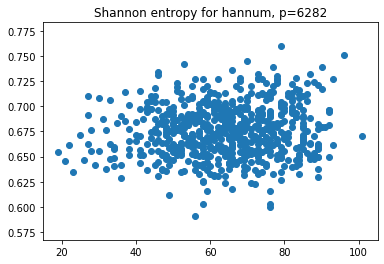

In [18]:
plt.scatter(ages.Age,shentropies)
plt.title('Shannon entropy for hannum, p=6282')

Text(0.5, 1.0, 'cg15408073')

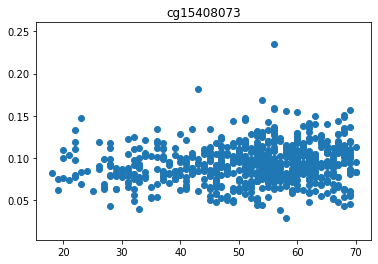

In [222]:
#Check the beta value distribution of a random CpG in the list
n =random.randint(1,len(const_cgs))
plt.scatter(arts_ages.Age.astype(float),arts[const_cgs[n]])
plt.title(const_cgs[n])

Text(0.5, 1.0, 'cg16986846')

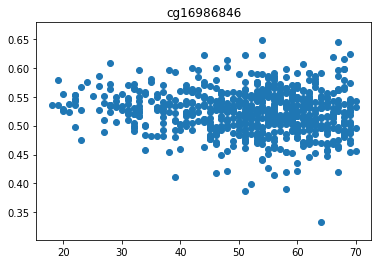

In [224]:
#Check the beta value distribution of a random CpG in the list
n =random.randint(1,len(const_cgs))
plt.scatter(arts_ages.Age.astype(float),arts[const_cgs[n]])
plt.title(const_cgs[n])

### cg15845365 has a very interest pattern. Needs a deeper look

In [118]:
col = np.where(meta['Disease state'] == 'Normal','b','r')

Text(0.5, 1.0, 'cg15845365 on Arthritis')

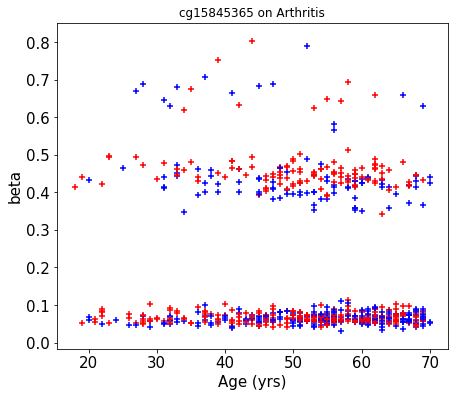

In [314]:
plt.figure(figsize=(7, 6))
plt.scatter(arts_ages.Age.astype(float), arts['cg15845365'], marker='+', c=col)

plt.xlabel('Age (yrs)',fontsize=15)
plt.ylabel('beta',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.title('cg15845365 on Arthritis')
# plt.savefig('Hannum figures/Figure x/horvath on down syndrome', dpi=300)

### Get the stddev-normalized absolute difference from the mean for each CpG

In [37]:
meta = pd.read_excel('Datasets/Arthritis/Arthritis metadata.xlsx')

In [34]:
het_cgs = list_reader('Datasets/het cgs')

In [35]:
len(het_cgs)

6565

In [36]:
#get just the constant cpgs
constants = arts[het_cgs]

In [37]:
constants

ID_REF     cg18062138 cg20725157 cg15427448 cg24726668 cg09901574 cg21709909  \
GSM1051525   0.096658   0.057346   0.036274   0.059233   0.919317   0.028768   
GSM1051526   0.102485   0.049842   0.040321   0.070498   0.926399   0.049265   
GSM1051527   0.086719   0.037276   0.033162   0.073642   0.902827   0.040088   
GSM1051528   0.093441   0.066862    0.04274   0.061763   0.921346   0.026238   
GSM1051529   0.092385   0.054392   0.030393   0.069065   0.910888    0.04028   
...               ...        ...        ...        ...        ...        ...   
GSM1052209   0.096276   0.045452   0.039366   0.064251   0.937314   0.048727   
GSM1052210     0.0766   0.131887   0.047037    0.09547   0.945963   0.036964   
GSM1052211   0.094346   0.061552   0.039212   0.075517   0.920574   0.056145   
GSM1052212   0.095564    0.08629   0.111925   0.072774   0.940089   0.040657   
GSM1052213   0.102163   0.059508   0.051016   0.077701   0.900497   0.058587   

ID_REF     cg18595957 cg24764310 cg01301637 cg08322240  ... cg17576288  \
GSM1051525   0.891004   0.942343   0.047162   0.118896  ...   0.077954   
GSM1051526   0.884347   0.949338   0.038569     0.1083  ...   0.064593   
GSM1051527   0.905472   0.937144   0.022126   0.089592  ...   0.045881   
GSM1051528   0.877541   0.934664   0.042162   0.106944  ...   0.043257   
GSM1051529   0.895423   0.947196   0.035998   0.098912  ...   0.048618   
...               ...        ...        ...        ...  ...        ...   
GSM1052209   0.923981   0.937517   0.021452   0.091674  ...   0.063402   
GSM1052210   0.917749   0.885329   0.030713   0.048999  ...   0.066436   
GSM1052211   0.885473   0.936357   0.048537   0.105972  ...   0.082824   
GSM1052212   0.897113    0.94093   0.079217    0.13323  ...   0.089025   
GSM1052213   0.896832   0.928605   0.025743   0.099873  ...   0.058576   

ID_REF     cg10699215 cg17031656 cg20745910 cg20744625 cg19258665 cg07035503  \
GSM1051525   0.010297   0.971768    0.94277   0.046931   0.080892   0.030738   
GSM1051526   0.013267   0.962903   0.953089   0.024198   0.061874   0.026801   
GSM1051527   0.014764   0.974357   0.937214   0.022474   0.039672    0.01901   
GSM1051528   0.014898   0.977333   0.951734   0.034703   0.071594   0.042352   
GSM1051529   0.013093   0.957835   0.944537   0.026877   0.065226   0.021855   
...               ...        ...        ...        ...        ...        ...   
GSM1052209   0.027092   0.953455   0.946499   0.042916   0.069548   0.031622   
GSM1052210   0.030207   0.947372   0.930386   0.032662   0.078204    0.02864   
GSM1052211   0.022153   0.960358   0.929763   0.049026   0.083714   0.041267   
GSM1052212   0.024405   0.961697   0.924216   0.056776   0.094335   0.043155   
GSM1052213   0.037238   0.958176   0.937281   0.040412    0.07486   0.020627   

ID_REF     cg10995082 cg11154747 cg14784788  
GSM1051525   0.057085   0.064521   0.061292  
GSM1051526   0.059661   0.056806   0.068396  
GSM1051527   0.043982   0.048589   0.067145  
GSM1051528   0.041254   0.072545    0.06213  
GSM1051529   0.062572   0.063669   0.070188  
...               ...        ...        ...  
GSM1052209   0.059841   0.064449   0.063417  
GSM1052210   0.044525   0.095565   0.071863  
GSM1052211   0.048758   0.093597   0.085722  
GSM1052212   0.104319   0.127937   0.071145  
GSM1052213   0.051918   0.081693   0.090803  

[689 rows x 6565 columns]

In [38]:
#get the indicies of the healthy samples
col_healthy= np.where(meta['Disease state'] == 'Normal')

In [39]:
#get the healthy samples with the constant  CpGs
healthy = constants.iloc[col_healthy[0].tolist(),:]
healthy_ages = arts_ages.iloc[col_healthy[0],:]

In [40]:
#get the healthy samples with the constant  CpGs
healthy = constants.iloc[col_healthy[0].tolist(),:]
healthy_ages = arts_ages.iloc[col_healthy[0],:]

In [533]:
# #get the normalized absolute differences from the means
# adfms, means, mads = get_adfm(healthy, healthy_ages.Age,het_cgs)

In [33]:
adfms, means = get_adfms1(healthy, const_cgs)

In [40]:
sig_cgs = get_sig_cgs(adfms, healthy_ages.Age, const_cgs, 27, 0.2)

In [301]:
#list_writer(sig_cgs, "Datasets/age correlated adfm cpgs")

In [13]:
sig_cgs = list_reader("Datasets/age correlated adfm cpgs")

In [14]:
# list_writer(means, "Datasets/adfm means")

In [41]:
means = list_reader("Datasets/adfm means")
means = [float(i) for i in means]

In [303]:
sods, norm_score = get_sods(adfms, healthy_ages.Age, sig_cgs)

In [12]:
#run this when you don't want to re-run the code to get the initial values from the healthy set
norm_score = 0.2984138538583705

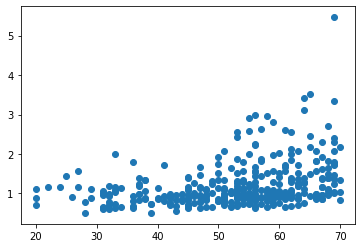

In [304]:
plt.scatter(healthy_ages, sods)

In [305]:
col_dis = np.where(meta['Disease state'] == 'rheumatoid arthritis')

In [306]:
#get the arthritis samples with the constant  CpGs
rh = constants.iloc[col_dis[0].tolist(),:]
rh_ages = arts_ages.iloc[col_dis[0].tolist(),:]

In [307]:
art_sods = noise_predict1(rh,means, sig_cgs, norm_score)

In [309]:
col = np.where(meta['Disease state'] == 'Normal','b','r')

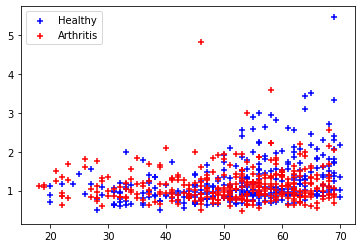

In [310]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(healthy_ages, sods, c='b', marker='+', label='Healthy')
ax1.scatter(rh_ages, art_sods,c='r', marker='+', label='Arthritis')
plt.legend(loc='upper left');
plt.show()

### Let's look at one of the CpGs

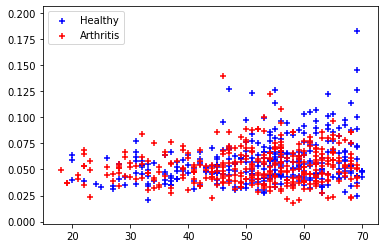

In [237]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(healthy_ages, healthy[sig_cgs[20]], c='b', marker='+', label='Healthy')
ax1.scatter(rh_ages, rh[sig_cgs[20]],c='r', marker='+', label='Arthritis')
plt.legend(loc='upper left');
plt.show()

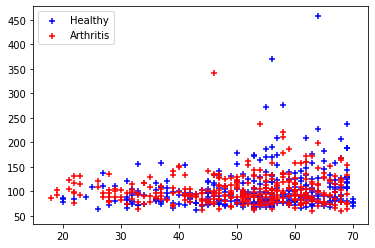

In [26]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(healthy_ages, sods, c='b', marker='+', label='Healthy')
ax1.scatter(rh_ages, art_sods,c='r', marker='+', label='Arthritis')
plt.legend(loc='upper left');
plt.show()

### Let's check MS

In [313]:
ms = pd.read_pickle('Datasets/MS/MS.pkl')

In [314]:
ms_ages = pd.read_excel('Datasets/MS/MS ages.xlsx')

In [316]:
col = np.where(ms_ages['Disease Status'] == 'Healthy control','b','r')

In [321]:
ms=ms[het_cgs]

In [322]:
ms_sods = noise_predict1(ms,means, sig_cgs, norm_score)

(array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. ]),
 <a list of 9 Text yticklabel objects>)

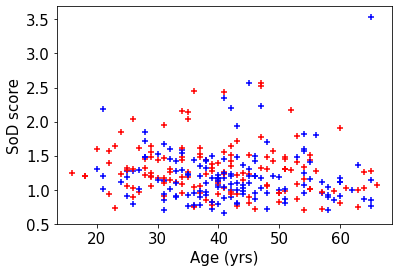

In [325]:
# plt.figure(figsize=(7, 6))
plt.scatter(ms_ages.Age.astype(float), ms_sods, marker='+', c=col)

plt.xlabel('Age (yrs)',fontsize=15)
plt.ylabel('SoD score',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

### Let's check hannum

In [16]:
hannum = pd.read_pickle('Datasets/Hannum/Hannum.pkl')

In [20]:
#Read in ages for Hannum dataset 
ages = pd.read_excel('Training/DS3_ages.xlsx')

In [ ]:
hannum=hannum[het_cgs]

In [43]:
hannum_sods = noise_predict1(hannum,means, sig_cgs, norm_score)

(array([0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5]),
 <a list of 11 Text yticklabel objects>)

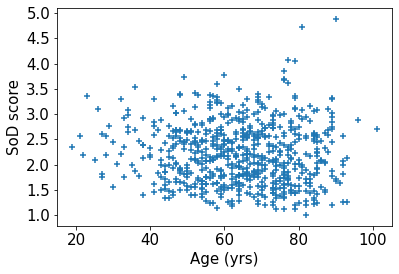

In [44]:
# plt.figure(figsize=(7, 6))
plt.scatter(ages.Age.astype(float), hannum_sods, marker='+')

plt.xlabel('Age (yrs)',fontsize=15)
plt.ylabel('SoD score',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

### Get sods for arthritis

In [537]:
col_dis = np.where(meta['Disease state'] == 'rheumatoid arthritis')
#get the arthritis samples with the constant  CpGs
rh = constants.iloc[col_dis[0].tolist(),:]
rh_ages = arts_ages.iloc[col_dis[0].tolist(),:]
art_adfms = noise_predict(rh,means,mads)
art_sods=art_adfms.sum(axis=1)

In [578]:
import matplotlib.gridspec as gridspec

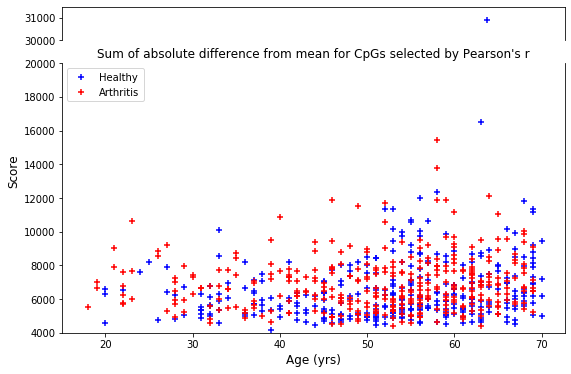

In [636]:
ylim  = [30000, 31500]
ylim2 = [4000, 20000]
ylimratio = 1
ylim2ratio =8
gs = gridspec.GridSpec(2, 1, height_ratios=[ylimratio, ylim2ratio])
fig = plt.figure(figsize=(9,6))
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
ax1.scatter(healthy_ages, sods, c='b', marker="+", label='Healthy')
ax2.scatter(healthy_ages, sods, c='b', marker="+", label='Healthy')
ax2.scatter(rh_ages,art_sods, c='r', marker="+", label='Arthritis')
ax1.set_ylim(ylim)
ax2.set_ylim(ylim2)
plt.subplots_adjust(hspace=0.15)

ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
   
ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

ax2.set_xlabel('Age (yrs)', fontsize=12)
ax2.set_ylabel('Score', fontsize=12)
ax2.yaxis.set_label_coords(0.06, 0.5, transform=fig.transFigure)

kwargs = dict(color='k', clip_on=False)


plt.legend(loc='upper left');
# plt.xlabel('Age (yrs)',fontsize=12)
# plt.ylabel('Score',fontsize=12)
# plt.xticks(fontsize=15)
# plt.yticks(fontsize=15)

plt.title('Sum of absolute difference from mean for CpGs selected by Pearson\'s r')


plt.savefig('Hannum figures/Figure x/Noise on constant rs', dpi=300)
plt.show()

### Try OLS on absolute differences from mean

In [ ]:
methyl_train, methyl_test, age_train, age_test = train_test_split(adfms, healthy_ages.Age, test_size=0.2, random_state=40)

scaler = StandardScaler()
fit = scaler.fit(methyl_train)
methyl_train = fit.transform(methyl_train)

# age_train=age_train.values.ravel()
predictor = LinearRegression(fit_intercept=True).fit(methyl_train, age_train)
methyl_test = fit.transform(methyl_test)
# age_test=age_test.values.ravel()
preds = predictor.predict(methyl_test)

regression = stats.linregress(preds.astype(float), age_test.astype(float))
slope, intercept, rvalue, pvalue, stderr = regression


C:\Users\Colin\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\Colin\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\Colin\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


Text(0.5, 1.0, 'Noise clock on healhty test set (6282 CpGs): r=0.24, \n p=0.05, MAE=9.4 yrs')

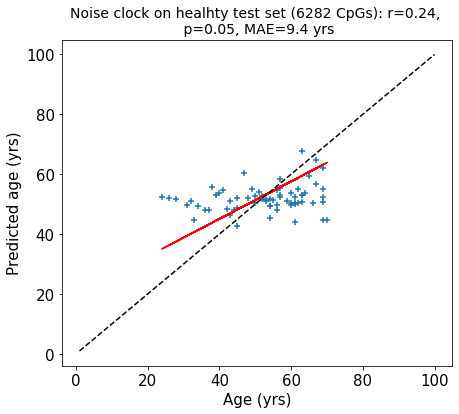

In [423]:
pred = slope * age_test.astype(float) + intercept

plt.figure(figsize=(7, 6))
plt.scatter(age_test.astype(float), preds, marker='+')
plt.plot(age_test.astype(float), pred, color='red')
plt.plot(np.linspace(1,100,100), np.linspace(1,100,100), color='k', linestyle = 'dashed')

plt.xlabel('Age (yrs)',fontsize=15)
plt.ylabel('Predicted age (yrs)',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
mae = metrics.mean_absolute_error(age_test.astype(float), preds)

plt.title('Noise clock on healhty test set (6282 CpGs): r={:.2f}, \n p={:.1g}, MAE={:.1f} yrs'.format(rvalue, pvalue, mae),fontsize=14)
# plt.savefig('Hannum figures/Figure x/Combined WB test', dpi=300)

In [24]:
ms_cands = get_cands(ms, 'ms')

In [25]:
len(ms_cands)

154977

In [9]:
ds = pd.read_pickle('Datasets/Down syndrome/Dsyndrome.pkl')

In [11]:
ds_cands = get_cands(ds, 'ds')

In [12]:
len(ds_cands)

165831

In [4]:
hannum = pd.read_pickle('Datasets/Hannum/Hannum.pkl')

In [7]:
hannum_cands = get_cands(hannum,'hannum')

In [8]:
len(hannum_cands)

145266

In [375]:
arts_cands = list_reader('Datasets/Constants/arts constants')
ms_cands = list_reader('Datasets/Constants/ms constants')
ds_cands = list_reader('Datasets/Constants/ds constants')
hannum_cands = list_reader('Datasets/Constants/hannum constants')

In [376]:
constants=list((set(arts_cands)&set(ms_cands))&(set(ds_cands)&set(hannum_cands)))

In [20]:
constants

ID_REF     cg18062138 cg20725157 cg15427448 cg24726668 cg09901574 cg21709909  \
GSM1051525   0.096658   0.057346   0.036274   0.059233   0.919317   0.028768   
GSM1051526   0.102485   0.049842   0.040321   0.070498   0.926399   0.049265   
GSM1051527   0.086719   0.037276   0.033162   0.073642   0.902827   0.040088   
GSM1051528   0.093441   0.066862    0.04274   0.061763   0.921346   0.026238   
GSM1051529   0.092385   0.054392   0.030393   0.069065   0.910888    0.04028   
...               ...        ...        ...        ...        ...        ...   
GSM1052209   0.096276   0.045452   0.039366   0.064251   0.937314   0.048727   
GSM1052210     0.0766   0.131887   0.047037    0.09547   0.945963   0.036964   
GSM1052211   0.094346   0.061552   0.039212   0.075517   0.920574   0.056145   
GSM1052212   0.095564    0.08629   0.111925   0.072774   0.940089   0.040657   
GSM1052213   0.102163   0.059508   0.051016   0.077701   0.900497   0.058587   

ID_REF     cg18595957 cg24764310 cg01301637 cg08322240  ... cg17576288  \
GSM1051525   0.891004   0.942343   0.047162   0.118896  ...   0.077954   
GSM1051526   0.884347   0.949338   0.038569     0.1083  ...   0.064593   
GSM1051527   0.905472   0.937144   0.022126   0.089592  ...   0.045881   
GSM1051528   0.877541   0.934664   0.042162   0.106944  ...   0.043257   
GSM1051529   0.895423   0.947196   0.035998   0.098912  ...   0.048618   
...               ...        ...        ...        ...  ...        ...   
GSM1052209   0.923981   0.937517   0.021452   0.091674  ...   0.063402   
GSM1052210   0.917749   0.885329   0.030713   0.048999  ...   0.066436   
GSM1052211   0.885473   0.936357   0.048537   0.105972  ...   0.082824   
GSM1052212   0.897113    0.94093   0.079217    0.13323  ...   0.089025   
GSM1052213   0.896832   0.928605   0.025743   0.099873  ...   0.058576   

ID_REF     cg10699215 cg17031656 cg20745910 cg20744625 cg19258665 cg07035503  \
GSM1051525   0.010297   0.971768    0.94277   0.046931   0.080892   0.030738   
GSM1051526   0.013267   0.962903   0.953089   0.024198   0.061874   0.026801   
GSM1051527   0.014764   0.974357   0.937214   0.022474   0.039672    0.01901   
GSM1051528   0.014898   0.977333   0.951734   0.034703   0.071594   0.042352   
GSM1051529   0.013093   0.957835   0.944537   0.026877   0.065226   0.021855   
...               ...        ...        ...        ...        ...        ...   
GSM1052209   0.027092   0.953455   0.946499   0.042916   0.069548   0.031622   
GSM1052210   0.030207   0.947372   0.930386   0.032662   0.078204    0.02864   
GSM1052211   0.022153   0.960358   0.929763   0.049026   0.083714   0.041267   
GSM1052212   0.024405   0.961697   0.924216   0.056776   0.094335   0.043155   
GSM1052213   0.037238   0.958176   0.937281   0.040412    0.07486   0.020627   

ID_REF     cg10995082 cg11154747 cg14784788  
GSM1051525   0.057085   0.064521   0.061292  
GSM1051526   0.059661   0.056806   0.068396  
GSM1051527   0.043982   0.048589   0.067145  
GSM1051528   0.041254   0.072545    0.06213  
GSM1051529   0.062572   0.063669   0.070188  
...               ...        ...        ...  
GSM1052209   0.059841   0.064449   0.063417  
GSM1052210   0.044525   0.095565   0.071863  
GSM1052211   0.048758   0.093597   0.085722  
GSM1052212   0.104319   0.127937   0.071145  
GSM1052213   0.051918   0.081693   0.090803  

[689 rows x 6565 columns]

In [ ]:
plt.scatter(arts_ages.Age.astype(float),constants[constants.columns[random.randint(1,len(constants))]])

In [379]:
arts_ages.Age.astype(float)

0      67.0
1      49.0
2      53.0
3      62.0
4      33.0
       ... 
684    63.0
685    63.0
686    46.0
687    64.0
688    36.0
Name: Age, Length: 689, dtype: float64

In [380]:
x = arts[constants[0]].tolist()

In [382]:
x = sm.add_constant(x)

In [383]:
model = sm.OLS(arts_ages.Age, x).fit()

In [384]:
model.model.exog

array([[1.        , 0.09946012],
       [1.        , 0.10717687],
       [1.        , 0.10168606],
       ...,
       [1.        , 0.09876835],
       [1.        , 0.09125064],
       [1.        , 0.10378883]])

In [385]:
#perform White's test
white_test = het_white(model.resid,  model.model.exog)

In [386]:
white_test[1]

0.6585937160669083

In [ ]:
def get_het(df, ages, cgs):
    
    cg_list=[]
    y = ages
    
    for cg in cgs:
    
        x = df[cg].tolist()

        #add constant to predictor variables
        x = sm.add_constant(x)

        #fit regression model
        model = sm.OLS(y, x).fit()

        #perform White's test
        white_test = het_white(model.resid,  model.model.exog)

        if white_test[1]<0.05:
            cg_list+= [cg]
    return cg_list

In [388]:
het_cgs = get_het(arts,arts_ages.Age.astype(float),constants)

In [389]:
len(het_cgs)

6565

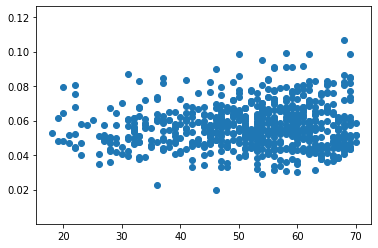

In [390]:
plt.scatter(arts_ages.Age.astype(float),arts[het_cgs[random.randint(1,len(het_cgs))]])

In [137]:
list_writer(het_cgs, 'Datasets/het cgs')

### AFDMs with het cgs

In [16]:
het_cgs = list_reader('Datasets/het cgs')

In [17]:
arts[het_cgs]

ID_REF     cg18062138 cg20725157 cg15427448 cg24726668 cg09901574 cg21709909  \
GSM1051525   0.096658   0.057346   0.036274   0.059233   0.919317   0.028768   
GSM1051526   0.102485   0.049842   0.040321   0.070498   0.926399   0.049265   
GSM1051527   0.086719   0.037276   0.033162   0.073642   0.902827   0.040088   
GSM1051528   0.093441   0.066862    0.04274   0.061763   0.921346   0.026238   
GSM1051529   0.092385   0.054392   0.030393   0.069065   0.910888    0.04028   
...               ...        ...        ...        ...        ...        ...   
GSM1052209   0.096276   0.045452   0.039366   0.064251   0.937314   0.048727   
GSM1052210     0.0766   0.131887   0.047037    0.09547   0.945963   0.036964   
GSM1052211   0.094346   0.061552   0.039212   0.075517   0.920574   0.056145   
GSM1052212   0.095564    0.08629   0.111925   0.072774   0.940089   0.040657   
GSM1052213   0.102163   0.059508   0.051016   0.077701   0.900497   0.058587   

ID_REF     cg18595957 cg24764310 cg01301637 cg08322240  ... cg17576288  \
GSM1051525   0.891004   0.942343   0.047162   0.118896  ...   0.077954   
GSM1051526   0.884347   0.949338   0.038569     0.1083  ...   0.064593   
GSM1051527   0.905472   0.937144   0.022126   0.089592  ...   0.045881   
GSM1051528   0.877541   0.934664   0.042162   0.106944  ...   0.043257   
GSM1051529   0.895423   0.947196   0.035998   0.098912  ...   0.048618   
...               ...        ...        ...        ...  ...        ...   
GSM1052209   0.923981   0.937517   0.021452   0.091674  ...   0.063402   
GSM1052210   0.917749   0.885329   0.030713   0.048999  ...   0.066436   
GSM1052211   0.885473   0.936357   0.048537   0.105972  ...   0.082824   
GSM1052212   0.897113    0.94093   0.079217    0.13323  ...   0.089025   
GSM1052213   0.896832   0.928605   0.025743   0.099873  ...   0.058576   

ID_REF     cg10699215 cg17031656 cg20745910 cg20744625 cg19258665 cg07035503  \
GSM1051525   0.010297   0.971768    0.94277   0.046931   0.080892   0.030738   
GSM1051526   0.013267   0.962903   0.953089   0.024198   0.061874   0.026801   
GSM1051527   0.014764   0.974357   0.937214   0.022474   0.039672    0.01901   
GSM1051528   0.014898   0.977333   0.951734   0.034703   0.071594   0.042352   
GSM1051529   0.013093   0.957835   0.944537   0.026877   0.065226   0.021855   
...               ...        ...        ...        ...        ...        ...   
GSM1052209   0.027092   0.953455   0.946499   0.042916   0.069548   0.031622   
GSM1052210   0.030207   0.947372   0.930386   0.032662   0.078204    0.02864   
GSM1052211   0.022153   0.960358   0.929763   0.049026   0.083714   0.041267   
GSM1052212   0.024405   0.961697   0.924216   0.056776   0.094335   0.043155   
GSM1052213   0.037238   0.958176   0.937281   0.040412    0.07486   0.020627   

ID_REF     cg10995082 cg11154747 cg14784788  
GSM1051525   0.057085   0.064521   0.061292  
GSM1051526   0.059661   0.056806   0.068396  
GSM1051527   0.043982   0.048589   0.067145  
GSM1051528   0.041254   0.072545    0.06213  
GSM1051529   0.062572   0.063669   0.070188  
...               ...        ...        ...  
GSM1052209   0.059841   0.064449   0.063417  
GSM1052210   0.044525   0.095565   0.071863  
GSM1052211   0.048758   0.093597   0.085722  
GSM1052212   0.104319   0.127937   0.071145  
GSM1052213   0.051918   0.081693   0.090803  

[689 rows x 6565 columns]

In [848]:
col_healthy = np.where(meta['Disease state'] == 'Normal')

In [849]:
col_healthy=col_healthy[0].tolist()

In [850]:
healthy = arts.iloc[col_healthy,:]

In [851]:
healthy_ages = arts_ages.iloc[col_healthy,:]

In [852]:
healthy=healthy[het_cgs]

In [853]:
healthy

ID_REF cg18062138 cg20725157 cg15427448 cg24726668 cg09901574 cg21709909  \
8        0.108359   0.049104   0.022962   0.076775   0.906566   0.049762   
9        0.092561   0.045478   0.018474   0.080748   0.933497   0.048687   
10       0.097415   0.045673   0.030324   0.071975   0.918139   0.033067   
11       0.076361   0.040906    0.02111   0.084426   0.943436   0.032723   
12       0.085406   0.032344   0.042466   0.078756   0.914655   0.045461   
..            ...        ...        ...        ...        ...        ...   
684      0.096276   0.045452   0.039366   0.064251   0.937314   0.048727   
685        0.0766   0.131887   0.047037    0.09547   0.945963   0.036964   
686      0.094346   0.061552   0.039212   0.075517   0.920574   0.056145   
687      0.095564    0.08629   0.111925   0.072774   0.940089   0.040657   
688      0.102163   0.059508   0.051016   0.077701   0.900497   0.058587   

ID_REF cg18595957 cg24764310 cg01301637 cg08322240  ... cg17576288 cg10699215  \
8        0.896551   0.939004   0.059697   0.115099  ...   0.066547   0.018307   
9        0.903102   0.941088   0.022171   0.089974  ...   0.050176   0.010218   
10       0.900052   0.942062   0.025022   0.087821  ...   0.035721   0.008887   
11       0.919757   0.952465   0.027906   0.077535  ...   0.039356   0.023356   
12        0.88454   0.942373    0.02597   0.081732  ...   0.069275   0.017648   
..            ...        ...        ...        ...  ...        ...        ...   
684      0.923981   0.937517   0.021452   0.091674  ...   0.063402   0.027092   
685      0.917749   0.885329   0.030713   0.048999  ...   0.066436   0.030207   
686      0.885473   0.936357   0.048537   0.105972  ...   0.082824   0.022153   
687      0.897113    0.94093   0.079217    0.13323  ...   0.089025   0.024405   
688      0.896832   0.928605   0.025743   0.099873  ...   0.058576   0.037238   

ID_REF cg17031656 cg20745910 cg20744625 cg19258665 cg07035503 cg10995082  \
8        0.963326   0.949788   0.039462   0.070714   0.024404   0.054972   
9        0.960654   0.940459   0.024195   0.054284   0.017489   0.029621   
10        0.95973   0.946268   0.029861    0.07975   0.018554   0.037604   
11       0.970734    0.95263   0.033564   0.074393   0.010607   0.032767   
12       0.968008   0.954849   0.036516   0.081073   0.028576   0.051308   
..            ...        ...        ...        ...        ...        ...   
684      0.953455   0.946499   0.042916   0.069548   0.031622   0.059841   
685      0.947372   0.930386   0.032662   0.078204    0.02864   0.044525   
686      0.960358   0.929763   0.049026   0.083714   0.041267   0.048758   
687      0.961697   0.924216   0.056776   0.094335   0.043155   0.104319   
688      0.958176   0.937281   0.040412    0.07486   0.020627   0.051918   

ID_REF cg11154747 cg14784788  
8        0.059068   0.067564  
9        0.058686   0.068828  
10       0.057138   0.054583  
11       0.057562   0.042686  
12       0.061359   0.060113  
..            ...        ...  
684      0.064449   0.063417  
685      0.095565   0.071863  
686      0.093597   0.085722  
687      0.127937   0.071145  
688      0.081693   0.090803  

[335 rows x 6565 columns]

In [22]:
#get the normalized absolute differences from the means
adfms, means, mads = get_adfm(healthy, healthy_ages.Age,het_cgs)

In [27]:
sods = adfms.sum(axis=1)

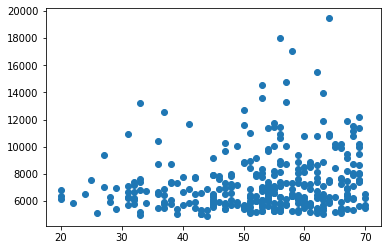

In [29]:
plt.scatter(healthy_ages, sods)

In [33]:
#get just the healthy samples to get their smoking status
meta_healthy=meta[meta['Disease state']=='Normal'] 

In [34]:
meta_healthy

Unnamed: 0  Age Disease state Gender Smoking Status
8    GSM1051533   55        Normal      m        current
9    GSM1051534   37        Normal      m          never
10   GSM1051535   31        Normal      m             na
11   GSM1051536   59        Normal      m             ex
12   GSM1051537   49        Normal      m             ex
..          ...  ...           ...    ...            ...
684  GSM1052209   63        Normal      f             ex
685  GSM1052210   63        Normal      f          never
686  GSM1052211   46        Normal      f          never
687  GSM1052212   64        Normal      f             ex
688  GSM1052213   36        Normal      f          never

[335 rows x 5 columns]

In [66]:
col = np.where(meta_healthy['Smoking Status'] == 'current','r','b')

Text(0.5, 1.0, 'Noise score separated by smoking status')

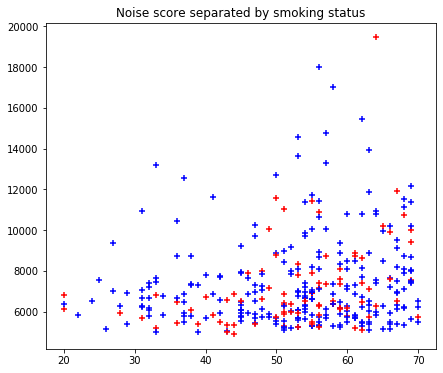

In [67]:
plt.figure(figsize=(7, 6))
plt.scatter(healthy_ages, sods, marker='+', c=col)
plt.title('Noise score separated by smoking status')

In [68]:
arts

ID_REF cg00000029 cg00000108 cg00000109 cg00000165 cg00000236 cg00000289  \
0         0.61217   0.914826    0.83904   0.245717   0.722759    0.49539   
1        0.546805   0.928505    0.79417   0.231993   0.726394   0.550695   
2        0.547603     0.9522   0.836903   0.236521   0.741359   0.599805   
3        0.543228   0.918154    0.87223   0.275106   0.734095   0.588784   
4        0.592892   0.925595   0.862109   0.262474   0.763301   0.534279   
..            ...        ...        ...        ...        ...        ...   
684      0.536858    0.88781   0.813071   0.245218    0.69296   0.596998   
685      0.561419   0.606021   0.468836   0.233812   0.609028   0.412608   
686      0.498656   0.900134   0.826276   0.202015   0.736256   0.633133   
687      0.463987   0.899416   0.774397   0.205924   0.716105   0.531887   
688      0.524456   0.847742   0.839801   0.227722   0.710249   0.619151   

ID_REF cg00000292 cg00000321 cg00000363 cg00000622  ... cg27665767 cg27665769  \
0        0.843838   0.284404   0.349748   0.026154  ...   0.446077   0.489648   
1        0.835045   0.303656   0.376803   0.029579  ...   0.550344   0.512258   
2        0.799254    0.28297   0.340147    0.02019  ...   0.454097   0.491419   
3        0.834887   0.275759   0.373968   0.024721  ...   0.475548   0.523669   
4        0.798148   0.293791   0.339344   0.027958  ...   0.450429   0.520976   
..            ...        ...        ...        ...  ...        ...        ...   
684      0.801524   0.354558     0.3632   0.023436  ...   0.393054   0.486773   
685      0.866637   0.330733   0.234687   0.030648  ...   0.317663    0.44274   
686      0.797516    0.28322   0.377648   0.042083  ...   0.451921   0.487314   
687      0.819985   0.304506   0.423209   0.033245  ...   0.445982   0.463636   
688      0.786583   0.320706   0.365851   0.034055  ...   0.496275   0.454514   

ID_REF cg27665808 cg27665823 cg27665829 cg27665860 cg27665925 cg27665985  \
0        0.500373   0.782521   0.821379   0.830623   0.016101   0.301229   
1        0.566108   0.776098   0.873901   0.809938    0.02637   0.319836   
2        0.526089   0.788002   0.877578   0.842972   0.029424   0.219531   
3        0.503682   0.789255   0.874956   0.851444   0.033978   0.309806   
4        0.528373   0.787528   0.842272   0.840259   0.031233   0.350814   
..            ...        ...        ...        ...        ...        ...   
684      0.545007   0.802742   0.843232   0.791482   0.033285   0.309354   
685      0.357039   0.748125   0.445839   0.854875   0.029057   0.325624   
686      0.664668    0.76252   0.826271   0.791502   0.032234   0.345656   
687      0.527382   0.809387   0.825726   0.801703    0.03235    0.29834   
688        0.5676   0.800137   0.752906   0.790506   0.046541   0.362019   

ID_REF cg27666046 cg27666123  
0        0.540508   0.812518  
1        0.501222   0.796767  
2        0.613028   0.840333  
3        0.507978   0.837349  
4        0.518035   0.786272  
..            ...        ...  
684      0.497708   0.781353  
685      0.570606    0.53084  
686      0.490546   0.790438  
687      0.502852   0.733703  
688      0.437418   0.793075  

[689 rows x 482421 columns]

In [168]:
col_dis = np.where(meta['Disease state'] == 'rheumatoid arthritis')

In [152]:
constants=arts[het_cgs]

In [74]:
#get the arthritis samples with the constant  CpGs
rh = constants.iloc[col_dis[0].tolist(),:]
rh_ages = arts_ages.iloc[col_dis[0].tolist(),:]
art_adfms = noise_predict(rh,means,mads)
art_sods=art_adfms.sum(axis=1)

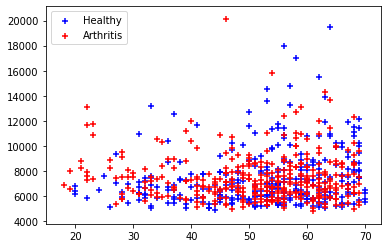

In [80]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(healthy_ages, sods, c='b', marker='+', label='Healthy')
ax1.scatter(rh_ages, art_sods,c='r', marker='+', label='Arthritis')
plt.legend(loc='upper left');
plt.show()

In [24]:
col = np.where(meta['Disease state'] == 'Normal','b','r')

Text(0.5, 1.0, 'cg07173783')

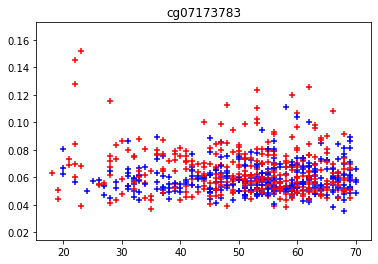

In [49]:
#Check the beta value distribution of a random CpG in the list
n =random.randint(1,len(tl))
plt.scatter(arts_ages.Age.astype(float),arts[tl[n]], c=col, marker='+')
plt.title(tl[n])

In [44]:
l = ['cg27076139', 'cg04502985', 'cg10775050', 'cg21981706', 'cg00227225', 'cg14844341', 'cg19871631',
     'cg21938148', 'cg01775260', 'cg07158797', 'cg05598477', 'cg25870025', 'cg26688241', 'cg02430347',
     'cg07941529', 'cg11350833', 'cg12697603', 'cg18961791', 'cg08272286', 'cg25137711', 'cg09009410',
     'cg04922286', 'cg20693580', 'cg04554033', 'cg12658387', 'cg25976672', 'cg19523118', 'cg24216220',
     'cg26365690', 'cg14239811', 'cg03020810', 'cg12301921', 'cg02775417', 'cg02809746', 'cg06585820',
     'cg05099493', 'cg27082486', 'cg13301933', 'cg08729031', 'cg00730653', 'cg07209546', 'cg13652281',
     'cg00413099', 'cg06682197', 'cg18780412', 'cg26257145', 'cg24364143', 'cg17940821', 'cg11821817',
     'cg05853632', 'cg15289316', 'cg13823553', 'cg20183619', 'cg26831415', 'cg24990131', 'cg08173692',
     'cg17178888', 'cg16761581', 'cg06310816', 'cg11939346', 'cg07478468', 'cg05540639', 'cg10490202',
     'cg23567562', 'cg02496256', 'cg14881179', 'cg00870269', 'cg26158897', 'cg04711050', 'cg00078759',
     'cg22156700', 'cg25447019', 'cg02180633', 'cg21726327', 'cg09593028', 'cg23634087', 'cg03004714',
     'cg27441228', 'cg13311142', 'cg12364556', 'cg01948229', 'cg10153031', 'cg18755204', 'cg23172086',
     'cg02512074', 'cg08811349', 'cg13822008', 'cg11767442', 'cg07173783', 'cg08478622', 'cg19980431' ]

In [34]:
tl = ['cg22156700', 'cg25447019', 'cg02180633', 'cg21726327', 'cg09593028', 'cg23634087', 'cg03004714',
     'cg27441228', 'cg13311142', 'cg12364556', 'cg01948229', 'cg10153031', 'cg18755204', 'cg23172086',
     'cg02512074', 'cg08811349', 'cg13822008', 'cg11767442', 'cg07173783', 'cg08478622', 'cg19980431' ]

In [890]:
len(l)

91

In [892]:
healthy=healthy[tl]

In [893]:
#get the normalized absolute differences from the means
adfms, means, mads = get_adfm(healthy, healthy_ages.Age,tl)

In [894]:
sods = adfms.sum(axis=1)

In [895]:
#get the arthritis samples with the constant  CpGs
rh = constants.iloc[col_dis[0].tolist(),:]
rh_ages = arts_ages.iloc[col_dis[0].tolist(),:]

In [896]:
rh = rh[tl]

In [897]:
art_adfms = noise_predict(rh,means,mads)
art_sods=art_adfms.sum(axis=1)

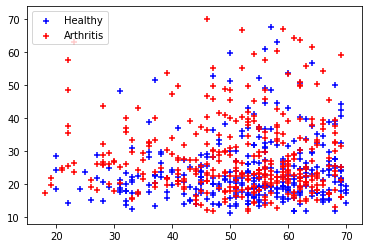

In [902]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(healthy_ages, sods, c='b', marker='+', label='Healthy')
ax1.scatter(rh_ages, art_sods,c='r', marker='+', label='Arthritis')
plt.legend(loc='upper left');
plt.show()

In [93]:
x = healthy[het_cgs[0]].tolist()

In [173]:
x = sm.add_constant(x)

In [174]:
 #fit regression model
model = sm.OLS(healthy_ages.Age.astype(float), x).fit()
        
  #create instance of influence
influence = model.get_influence()
        #obtain standardized residuals
standardized_residuals = influence.resid_studentized_internal

In [181]:
standardized_residuals = abs(standardized_residuals)

In [186]:
def get_residuals(df, ages, cgs):
    
    residuals = pd.DataFrame()
    
    for cg in cgs:
    
        x = df[cg].tolist()

        #add constant to predictor variables
        x = sm.add_constant(x)

        #fit regression model
        model = sm.OLS(ages, x).fit()
        
        #create instance of influence
        influence = model.get_influence()
        #obtain standardized residuals
        standardized_residuals = abs(influence.resid_studentized_internal)
        
        residuals[cg] = standardized_residuals
        
    return residuals            

In [399]:
adfm, means, sds = get_adfm(healthy, healthy_ages.Age, het_cgs)

In [404]:
sods = adfm.sum(axis=1)

In [401]:
#get the arthritis samples with the constant  CpGs
rh = arts.iloc[col_dis[0].tolist(),:]
rh_ages = arts_ages.iloc[col_dis[0].tolist(),:]

In [403]:
rh = rh[het_cgs]

In [405]:
art_adfms = noise_predict(rh,means,sds)
art_sods=art_adfms.sum(axis=1)

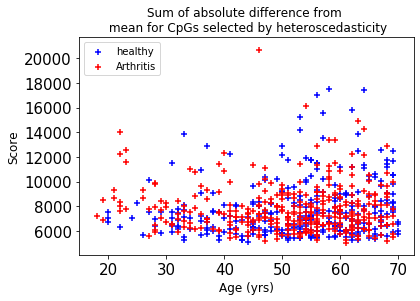

In [406]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(healthy_ages, sods, c='b', marker="+", label='healthy')
ax1.scatter(rh_ages,art_sods, c='r', marker="+", label='Arthritis')
plt.legend(loc='upper left');
plt.xlabel('Age (yrs)',fontsize=12)
plt.ylabel('Score',fontsize=12)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.title('Sum of absolute difference from \n mean for CpGs selected by heteroscedasticity')

plt.show()

C:\Users\Colin\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\Colin\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\Colin\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


Text(0.5, 1.0, 'Sum of abs. diffs from mean: r=0.15, \n p=0.007, MAE=7590.3 yrs')

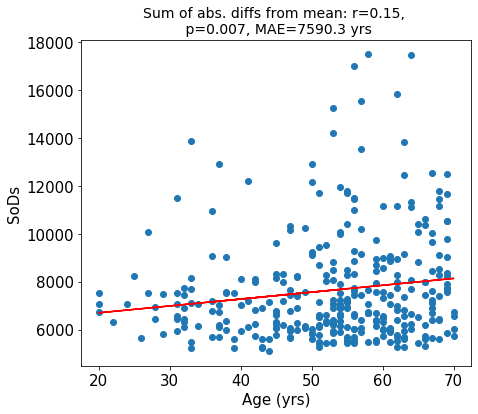

In [281]:
Y = healthy_ages.Age.astype(float)
regression = stats.linregress(Y, sods.tolist())
slope, intercept, rvalue, pvalue, stderr = regression

pred = slope * Y + intercept

plt.figure(figsize=(7, 6))
plt.scatter(Y, sods)
plt.plot(Y, pred, color='red')

plt.xlabel('Age (yrs)',fontsize=15)
plt.ylabel('SoDs',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
mae = metrics.mean_absolute_error(Y, sods.tolist())

plt.title('Sum of abs. diffs from mean: r={:.2f}, \n p={:.1g}, MAE={:.1f} yrs'.format(rvalue, pvalue, mae),fontsize=14)

# Try elastic net to identify the CpGs with best linearity

In [282]:
scaler=StandardScaler()
        #Split the dataset into training and test subsets 
adfm_train, adfm_test, age_train, age_test = train_test_split(adfm, Y, test_size=0.2, random_state=42)

fit = scaler.fit(adfm_train)
adfm_train = fit.transform(adfm_train)
    
    
elastic_netCV = ElasticNetCV(l1_ratio = 0.5, n_alphas = 10, cv = 10, n_jobs=-1, random_state = 10,
                                 max_iter=2000, tol = 0.001, selection='cyclic')

#Train the model. Runtime ~10 mins
model = elastic_netCV.fit(adfm_train, age_train)
    
#Make predictions on test set data
adfm_test = fit.transform(adfm_test)

preds = elastic_netCV.predict(adfm_test)
     
# joblib.dump(elastic_netCV, 'iter{} model.joblib'.format(iteration))

In [286]:
coeffs = pd.DataFrame(elastic_netCV.coef_)
coeffs = coeffs[(coeffs.T != 0).any()]
    #Get significant CpGs and their indices

colnames = pd.DataFrame(adfm.columns)

sig_cpgs = colnames.iloc[coeffs.index]
    #Make list of significant CpGs 
cpg_list = sig_cpgs.iloc[:,0].tolist()


In [287]:
cpg_list

['cg26577729']

Text(0.5, 1.0, 'EN on ADFMs: r=0.00, \n p=1, MAE=9.8 yrs')

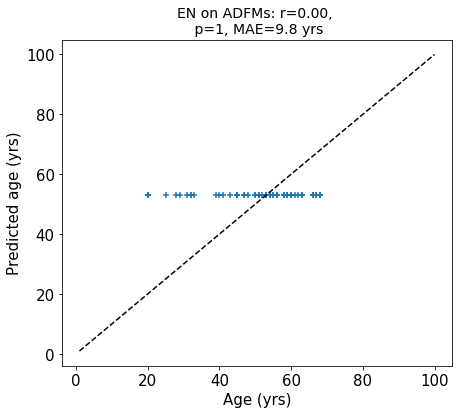

In [283]:
regression = stats.linregress(age_test, preds)
slope, intercept, rvalue, pvalue, stderr = regression
pred = slope * age_test + intercept

plt.figure(figsize=(7, 6))
plt.scatter(age_test, preds, marker='+')
# plt.plot(Y_test, pred, color='red')
plt.plot(np.linspace(1,100,100), np.linspace(1,100,100), color='k', linestyle = 'dashed')

plt.xlabel('Age (yrs)',fontsize=15)
plt.ylabel('Predicted age (yrs)',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
mae = metrics.mean_absolute_error(age_test, preds)

plt.title('EN on ADFMs: r={:.2f}, \n p={:.1g}, MAE={:.1f} yrs'.format(rvalue, pvalue, mae),fontsize=14)
# plt.savefig('Hannum figures/Figure x/Combined WB test', dpi=300)

In [241]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [269]:
methyl_train, methyl_test, age_train, age_test = train_test_split(adfm, healthy_ages.Age, test_size=0.2, random_state=40)

scaler = StandardScaler()
fit = scaler.fit(methyl_train)
methyl_train = fit.transform(methyl_train)

# age_train=age_train.values.ravel()
predictor = LinearRegression(fit_intercept=True).fit(methyl_train, age_train)
methyl_test = fit.transform(methyl_test)
# age_test=age_test.values.ravel()
preds = predictor.predict(methyl_test)

regression = stats.linregress(preds.astype(float), age_test.astype(float))
slope, intercept, rvalue, pvalue, stderr = regression


C:\Users\Colin\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\Colin\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


Text(0.5, 1.0, 'Noise clock on Test: r=0.17, \n p=0.2, MAE=9.8 yrs')

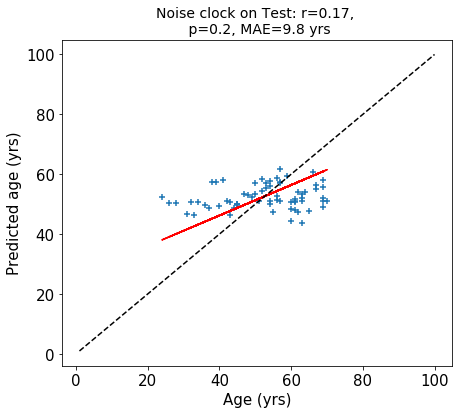

In [273]:
pred = slope * age_test.astype(float) + intercept

plt.figure(figsize=(7, 6))
plt.scatter(age_test.astype(float), preds, marker='+')
plt.plot(age_test.astype(float), pred, color='red')
plt.plot(np.linspace(1,100,100), np.linspace(1,100,100), color='k', linestyle = 'dashed')

plt.xlabel('Age (yrs)',fontsize=15)
plt.ylabel('Predicted age (yrs)',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
mae = metrics.mean_absolute_error(age_test.astype(float), preds)

plt.title('Noise clock on Test: r={:.2f}, \n p={:.1g}, MAE={:.1f} yrs'.format(rvalue, pvalue, mae),fontsize=14)
# plt.savefig('Hannum figures/Figure x/Combined WB test', dpi=300)

In [237]:
preds = model.predict(sods)

In [238]:
preds

GSM1051533    46.056720
GSM1051534    45.099037
GSM1051535    41.296526
GSM1051536    62.517121
GSM1051537    39.490711
                ...    
GSM1052209    33.888375
GSM1052210    88.817297
GSM1052211    46.146934
GSM1052212    71.390087
GSM1052213    58.413669
Length: 335, dtype: float64

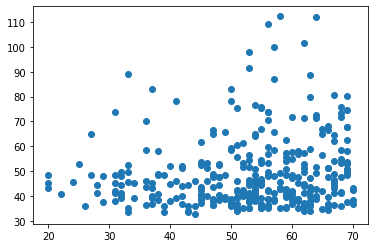

In [239]:
plt.scatter(healthy_ages.Age.astype(float),preds)

In [187]:
resids = get_residuals(healthy, healthy_ages.Age.astype(float), het_cgs)

In [188]:
resids

cg18062138  cg20725157  cg15427448  cg24726668  cg09901574  cg21709909  \
0      0.157455    0.266358    0.278569    0.169871    0.122938    0.169020   
1      1.384128    1.290055    1.270880    1.425091    1.317787    1.397793   
2      1.916979    1.820093    1.867050    1.900916    1.915873    1.871648   
3      0.562732    0.684904    0.640699    0.478467    0.656346    0.572725   
4      0.325277    0.128077    0.368599    0.365204    0.361426    0.340464   
..          ...         ...         ...         ...         ...         ...   
330    0.876142    1.000413    0.875231    0.936991    0.974809    0.870178   
331    0.911156    0.315801    0.827954    0.770924    1.020555    0.907445   
332    0.602861    0.625666    0.610512    0.609691    0.594054    0.638108   
333    0.964519    0.763655    0.533510    0.977780    1.076887    0.982530   
334    1.490726    1.489541    1.561500    1.495479    1.571884    1.522122   

     cg18595957  cg24764310  cg01301637  cg08322240  ...  cg17576288  \
0      0.192660    0.176590    0.155009    0.406795  ...    0.080537   
1      1.366703    1.382946    1.221816    1.514891  ...    1.287335   
2      1.893846    1.901016    1.798449    2.014956  ...    1.597096   
3      0.576149    0.611175    0.661153    0.744725  ...    0.898068   
4      0.347913    0.326487    0.204051    0.252075  ...    0.511483   
..          ...         ...         ...         ...  ...         ...   
330    0.932738    0.866363    1.112385    0.812501  ...    0.861426   
331    0.922294    0.558101    0.977714    1.721904  ...    0.811148   
332    0.608200    0.626535    0.797969    1.034339  ...    1.012087   
333    0.977797    0.974963    0.372256    0.035252  ...    0.528922   
334    1.462747    1.551579    1.362050    1.815064  ...    1.517490   

     cg10699215  cg17031656  cg20745910  cg20744625  cg19258665  cg07035503  \
0      0.220135    0.219813    0.210982    0.222839    0.237916    0.326833   
1      1.259512    1.384327    1.429962    1.045687    1.255577    1.193395   
2      1.770986    1.919443    1.914691    1.755787    1.921266    1.752258   
3      0.508715    0.649694    0.580919    0.753751    0.569222    0.904059   
4      0.296758    0.255930    0.279528    0.256869    0.346491    0.279984   
..          ...         ...         ...         ...         ...         ...   
330    0.814074    0.816118    0.888732    0.875161    0.947612    0.937512   
331    0.777256    0.753174    0.779166    1.150654    0.899792    0.983809   
332    0.613963    0.599604    0.716905    0.872362    0.624741    0.748021   
333    0.933615    0.990361    0.825719    0.597691    0.899509    0.849517   
334    1.685571    1.498407    1.540112    1.571901    1.454921    1.331986   

     cg10995082  cg11154747  cg14784788  
0      0.188153    0.335595    0.180822  
1      1.090425    1.253850    1.393055  
2      1.733932    1.771007    1.872874  
3      0.844557    0.703534    0.608537  
4      0.300889    0.216350    0.319385  
..          ...         ...         ...  
330    0.840529    0.993579    0.891161  
331    1.045057    0.709149    0.865673  
332    0.535886    0.778444    0.663051  
333    0.340897    0.505461    0.955048  
334    1.474462    1.552457    1.558216  

[335 rows x 6565 columns]

In [191]:
sors = resids.sum(axis=1)

In [193]:
healthy_ages.Age.mean()`

52.75820895522388

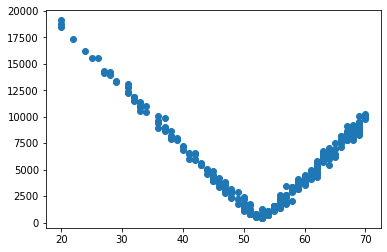

In [192]:
plt.scatter(healthy_ages.Age.astype(float), sors)

In [190]:
healthy_ages

Age
8     55
9     37
10    31
11    59
12    49
..   ...
684   63
685   63
686   46
687   64
688   36

[335 rows x 1 columns]

In [182]:
df = pd.DataFrame()

In [183]:
df['new'] = standardized_residuals

In [184]:
df

new
0    0.157455
1    1.384128
2    1.916979
3    0.562732
4    0.325277
..        ...
330  0.876142
331  0.911156
332  0.602861
333  0.964519
334  1.490726

[335 rows x 1 columns]

In [139]:
ws = pd.read_pickle('Datasets/Werner/WS.pkl')

In [143]:
len(set(ws.columns.tolist())&set(het_cgs))

6565

In [100]:
data = pd.read_excel(r'betas_fixed.xlsx')

In [101]:
ages = pd.read_excel(r'Training/full ages.xlsx')

In [103]:
data1=data.drop(data.columns[0], axis=1)

In [104]:
data1

0         1         2         3         4         5         6     \
0      0.826452  0.786005  0.821569  0.800461  0.846929  0.861608  0.681818   
1      0.664997  0.776752  0.718688  0.773340  0.760058  0.794964  0.723584   
2      0.044991  0.065413  0.037126  0.047140  0.031929  0.057937  0.068399   
3      0.157715  0.194652  0.202437  0.176671  0.146927  0.156609  0.147871   
4      0.077353  0.091298  0.080609  0.107725  0.130279  0.098889  0.117026   
...         ...       ...       ...       ...       ...       ...       ...   
24988  0.081038  0.111551  0.101114  0.070997  0.097285  0.066596  0.096225   
24989  0.197167  0.377573  0.272153  0.341921  0.270388  0.222771  0.363886   
24990  0.034734  0.039018  0.058072  0.049498  0.029971  0.038705  0.026374   
24991  0.077491  0.059095  0.110436  0.076674  0.056054  0.080700  0.057999   
24992  0.028459  0.023167  0.028143  0.029572  0.034285  0.033207  0.019537   

           7         8         9     ...      1461      1462      1463  \
0      0.784737  0.826786  0.746127  ...  0.789455  0.851453  0.819372   
1      0.742225  0.746415  0.736423  ...  0.848082  0.896909  0.884391   
2      0.057447  0.064459  0.048139  ...  0.074806  0.047034  0.052636   
3      0.132038  0.086012  0.254956  ...  0.209658  0.199703  0.221178   
4      0.093538  0.122043  0.089337  ...  0.072509  0.064817  0.045294   
...         ...       ...       ...  ...       ...       ...       ...   
24988  0.068592  0.075609  0.057486  ...  0.057506  0.049101  0.042336   
24989  0.362355  0.351474  0.272481  ...  0.397974  0.401969  0.423011   
24990  0.056011  0.028895  0.029263  ...  0.049433  0.051320  0.052278   
24991  0.066825  0.073723  0.063854  ...  0.057330  0.062580  0.050441   
24992  0.028023  0.021568  0.024204  ...  0.087793  0.107549  0.092944   

           1464      1465      1466      1467      1468      1469      1470  
0      0.876083  0.863835  0.825768  0.806713  0.804045  0.831365  0.863806  
1      0.901642  0.858602  0.886406  0.838420  0.858297  0.879480  0.938295  
2      0.064674  0.067072  0.050502  0.062197  0.063558  0.088794  0.048276  
3      0.156754  0.089901  0.188799  0.134851  0.139275  0.133151  0.151297  
4      0.058157  0.044315  0.073174  0.041018  0.066005  0.071172  0.047214  
...         ...       ...       ...       ...       ...       ...       ...  
24988  0.063715  0.013764  0.055537  0.040734  0.053617  0.045941  0.020821  
24989  0.274674  0.252393  0.335544  0.352893  0.467827  0.342223  0.350809  
24990  0.054645  0.034206  0.072649  0.077399  0.077366  0.071106  0.053898  
24991  0.065717  0.033017  0.054728  0.059816  0.063124  0.048240  0.035643  
24992  0.101768  0.078742  0.113743  0.125117  0.090822  0.096672  0.096693  

[24993 rows x 1471 columns]

In [112]:
ages

ID_REF  Age
0     GSM1007129   34
1     GSM1007130   31
2     GSM1007131   23
3     GSM1007132   31
4     GSM1007133   23
...          ...  ...
1466   GSM990623   78
1467   GSM990624   71
1468   GSM990625   68
1469   GSM990626   61
1470   GSM990627   73

[1471 rows x 2 columns]

In [105]:
#need to take care of any values that are greater than 1 because we use the betas as probabilities; values greater than 1 are likely errors
for col in range(len(data.columns[1:])):
    data1[col].values[data1[col].values > 1] = 0.00001

In [106]:
#we're taking logs so we need to regularize the data; the value of 0.00001 is arbitrary 
for col in range(len(data.columns[1:])):
    data1[col].values[data1[col].values <= 0 ] = 0.00001

In [170]:
ent_sum = 0 
for j in range(24993):
        ent_sum = ent_sum + data1.iloc[j,1469]*log(data1.iloc[j,1469],10)
        
ent_sum = ent_sum/(24993*log(0.5, 10))

In [171]:
ent_sum

0.27912510944755825

In [123]:
ents = []

for col in range(len(data.columns[1:])):
    ent_sum = 0
    for j in range(len(data1.iloc[:,0])):
        ent_sum = ent_sum + data1.iloc[j,col]*log(data1.iloc[j,col],2)+(1-data1.iloc[j,col])*log(1-data1.iloc[j,col],2)
        
    ent_sum = ent_sum/(24993*log(0.5, 2))
    
    ents = ents + [ent_sum]
    
        

In [173]:
ents1 = []

for col in range(len(data.columns[1:])):
    ent_sum = 0
    for j in range(len(data1.iloc[:,0])):
        ent_sum = ent_sum + data1.iloc[j,col]*log(data1.iloc[j,col],2)
        
    ent_sum = ent_sum/(24993*log(0.5, 2))
    
    ents1 = ents1 + [ent_sum]

In [174]:
ents1

[0.2576869454773799,
 0.26997892822192693,
 0.26607026131783224,
 0.25578134544266934,
 0.2626047605458549,
 0.25806708604963013,
 0.2627774715474474,
 0.25709759665735954,
 0.25958461134149435,
 0.25599750616275263,
 0.2511357800833801,
 0.2453042825539052,
 0.2626593639315346,
 0.26297914623681756,
 0.2550775424101148,
 0.266600554475548,
 0.26934308618539604,
 0.2669730307385576,
 0.25541667537161394,
 0.25878137282609476,
 0.2561608118126287,
 0.25761177673175056,
 0.25203832797430203,
 0.2539068920108594,
 0.2634482841765756,
 0.2652192763628378,
 0.26329427298800684,
 0.2722001825039142,
 0.26754750068059135,
 0.510191903309825,
 0.2548581288231216,
 0.26609191849115127,
 0.2473704828458756,
 0.2575968762358673,
 0.26332125976604037,
 0.26252586177183485,
 0.2574798033415149,
 0.25479061656445723,
 0.2579188919485558,
 0.24541025982117476,
 0.2508153809282458,
 0.24782614628913466,
 0.2481398699556104,
 0.25165683425734947,
 0.5169281668371986,
 0.2578990741190633,
 0.25857151924

In [140]:
test = ages.iloc[:,1].to_list()

In [176]:
d = {'Full Entropy': ents, 'Half Entropy': ents1, 'Age': test}
d

{'Full Entropy': [0.45306330141003287,
  0.47678063599100584,
  0.4675827229474897,
  0.4522254041083047,
  0.4627503831781798,
  0.4568450800286236,
  0.4623656117957971,
  0.4542744021411307,
  0.4576648199402974,
  0.4518103769439726,
  0.44319850464633137,
  0.43434014021826295,
  0.46289222452835616,
  0.4643167527752658,
  0.450171319350907,
  0.46927224121684313,
  0.4742751552337204,
  0.46873508203799763,
  0.45100028401255454,
  0.4547991566577526,
  0.4517174903642038,
  0.4530990178941297,
  0.44377312963850785,
  0.4472771848967641,
  0.46354305969221943,
  0.4676347105999701,
  0.46620578631518544,
  0.48027002072911573,
  0.47350666343616005,
  0.8871824626409155,
  0.4518479112134356,
  0.4683963458078291,
  0.43496792406924584,
  0.4528453490628642,
  0.4657074073147732,
  0.46476083560699105,
  0.4535091957167776,
  0.451135527476278,
  0.4545804931989048,
  0.4321924078861904,
  0.4413369717063385,
  0.4371933787907484,
  0.4404166947165137,
  0.44360381676803057,
  

In [177]:
GSM_entropies = pd.DataFrame(d, index = ages.ID_REF)

In [178]:
GSM_entropies

Full Entropy  Half Entropy  Age
ID_REF                                     
GSM1007129      0.453063      0.257687   34
GSM1007130      0.476781      0.269979   31
GSM1007131      0.467583      0.266070   23
GSM1007132      0.452225      0.255781   31
GSM1007133      0.462750      0.262605   23
...                  ...           ...  ...
GSM990623       0.495055      0.280189   78
GSM990624       0.489888      0.278411   71
GSM990625       0.484853      0.275579   68
GSM990626       0.493006      0.279125   61
GSM990627       0.460661      0.261707   73

[1471 rows x 3 columns]

In [179]:
GSM_entropies.to_excel('GSM entropies.xlsx')

In [187]:
GSM_entropies['Half Entropy'].

ID_REF
GSM1007129    0.257687
GSM1007130    0.269979
GSM1007131    0.266070
GSM1007132    0.255781
GSM1007133    0.262605
                ...   
GSM990623     0.280189
GSM990624     0.278411
GSM990625     0.275579
GSM990626     0.279125
GSM990627     0.261707
Name: Half Entropy, Length: 1471, dtype: float64

In [197]:
xtrain = GSM_entropies['Full Entropy'].to_list()

In [193]:
ytrain = GSM_entropies.Age.to_list()

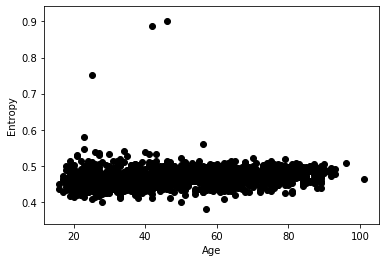

In [198]:
plt.scatter(ytrain, xtrain,  color='black')
#plt.plot(ents, preds, color='blue', linewidth=3)

plt.xlabel('Age')
plt.ylabel('Entropy')


plt.show()

# Get global variances

In [199]:
sample_variances = data1.var()

In [200]:
sample_variances

0       0.106188
1       0.102935
2       0.105468
3       0.110856
4       0.105832
          ...   
1466    0.108736
1467    0.109190
1468    0.108118
1469    0.108014
1470    0.111537
Length: 1471, dtype: float64

In [203]:
cpg_variances = data1.var(axis=1)

In [204]:
cpg_variances

0        0.002401
1        0.008531
2        0.000962
3        0.002850
4        0.000900
           ...   
24988    0.001529
24989    0.003979
24990    0.000364
24991    0.000522
24992    0.000723
Length: 24993, dtype: float64

In [238]:
top_variances = sorted(range(len(cpg_variances)), key=lambda i: cpg_variances[i])[-100:]

In [239]:
top_100 = data1.iloc[top_variances]

In [240]:
top_100

0         1         2         3         4         5         6     \
23257  0.334038  0.614709  0.621339  0.545198  0.409283  0.572414  0.629565   
3420   0.627329  0.556136  0.554023  0.610929  0.624815  0.666250  0.607076   
22534  0.956686  0.939958  0.950857  0.951480  0.949433  0.908995  0.957473   
10086  0.554131  0.398649  0.483240  0.476336  0.415493  0.522411  0.449906   
15751  0.667429  0.567367  0.678362  0.703867  0.534314  0.557037  0.520755   
...         ...       ...       ...       ...       ...       ...       ...   
19834  0.873062  0.866953  0.813648  0.810739  0.843528  0.852763  0.874931   
21386  0.781890  0.749070  0.697739  0.617012  0.814625  0.685628  0.602680   
468    0.765223  0.776443  0.702592  0.761136  0.749467  0.759288  0.732212   
3669   0.798858  0.788117  0.815409  0.788537  0.732331  0.774429  0.797241   
2897   0.747194  0.753465  0.710253  0.679048  0.770913  0.788801  0.797771   

           7         8         9     ...      1461      1462      1463  \
23257  0.504132  0.581433  0.529968  ...  0.909792  0.905358  0.897573   
3420   0.555730  0.628319  0.643154  ...  0.936598  0.980282  0.937123   
22534  0.916702  0.960200  0.953850  ...  0.599673  0.605427  0.672648   
10086  0.512727  0.601318  0.494436  ...  0.838806  0.883732  0.902251   
15751  0.623123  0.560932  0.509434  ...  0.983641  0.944844  0.969747   
...         ...       ...       ...  ...       ...       ...       ...   
19834  0.855190  0.859573  0.837035  ...  0.194878  0.190238  0.149107   
21386  0.805997  0.853935  0.705925  ...  0.069976  0.070032  0.065871   
468    0.834662  0.819512  0.761989  ...  0.039007  0.076208  0.065832   
3669   0.758266  0.866800  0.757969  ...  0.077267  0.078876  0.076933   
2897   0.775615  0.804869  0.712777  ...  0.035429  0.040792  0.043462   

           1464      1465      1466      1467      1468      1469      1470  
23257  0.887496  0.941004  0.914827  0.921546  0.879008  0.884786  0.929708  
3420   0.942825  0.979483  0.931303  0.894370  0.900718  0.955877  0.926296  
22534  0.687685  0.705486  0.707119  0.661406  0.595366  0.605075  0.520681  
10086  0.885544  0.822442  0.833673  0.920391  0.864472  0.849623  0.823744  
15751  0.973366  0.925735  0.887706  0.909602  0.917328  0.945950  0.940349  
...         ...       ...       ...       ...       ...       ...       ...  
19834  0.177053  0.099660  0.147069  0.188299  0.148190  0.157565  0.135191  
21386  0.056353  0.029165  0.060854  0.059945  0.063298  0.056102  0.042123  
468    0.054515  0.056575  0.062276  0.060943  0.063428  0.052014  0.053247  
3669   0.068522  0.060893  0.080448  0.070358  0.063148  0.080460  0.091204  
2897   0.042947  0.028552  0.038987  0.024418  0.037912  0.031815  0.017918  

[100 rows x 1471 columns]

In [241]:
cpg_variances[3669]

0.11737591451756735

In [217]:
top_100.iloc[0]

0       0.334038
1       0.614709
2       0.621339
3       0.545198
4       0.409283
          ...   
1466    0.914827
1467    0.921546
1468    0.879008
1469    0.884786
1470    0.929708
Name: 23257, Length: 1471, dtype: float64

In [218]:
ents_100 = []

for col in range(len(top_100.columns)):
    ent_sum = 0
    for j in range(len(top_100.iloc[:,0])):
        ent_sum = ent_sum + top_100.iloc[j,col]*log(top_100.iloc[j,col],2)+(1-top_100.iloc[j,col])*log(1-top_100.iloc[j,col],2)
        
    ent_sum = ent_sum/(100*log(0.5, 2))
    
    ents_100 = ents_100 + [ent_sum]
    

In [221]:
len(ents_100)

1471

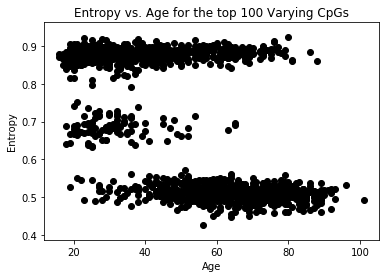

In [222]:
plt.scatter(ytrain, ents_100,  color='black')
#plt.plot(ents, preds, color='blue', linewidth=3)

plt.xlabel('Age')
plt.ylabel('Entropy')
plt.title('Entropy vs. Age for the top 100 Varying CpGs')

plt.show()

In [223]:
top_variances = sorted(range(len(cpg_variances)), key=lambda i: cpg_variances[i])[-50:]
top_50 = data1.iloc[top_variances]

ents_50 = []

for col in range(len(top_50.columns)):
    ent_sum = 0
    for j in range(len(top_50.iloc[:,0])):
        ent_sum = ent_sum + top_50.iloc[j,col]*log(top_50.iloc[j,col],2)+(1-top_50.iloc[j,col])*log(1-top_50.iloc[j,col],2)
        
    ent_sum = ent_sum/(50*log(0.5, 2))
    
    ents_50 = ents_50 + [ent_sum]

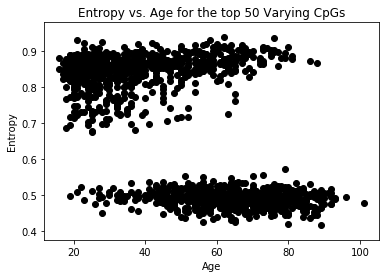

In [224]:
plt.scatter(ytrain, ents_50,  color='black')
#plt.plot(ents, preds, color='blue', linewidth=3)

plt.xlabel('Age')
plt.ylabel('Entropy')
plt.title('Entropy vs. Age for the top 50 Varying CpGs')

plt.show()

In [242]:
top_variances = sorted(range(len(cpg_variances)), key=lambda i: cpg_variances[i])[-20:]
top_20 = data1.iloc[top_variances]

ents_20 = []

for col in range(len(top_20.columns)):
    ent_sum = 0
    for j in range(len(top_20.iloc[:,0])):
        ent_sum = ent_sum + top_20.iloc[j,col]*log(top_20.iloc[j,col],2)+(1-top_20.iloc[j,col])*log(1-top_20.iloc[j,col],2)
        
    ent_sum = ent_sum/(20*log(0.5, 2))
    
    ents_20 = ents_20 + [ent_sum]

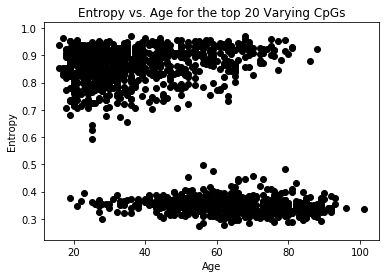

In [243]:
plt.scatter(ytrain, ents_20,  color='black')
#plt.plot(ents, preds, color='blue', linewidth=3)

plt.xlabel('Age')
plt.ylabel('Entropy')
plt.title('Entropy vs. Age for the top 20 Varying CpGs')

plt.show()

In [399]:
#get the indices for the samples that are 80-101 yrs
old_ages = sorted(range(len(ytrain)), key=lambda i: ytrain[i])[-386:]


In [400]:
ages.iloc[old_ages]

ID_REF  Age
510   GSM1007639   65
553   GSM1007682   65
573   GSM1007702   65
649   GSM1007778   65
692   GSM1007821   65
...          ...  ...
1463   GSM990620   92
837    GSM989849   93
1424   GSM990581   93
870    GSM989882   96
851    GSM989863  101

[386 rows x 2 columns]

In [401]:
#make new dataframe for the 80-101 yr old samples 
old_betas = data1[old_ages]

In [390]:
#get indices for the 16-25 yrs cohort
young_ages = sorted(range(len(ytrain)), key=lambda i: ytrain[i])[:385]
ages.iloc[young_ages]

ID_REF  Age
338   GSM1007467   16
509   GSM1007638   16
35    GSM1007164   17
207   GSM1007336   17
308   GSM1007437   17
...          ...  ...
743   GSM1009683   30
752   GSM1009692   30
785   GSM1009725   30
980    GSM989992   30
1377   GSM990534   30

[385 rows x 2 columns]

In [391]:
#make new data frame for the betas of the young cohort
young_betas = data1[young_ages]

In [392]:
young_betas

338       509       35        207       308       470       14    \
0      0.760805  0.854491  0.803974  0.862075  0.803411  0.742942  0.851069   
1      0.769374  0.724490  0.767061  0.828914  0.772836  0.773296  0.781142   
2      0.045161  0.048403  0.049746  0.042789  0.061002  0.060689  0.049158   
3      0.145161  0.119674  0.196313  0.146321  0.230063  0.161043  0.248153   
4      0.089235  0.096425  0.134230  0.084263  0.140220  0.070398  0.124233   
...         ...       ...       ...       ...       ...       ...       ...   
24988  0.062263  0.108079  0.090950  0.052140  0.071752  0.190310  0.072448   
24989  0.245200  0.262379  0.264089  0.338578  0.336819  0.342780  0.235089   
24990  0.043541  0.033915  0.036122  0.024582  0.037382  0.023152  0.042865   
24991  0.074551  0.055766  0.064984  0.052777  0.081013  0.059309  0.078312   
24992  0.036238  0.029804  0.022194  0.028527  0.036713  0.023565  0.034442   

           30        46        74    ...      481       492       494   \
0      0.888290  0.819125  0.847458  ...  0.655825  0.789042  0.828821   
1      0.828050  0.715093  0.630237  ...  0.498563  0.742404  0.804900   
2      0.035944  0.055880  0.089141  ...  0.162510  0.061351  0.048701   
3      0.177457  0.193634  0.238003  ...  0.199029  0.138758  0.251782   
4      0.099733  0.088070  0.060436  ...  0.094651  0.088144  0.104886   
...         ...       ...       ...  ...       ...       ...       ...   
24988  0.063155  0.083817  0.114024  ...  0.236623  0.081246  0.109940   
24989  0.321936  0.240438  0.343685  ...  0.228942  0.327128  0.297656   
24990  0.035971  0.035439  0.048780  ...  0.029331  0.036224  0.036831   
24991  0.104408  0.082544  0.036836  ...  0.059614  0.061200  0.068115   
24992  0.030050  0.027441  0.025416  ...  0.020788  0.038169  0.037024   

           518       725       743       752       785       980       1377  
0      0.667466  0.811069  0.829498  0.809761  0.833692  0.849527  0.858186  
1      0.578522  0.872075  0.876905  0.864896  0.874025  0.886362  0.860784  
2      0.141472  0.045131  0.037114  0.040434  0.055421  0.085048  0.066165  
3      0.223097  0.203797  0.145988  0.112122  0.124579  0.171210  0.191339  
4      0.133540  0.050674  0.047520  0.044957  0.037941  0.039026  0.070492  
...         ...       ...       ...       ...       ...       ...       ...  
24988  0.196032  0.042070  0.039506  0.032986  0.035233  0.060134  0.048282  
24989  0.313261  0.327367  0.284474  0.365460  0.365321  0.352083  0.408572  
24990  0.045403  0.051457  0.049438  0.060429  0.060194  0.048206  0.060944  
24991  0.086482  0.041953  0.043694  0.037620  0.036568  0.034393  0.051361  
24992  0.031015  0.044623  0.055603  0.065319  0.038742  0.065332  0.087596  

[24993 rows x 385 columns]

In [346]:
old_betas

648       832       939       988       994       1006      1024  \
0      0.795762  0.799972  0.827221  0.819226  0.827879  0.813603  0.839791   
1      0.714946  0.877714  0.859393  0.845697  0.896970  0.860844  0.892977   
2      0.000010  0.040354  0.057926  0.057430  0.085345  0.073771  0.070444   
3      0.164334  0.145481  0.150625  0.143601  0.186635  0.231964  0.098175   
4      0.057967  0.051223  0.083938  0.067074  0.085431  0.070620  0.037553   
...         ...       ...       ...       ...       ...       ...       ...   
24988  0.100496  0.046940  0.054535  0.041084  0.043725  0.045916  0.034086   
24989  0.228595  0.361698  0.381494  0.292774  0.321918  0.346790  0.389145   
24990  0.023707  0.061606  0.041895  0.036557  0.045310  0.052895  0.042676   
24991  0.047754  0.043953  0.038901  0.030582  0.030551  0.034725  0.027745   
24992  0.021922  0.077430  0.067029  0.062885  0.070919  0.069410  0.070689   

           1240      1313      1396      1426  
0      0.837882  0.771373  0.811258  0.849522  
1      0.882487  0.869385  0.856955  0.862519  
2      0.064413  0.045402  0.070047  0.068263  
3      0.129692  0.171801  0.182255  0.194764  
4      0.050918  0.047402  0.065788  0.062989  
...         ...       ...       ...       ...  
24988  0.040172  0.048915  0.050002  0.071284  
24989  0.281546  0.300990  0.388515  0.407414  
24990  0.048885  0.061960  0.070269  0.049168  
24991  0.034450  0.027072  0.056668  0.044058  
24992  0.069359  0.071845  0.095421  0.084971  

[24993 rows x 11 columns]

# CpG Variances between young and old 

In [347]:
young_variances = young_betas.var(axis=1)

In [348]:
young_variances

0        0.002966
1        0.019023
2        0.023650
3        0.004824
4        0.001139
           ...   
24988    0.005448
24989    0.001389
24990    0.000387
24991    0.008493
24992    0.000041
Length: 24993, dtype: float64

In [349]:
old_variances = old_betas.var(axis=1)

In [350]:
old_variances 

0        0.000510
1        0.002448
2        0.000527
3        0.001292
4        0.000221
           ...   
24988    0.000345
24989    0.003132
24990    0.000169
24991    0.000087
24992    0.000330
Length: 24993, dtype: float64

In [351]:
range(len(old_variances))

range(0, 24993)

In [352]:
x = np.linspace(1,len(old_variances), num=len(old_variances), dtype=int)

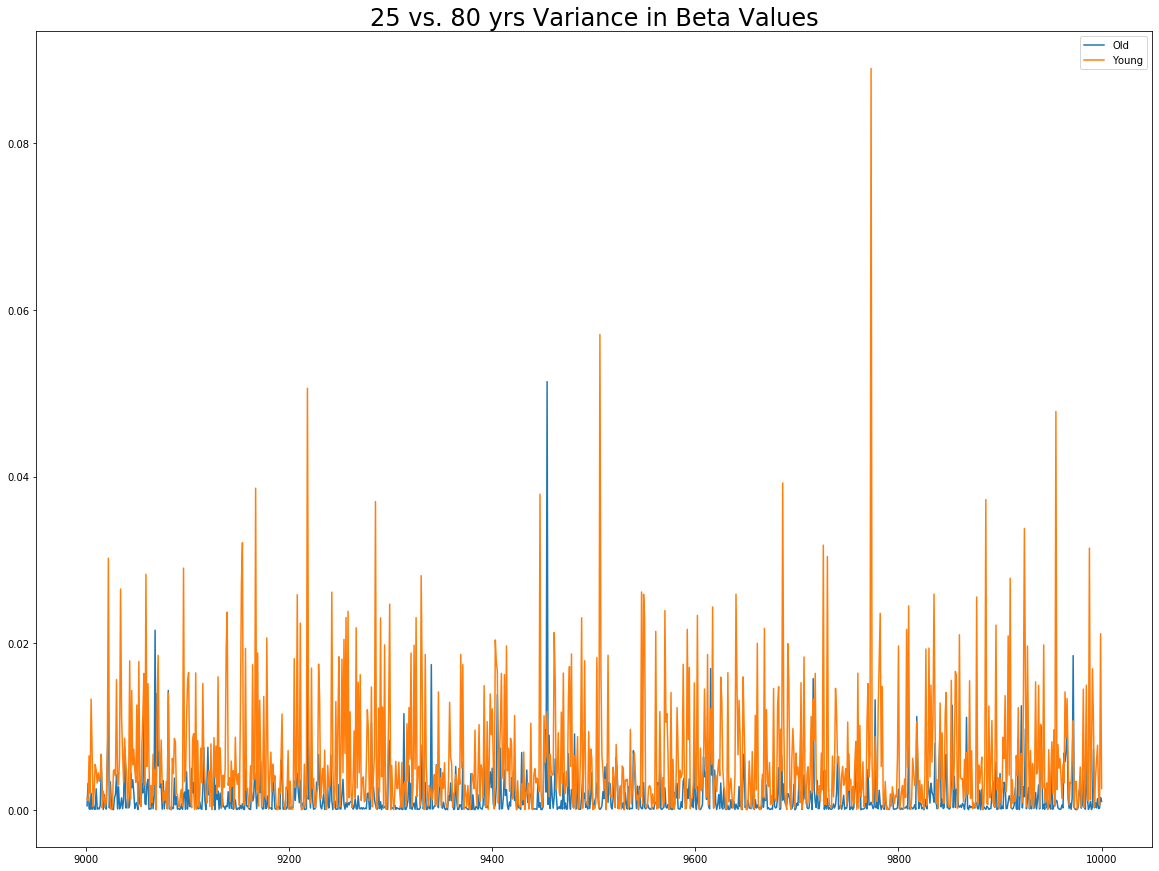

In [360]:
plt.figure(figsize=(20, 15))
plt.plot(x[9000:10000], old_variances[9000:10000], label = 'Old')
plt.plot(x[9000:10000], young_variances[9000:10000], label = 'Young')
plt.title('25 vs. 80 yrs Variance in Beta Values', fontsize=24)
plt.legend()

In [380]:
len(data1.columns)

1471

# Kde plots for entire data set

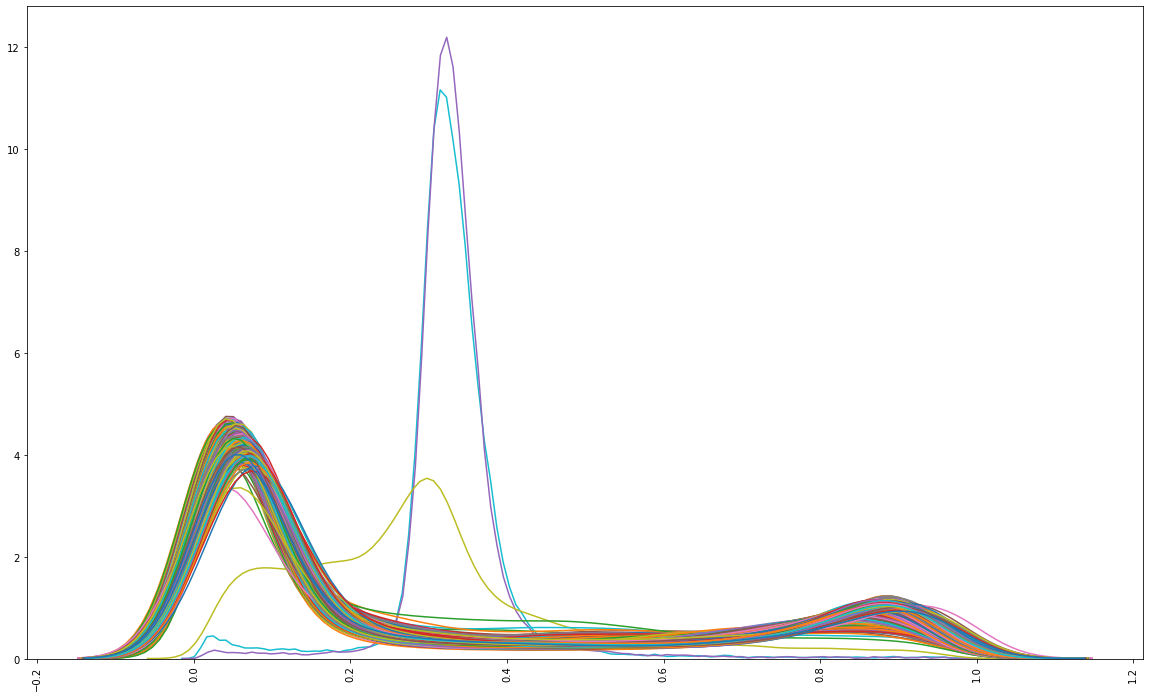

In [381]:
fig, ax = plt.subplots(figsize=(20,12))
plt.xticks(rotation=90)


for i in range(len(data1.columns)):
    sns.kdeplot(data = data1.iloc[:,i], legend = None)
    
# for i in range(50):
#     sns.kdeplot(data = young_betas.iloc[:,i], color='g', legend = None)


# Kde plots for old and young

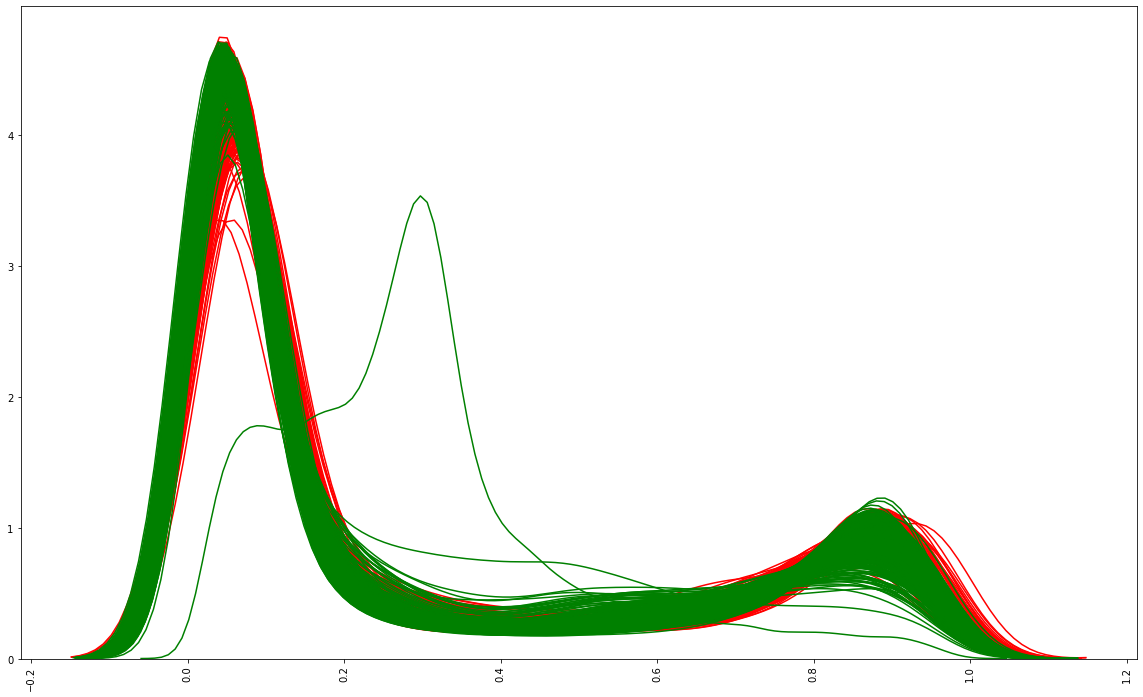

In [403]:
fig, ax = plt.subplots(figsize=(20,12))
plt.xticks(rotation=90)


for i in range(len(old_betas.columns)):
    sns.kdeplot(data = old_betas.iloc[:,i], color='r', legend = None)
    
for j in range(len(young_betas.columns)):
    sns.kdeplot(data = young_betas.iloc[:,j], color='g', legend = None)


# Full Hannum Dataset 

In [ ]:
hannum = pd.read_excel(r'Hannum raw.xlsx')

In [406]:
hannum

CpG   GSM989829   GSM989832    GSM989835   GSM989839  \
0       cg13869341    0.751596    0.905383     0.785725    0.850603   
1       cg14008030    0.487245    0.536831     0.526291    0.546799   
2       cg12045430     0.08923    0.096142     0.076284    0.098553   
3       cg20826792     0.23766     0.22979     0.198577    0.251681   
4       cg00381604    0.045588    0.018335      0.04998    0.038832   
...            ...         ...         ...          ...         ...   
472980  cg22662321  0.05899001  0.07045191   0.07101948  0.06445187   
472981  cg06996138  0.01685406  0.02581376  0.009123479  0.01423111   
472982  cg16817496   0.2964557   0.2892102    0.2462443   0.2814198   
472983  cg07660283   0.7032914   0.7837438    0.6978488   0.7062926   
472984  cg09226288   0.7035226   0.6989815    0.6794755   0.6804768   

         GSM989841   GSM989858   GSM989860   GSM989862   GSM989863  ...  \
0          0.86647    0.897206    0.909493    0.889957    0.860722  ...   
1         0.497211     0.50393    0.534798    0.494051    0.529331  ...   
2         0.091427    0.091702    0.061267    0.085808    0.080003  ...   
3         0.282044    0.241572    0.190706    0.215903    0.253181  ...   
4         0.048522    0.042544    0.037454    0.047278    0.052632  ...   
...            ...         ...         ...         ...         ...  ...   
472980  0.06361247  0.07257383  0.06485431  0.06436981  0.04896601  ...   
472981  0.01390487  0.01429719  0.02434505   0.0104208  0.01583704  ...   
472982   0.1953078   0.3732248   0.2061898   0.1986311   0.3107579  ...   
472983   0.7382464    0.782008   0.7143294    0.691399   0.6401315  ...   
472984   0.6913277    0.712451   0.7135976   0.7367548   0.6664848  ...   

         GSM990580   GSM990588   GSM990597   GSM990598   GSM990600  \
0         0.797895    0.794161     0.80627    0.889132     0.81404   
1         0.612373    0.539385    0.541269    0.581112    0.577902   
2         0.090933    0.076736    0.054415    0.059052    0.039196   
3         0.193323    0.171183    0.172837    0.220952    0.142783   
4         0.022755    0.030919    0.018187    0.019155    0.026772   
...            ...         ...         ...         ...         ...   
472980  0.06435791  0.05839191  0.05720327   0.0450976  0.08142409   
472981  0.03756915  0.01871222  0.01774168  0.01734011  0.02456032   
472982   0.2728783   0.2059211   0.4462233   0.2756554   0.2926342   
472983    0.739716   0.7153043   0.6615512   0.7907635   0.7827373   
472984   0.7095196   0.7193232   0.6925999   0.7101599   0.6827968   

         GSM990606   GSM990611   GSM990612   GSM990616   GSM990624  
0         0.854942    0.808998    0.814436    0.917777    0.800924  
1         0.570638    0.604162    0.592566    0.615293    0.578522  
2         0.038023    0.051005    0.068172    0.045118    0.063291  
3          0.17126     0.18886    0.186795    0.163462    0.223854  
4         0.002609    0.013518    0.021747    0.023586    0.038828  
...            ...         ...         ...         ...         ...  
472980  0.06703527  0.06497577  0.06649738  0.06647938  0.07376352  
472981  0.01704703  0.01615627  0.01881414  0.01373725  0.02379745  
472982   0.3926508   0.2114455   0.2264378   0.2318495   0.2262489  
472983   0.7106028   0.7991033   0.6746666   0.7577873   0.7408066  
472984   0.7159141   0.6780882   0.7293227   0.7315654   0.7334482  

[472985 rows x 657 columns]

In [407]:
hannum_ages = pd.read_excel(r'Training/DS3 ages.xlsx')

In [408]:
hannum_ages

ID_REF GSM989827 GSM989828 GSM989829 GSM989830 GSM989831 GSM989832  \
0  Gender         F         F         F         F         F         F   
1     Age        67        89        66        64        62        87   

  GSM989833 GSM989834 GSM989835  ... GSM990618 GSM990619 GSM990620 GSM990621  \
0         M         F         F  ...         F         F         F         F   
1        73        75        73  ...        64        79        92        70   

  GSM990622 GSM990623 GSM990624 GSM990625 GSM990626 GSM990627  
0         F         F         M         M         F         M  
1        77        78        71        68        61        73  

[2 rows x 657 columns]

In [423]:
for column in range(len(hannum.columns)-1):
    hannum.iloc[:,column+1] = pd.to_numeric(hannum.iloc[:,column+1], downcast="float")

ValueError: Unable to parse string "R	0.0267136" at position 4698

# Entropy of arthritis set

In [2]:
arts = pd.read_pickle('Datasets/Arthritis.pkl')

In [3]:
ages = pd.read_excel('Datasets/Arthritis ages.xlsx')

In [4]:
ages

Age
0     67
1     49
2     53
3     62
4     33
..   ...
684   63
685   63
686   46
687   64
688   36

[689 rows x 1 columns]

In [7]:
meta = pd.read_excel('Datasets/arthritis metadata.xlsx')

In [8]:
meta

Unnamed: 0  Age         Disease state Gender Smoking Status
0    GSM1051525   67  rheumatoid arthritis      f        current
1    GSM1051526   49  rheumatoid arthritis      f        current
2    GSM1051527   53  rheumatoid arthritis      f             ex
3    GSM1051528   62  rheumatoid arthritis      f        current
4    GSM1051529   33  rheumatoid arthritis      f          never
..          ...  ...                   ...    ...            ...
684  GSM1052209   63                Normal      f             ex
685  GSM1052210   63                Normal      f          never
686  GSM1052211   46                Normal      f          never
687  GSM1052212   64                Normal      f             ex
688  GSM1052213   36                Normal      f          never

[689 rows x 5 columns]

In [10]:
from scipy.stats import entropy

In [11]:
ents = []

from scipy.stats import entropy

for gsm in arts.index:
    
    ents+= [entropy(arts.loc[gsm].values.tolist(), base=2)]

In [13]:
col = np.where(meta['Disease state'] == 'Normal','b','r')

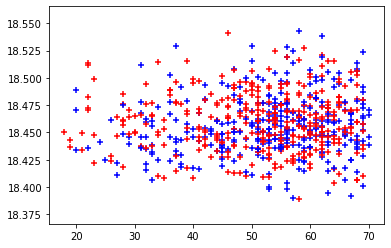

In [15]:
plt.scatter(ages.Age.astype(float), ents, marker='+', c=col)

In [17]:
col_s = np.where(meta['Gender'] == 'f','b','r')

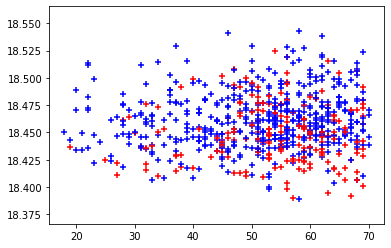

In [18]:
plt.scatter(ages.Age.astype(float), ents, marker='+', c=col_s)

In [16]:
meta

Unnamed: 0  Age         Disease state Gender Smoking Status
0    GSM1051525   67  rheumatoid arthritis      f        current
1    GSM1051526   49  rheumatoid arthritis      f        current
2    GSM1051527   53  rheumatoid arthritis      f             ex
3    GSM1051528   62  rheumatoid arthritis      f        current
4    GSM1051529   33  rheumatoid arthritis      f          never
..          ...  ...                   ...    ...            ...
684  GSM1052209   63                Normal      f             ex
685  GSM1052210   63                Normal      f          never
686  GSM1052211   46                Normal      f          never
687  GSM1052212   64                Normal      f             ex
688  GSM1052213   36                Normal      f          never

[689 rows x 5 columns]

In [19]:
col_sm = np.where(meta['Smoking Status'] == 'never','b','r')

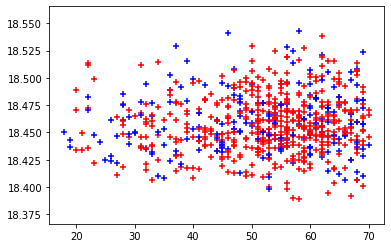

In [20]:
plt.scatter(ages.Age.astype(float), ents, marker='+', c=col_sm)

# Find CpGs which stay mostly constant w/ age

In [6]:
hannum = pd.read_pickle('Datasets/Hannum/Hannum.pkl')

In [10]:
#Read in ages for Hannum dataset 
ages = pd.read_excel('Training/DS3_ages.xlsx')
ages = ages.transpose()
headers = ages.iloc[0]
ages = pd.DataFrame(ages.values[1:], columns=headers)
ages.drop('Gender',inplace=True, axis=1)

In [32]:
candidates = []

for col in hannum.columns:
    
    if (hannum[col].values.mean() < 0.1 or hannum[col].values.mean() > 0.9 ) and hannum[col].values.std() < 0.1:
        candidates += [col]

In [33]:
len(candidates)

211766

In [37]:
list_writer(candidates, 'Datasets/constant cgs 010901')

In [7]:
candidates = list_reader('Datasets/constant cgs 010901')

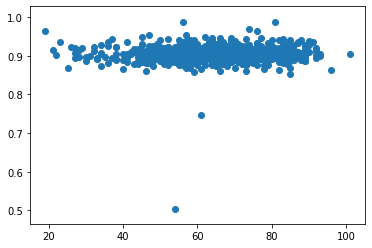

In [11]:
plt.scatter(ages.Age.astype(float) ,hannum[candidates[41]])

In [12]:
mhannum = hannum[candidates]

In [42]:
means = []

for col in mhannum.columns:
    
    means += [mhannum[col].values.mean()]

In [41]:
abs(mhannum.iloc[0,0]-mhannum[mhannum.columns[0]].values.mean())

0.0032224288109748978

In [64]:
sors = []

for gsm in hannum.index:

    sors += [(abs(mhannum.loc[gsm] - means).values.sum())/len(mhannum.columns)]

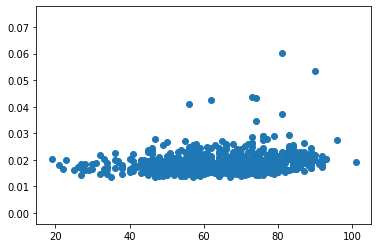

In [65]:
plt.scatter(ages.Age.astype(float), sors)

# Check sum of residuals for Arthritis

In [4]:
constants = list_reader('Datasets/Constant cgs 010901')

In [23]:
len(constants)

211766

In [6]:
arts = pd.read_pickle('Datasets/Arthritis/Arthritis.pkl')

In [7]:
ages = pd.read_excel('Datasets/Arthritis/arthritis metadata.xlsx')

In [8]:
def get_sors(data, cgs, proportion):
    
    import random
    import math
    
    cg_list = random.sample(cgs, math.floor(proportion*len(cgs)))
    
    df = data[list(set(data.columns) & set(cg_list))]
    
    means = []

    for col in df.columns:

        means += [df[col].values.mean()]

    sors = []

    for gsm in df.index:

        sors += [(abs(df.loc[gsm] - means).values.sum())/len(df.columns)]
        
    return sors

In [9]:
ages

Unnamed: 0  Age         Disease state Gender Smoking Status
0    GSM1051525   67  rheumatoid arthritis      f        current
1    GSM1051526   49  rheumatoid arthritis      f        current
2    GSM1051527   53  rheumatoid arthritis      f             ex
3    GSM1051528   62  rheumatoid arthritis      f        current
4    GSM1051529   33  rheumatoid arthritis      f          never
..          ...  ...                   ...    ...            ...
684  GSM1052209   63                Normal      f             ex
685  GSM1052210   63                Normal      f          never
686  GSM1052211   46                Normal      f          never
687  GSM1052212   64                Normal      f             ex
688  GSM1052213   36                Normal      f          never

[689 rows x 5 columns]

In [74]:
set(ages['Smoking Status'])

{'current', 'ex', 'na', 'never', 'occasional'}

In [133]:
col = np.where((ages['Smoking Status'] != 'never') | (ages['Disease state'] == 'rheumatoid arthritis' ),'r','b')

In [10]:
col = np.where(ages['Disease state'] == 'rheumatoid arthritis','r','b')

In [138]:
art_sors = get_sors(arts, constants, 0.0001)

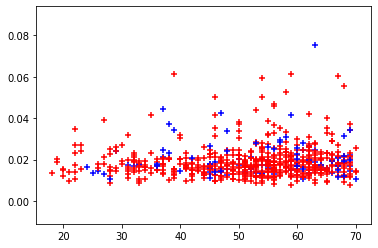

In [139]:
plt.scatter(ages.Age.astype(float), art_sors, marker='+', c=col)

# SOR for MS

In [40]:
ms = pd.read_pickle('Datasets/MS.pkl')

FileNotFoundError: [Errno 2] No such file or directory: 'Datasets/MS.pkl'

In [7]:
meta = pd.read_excel('Datasets/MS ages.xlsx')

In [8]:
meta

Unnamed: 0   Disease Status  Age
0    GSM2844230          MS case   27
1    GSM2844231          MS case   22
2    GSM2844232          MS case   40
3    GSM2844233          MS case   55
4    GSM2844234          MS case   43
..          ...              ...  ...
274  GSM2844550  Healthy control   37
275  GSM2844551          MS case   48
276  GSM2844552          MS case   23
277  GSM2844553  Healthy control   54
278  GSM2844554  Healthy control   46

[279 rows x 3 columns]

In [14]:
col = np.where(meta['Disease Status'] == 'Healthy control','b','r')

In [44]:
sors = get_sors(ms, constants, 0.001)

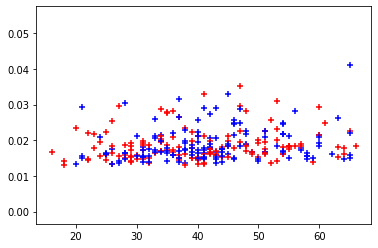

In [45]:
plt.scatter(meta.Age.astype(float), sors, marker='+', c=col)

# Entropy of age-constant CpGs

In [26]:
def get_ent(data, cgs, proportion):
    
    import random
    import math
    
    cg_list = random.sample(cgs, math.floor(proportion*len(cgs)))
    
    df = data[list(set(data.columns) & set(cg_list))]
    
    ents = []

    from scipy.stats import entropy

    for gsm in df.index:

        ents+= [entropy(df.loc[gsm].values.tolist(), base=2)]

    return ents

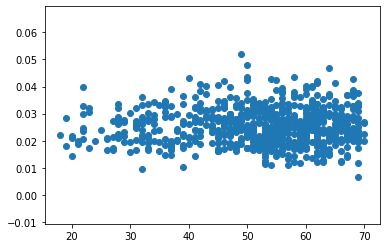

In [58]:
plt.scatter(ages.Age.astype(float), arts[constants[5]])

In [106]:
col = np.where(ages['Disease state'] == 'rheumatoid arthritis','r','b')

In [61]:
col = np.where((ages['Smoking Status'] != 'never') & (ages['Disease state'] == 'rheumatoid arthritis' ),'r','b')

In [117]:
ents = get_ent(arts, constants, 0.0005)

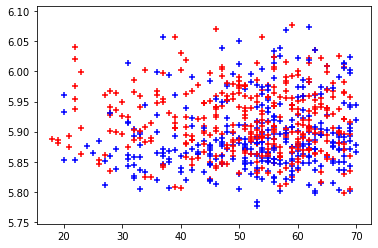

In [118]:
plt.scatter(ages.Age.astype(float), ents, marker='+', c=col)